In [1]:
import itertools
import sys, os

import numpy as np
import pandas as pd
from scipy.special import comb
from scipy import stats
import scipy.cluster.hierarchy as hac
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore
sns.set(rc={'figure.figsize':(15,8)})
sns.set_context('poster')
sns.set_style('white')


In [2]:
%load_ext autoreload
%autoreload 2
import CCPA_lib as cp


In [3]:
sns.set_context('poster')

In [4]:
pedge = 'green'
apallete = "spring"
aorder = ['DE', 'DE1', '1A3', 'ATCC', 'BS11']
amarkers = ['P', 'X', 'h', '<','>']
apallete = ['#6dad36', '#c7e89f', '#f5c4e1', '#d5579d', '#8a0850']

aedge='orange'
epallete = ['#6cf0ba', '#d13f75', '#eeb7cb', '#b9d2d8', '#407f90']
#sns.diverging_palette(355, 217, s=74, l=50, n=4) #'Paired' # 'BrBG'# "coolwarm"
eorder = ['e1','e3', 'e4', 'e5', 'e6']
#aedge='orange'

espallete = ['#6cf0ba', '#D55282', '#538B9B']

In [5]:
meta_df = pd.read_excel('exp 6 transfer Apr2019.xlsx', sheet_name='sent for seq')
meta_df.rename(columns={'#': 'sample_number'}, inplace=True)
meta_df.sample_number = pd.to_numeric(meta_df.sample_number)

In [6]:
import json
with open(os.path.join('DNA','dnaseq', 'qualimap_multiqc_data','multiqc_data.json')) as fp:
    qualimap_json = json.load(fp)

In [7]:

qualimap_json.keys()

dict_keys(['report_data_sources', 'report_general_stats_data', 'report_general_stats_headers', 'report_multiqc_command', 'report_plot_data', 'report_saved_raw_data', 'config_analysis_dir_abs', 'config_analysis_dir', 'config_creation_date', 'config_git_hash', 'config_intro_text', 'config_report_comment', 'config_report_header_info', 'config_script_path', 'config_short_version', 'config_subtitle', 'config_title', 'config_version'])

In [8]:
qmap_titles = {i : qualimap_json['report_general_stats_headers'][0][i]['title'].replace('&ge;', '>')
 for i in qualimap_json['report_general_stats_headers'][0] }

In [9]:
len(qualimap_json['report_general_stats_data'])

1

In [10]:
def _item_to_dict(k,v):
    v['Key'] = k.split('|')[0]
    return v
bamqc_df = pd.DataFrame([_item_to_dict(k,v) for k,v in qualimap_json['report_general_stats_data'][0].items()])

In [11]:
bamqc_df.head()

total_reads  mapped_reads  percentage_aligned  general_error_rate  \
0     550761.0      134228.0           24.371370                0.44   
1      79690.0        9854.0           12.365416                3.72   
2     268388.0       54226.0           20.204331                0.18   
3     221198.0        1103.0            0.498648               11.42   
4     261903.0      251977.0           96.210047                0.28   

   mean_coverage             Key  median_coverage  median_insert_size  avg_gc  \
0         4.8599         12_1A3               NaN                 NaN     NaN   
1         0.3646          21_DE               NaN                 NaN     NaN   
2         4.9590     18_MIT0604               NaN                 NaN     NaN   
3         0.0442  17_Maricaulis               NaN                 NaN     NaN   
4         9.0282         06_1A3               NaN                 NaN     NaN   

   1_x_pc  5_x_pc  10_x_pc  30_x_pc  50_x_pc  
0     NaN     NaN      NaN      NaN      NaN  
1     NaN     NaN      NaN      NaN      NaN  
2     NaN     NaN      NaN      NaN      NaN  
3     NaN     NaN      NaN      NaN      NaN  
4     NaN     NaN      NaN      NaN      NaN

In [12]:
bamqc_df = bamqc_df.pivot_table(index='Key').reset_index()
bamqc_df = bamqc_df.loc[~bamqc_df.Key.isin(['08_1A3', '08_MIT9313'])]
bamqc_df[['sample_number', 'species']] = bamqc_df.Key.str.split('_', expand=True)
bamqc_df['sample_number'] = pd.to_numeric(bamqc_df['sample_number'])
bamqc_df = bamqc_df.loc[bamqc_df.sample_number != 8]

bamqc_df.head()


Key    10_x_pc     1_x_pc    30_x_pc    50_x_pc     5_x_pc  \
0         01_1A3   99.665126  99.986713  44.556351   2.066889  99.956183   
1          02_DE   99.530857  99.948538  42.842870   1.027107  99.871411   
2     03_MIT9313   99.511546  99.995106  49.137470   2.178381  99.926126   
3     04_MIT0604   99.686022  99.756750  73.074687  10.393352  99.751076   
4  04_Maricaulis    0.000000   0.853247   0.000000   0.000000   0.004720   

      avg_gc  general_error_rate  mapped_reads  mean_coverage  \
0  45.442369                0.30      818317.0        29.0857   
1  45.545246                0.52      741707.0        28.4919   
2  51.545547                0.21      544213.0        29.7018   
3  32.475995                0.19      366615.0        36.2127   
4  60.340426               11.37         404.0         0.0180   

   median_coverage  median_insert_size  percentage_aligned  total_reads  \
0             28.0               153.0           99.578719     821779.0   
1             28.0               156.0           98.530492     752769.0   
2             29.0               114.0           98.872316     550420.0   
3             36.0               160.0           68.248963     537173.0   
4              0.0               148.0            0.246791     163701.0   

   sample_number      species  
0              1         1A3   
1              2          DE   
2              3     MIT9313   
3              4     MIT0604   
4              4  Maricaulis

In [13]:
bamqc_df = pd.merge(bamqc_df, meta_df, on='sample_number', how='left')

In [14]:
bamqc_df.columns

Index(['Key', '10_x_pc', '1_x_pc', '30_x_pc', '50_x_pc', '5_x_pc', 'avg_gc',
       'general_error_rate', 'mapped_reads', 'mean_coverage',
       'median_coverage', 'median_insert_size', 'percentage_aligned',
       'total_reads', 'sample_number', 'species', 'sample', 'PRO', 'ALT',
       'exp', 'days', 'ng/ul', 'final volume'],
      dtype='object')

In [15]:
value_cols = ['sample', 'PRO', 'ALT',
       'exp', '5_x_pc', '10_x_pc', '30_x_pc', 'avg_gc',
       
         'percentage_aligned','median_coverage','mean_coverage','median_insert_size',
        'general_error_rate', 'mapped_reads', 'total_reads'
             ]
        
pct_cols = [ '5_x_pc', '10_x_pc', '30_x_pc', 'avg_gc',
         'percentage_aligned']
with pd.ExcelWriter('bamqc_stats.xlsx', engine='xlsxwriter') as writer:  
    workbook  = writer.book
    format1 = workbook.add_format({'num_format': '#,##0.00'})
    format2 = workbook.add_format({'num_format': '0%'})
    for i in bamqc_df.species.unique():
        bamqc_pdf = bamqc_df.loc[bamqc_df.species.isin([i])].pivot(index='sample_number', columns='species', 
                               values=value_cols)
        bamqc_pdf[pct_cols] = bamqc_pdf[pct_cols]/100
        bamqc_pdf.rename(columns=qmap_titles, inplace=True)
        sheetname = f'{i} bamqc'
        bamqc_pdf.to_excel(writer, sheet_name=sheetname)
        worksheet = writer.sheets[sheetname]
        worksheet.set_column('F:J', None, format2)
        worksheet.set_column('L:L', None, format1)
        
        
        worksheet.conditional_format(f'F1:H{bamqc_df.shape[0]+2}', {'type': 'data_bar'})
        worksheet.conditional_format(f'K1:L{bamqc_df.shape[0]+2}', {'type': 'data_bar', 'bar_color' : 'green'})
    



In [16]:
import json
with open(os.path.join('DNA','dnaseq_trimmed', 'multiqc_data.json')) as fp:
    qualimap_json = json.load(fp)

In [17]:
trimmed_titles = {i : qualimap_json['report_general_stats_headers'][0][i]['title'].replace('&ge;', '>')
 for i in qualimap_json['report_general_stats_headers'][0] }

In [18]:
len(qualimap_json['report_general_stats_data'])

4

In [19]:
def _item_to_dict(k,v):
    v['Key'] = k.split('|')[0]
    return v
trimmed_df = pd.DataFrame([
    _item_to_dict(k,v) 
    for d in qualimap_json['report_general_stats_data']
    for k,v in d.items()
])

In [20]:
trimmed_df.head()

total_reads  mapped_reads  percentage_aligned  general_error_rate  \
0     488749.0        8101.0            1.657497                2.13   
1      65170.0        7893.0           12.111401                2.10   
2     489657.0       15149.0            3.093798                2.02   
3     489977.0        1455.0            0.296953                3.89   
4     491414.0      420148.0           85.497768                0.09   

   mean_coverage  median_coverage  median_insert_size     avg_gc     1_x_pc  \
0         0.2863              0.0               154.0  45.754564  14.741716   
1         0.2794              0.0               154.0  45.670117  14.524395   
2         0.5048              0.0               155.0  45.738068  24.717820   
3         0.0886              0.0               128.0  53.353191   0.461617   
4        38.4190             38.0               153.0  32.643963  99.754840   

      5_x_pc  ...  forward_only_surviving_pct  reverse_only_surviving  \
0   0.159721  ...                         NaN                     NaN   
1   0.117342  ...                         NaN                     NaN   
2   0.413449  ...                         NaN                     NaN   
3   0.375300  ...                         NaN                     NaN   
4  99.705684  ...                         NaN                     NaN   

   reverse_only_surviving_pct dropped dropped_pct  percent_gc  \
0                         NaN     NaN         NaN         NaN   
1                         NaN     NaN         NaN         NaN   
2                         NaN     NaN         NaN         NaN   
3                         NaN     NaN         NaN         NaN   
4                         NaN     NaN         NaN         NaN   

   avg_sequence_length  total_sequences  percent_duplicates  percent_fails  
0                  NaN              NaN                 NaN            NaN  
1                  NaN              NaN                 NaN            NaN  
2                  NaN              NaN                 NaN            NaN  
3                  NaN              NaN                 NaN            NaN  
4                  NaN              NaN                 NaN            NaN  

[5 rows x 108 columns]

In [21]:
trimmed_df['Key'].unique()



array(['snippy_19_DE_all', 'snippy_19_DE_filtered', 'snippy_19_1A3_all',
       'snippy_19_MIT9313_all', 'snippy_19_MIT0604_all',
       'snippy_19_MIT0604_filtered', 'snippy_10_MIT9313_all',
       'snippy_10_MIT0604_filtered', 'snippy_10_MIT0604_all',
       'snippy_10_1A3_all', 'snippy_10_DE_all', 'snippy_10_1A3_filtered',
       'snippy_17_DE_filtered', 'snippy_17_DE_all',
       'snippy_17_MIT9313_all', 'snippy_17_MIT0604_filtered',
       'snippy_17_MIT0604_all', 'snippy_17_1A3_all',
       'snippy_13_MIT0604_all', 'snippy_13_MIT9313_all',
       'snippy_13_1A3_filtered', 'snippy_13_DE_all', 'snippy_13_1A3_all',
       'snippy_13_MIT0604_filtered', 'snippy_11_MIT0604_all',
       'snippy_11_1A3_all', 'snippy_11_MIT0604_filtered',
       'snippy_11_1A3_filtered', 'snippy_11_DE_all',
       'snippy_11_MIT9313_all', 'snippy_20_DE_filtered',
       'snippy_20_MIT0604_all', 'snippy_20_1A3_all',
       'snippy_20_MIT0604_filtered', 'snippy_20_DE_all',
       'snippy_20_MIT9313_all', 's

In [22]:
def _key_to_sample_species(x):
    mode = None
    if x.startswith('200219Seg_D20-16'):
        idx = x.replace('200219Seg_D20-', '').replace('_1_sequence','')
        sample_number = pd.to_numeric(idx) - 160000
        command = 'fastqc'
        species = None
    elif x.startswith('trim_200219Seg_D20'):
        idx = x.replace('trim_200219Seg_D20-', '').replace('_1_sequence_P','').replace('_2_sequence_P','')
        sample_number = pd.to_numeric(idx) - 160000
        command = 'trimmomatic'
        species = None
    elif x.startswith('freebayes_'):
        sample_number = None
        command = 'freebayes'
        species = x.replace('freebayes_', '')
    elif x.startswith('snippy_'):
        _, idx, species, mode = x.split('_')
        sample_number = pd.to_numeric(idx) 
        command = 'bamqc'
    return pd.Series({
        'species' : species,
         'mode' :mode,
        'sample_number' :sample_number,
        'command' : command,
    })

trimmed_df = pd.concat([trimmed_df, trimmed_df['Key'].apply(_key_to_sample_species)], axis=1)


In [23]:
trimmed_df = trimmed_df.loc[trimmed_df['sample_number'] != 8]

In [24]:
trimmed_df = pd.merge(trimmed_df, meta_df, on='sample_number', how='left')

In [25]:
trimmed_df['pair'] = trimmed_df['PRO'] + ',' + trimmed_df['ALT']

In [146]:
trimmed_df['Sample_Name'] = trimmed_df['pair'] + ' ' + trimmed_df['days'].astype(str) + ' ' + trimmed_df['sample']

In [147]:
trimmed_df.columns

Index(['total_reads', 'mapped_reads', 'percentage_aligned',
       'general_error_rate', 'mean_coverage', 'median_coverage',
       'median_insert_size', 'avg_gc', '1_x_pc', '5_x_pc',
       ...
       'sample', 'PRO', 'ALT', 'exp', 'days', 'ng/ul', 'final volume', 'pair',
       'trim', 'Sample_Name'],
      dtype='object', length=122)

In [148]:
trimmed_df.head()

total_reads  mapped_reads  percentage_aligned  general_error_rate  \
0       488749          8101                   2                   2   
1        65170          7893                  12                   2   
2       489657         15149                   3                   2   
3       489977          1455                   0                   4   
4       491414        420148                  85                   0   

   mean_coverage  median_coverage  median_insert_size  avg_gc  1_x_pc  5_x_pc  \
0              0                0                 154      46      15       0   
1              0                0                 154      46      15       0   
2              1                0                 155      46      25       0   
3              0                0                 128      53       0       0   
4             38               38                 153      33     100     100   

   ...  sample      PRO  ALT exp days  ng/ul  final volume        pair  trim  \
0  ...     10B  MIT0604   DE   6  440      6           100  MIT0604,DE  Q>20   
1  ...     10B  MIT0604   DE   6  440      6           100  MIT0604,DE  Q>20   
2  ...     10B  MIT0604   DE   6  440      6           100  MIT0604,DE  Q>20   
3  ...     10B  MIT0604   DE   6  440      6           100  MIT0604,DE  Q>20   
4  ...     10B  MIT0604   DE   6  440      6           100  MIT0604,DE  Q>20   

          Sample_Name  
0  MIT0604,DE 440 10B  
1  MIT0604,DE 440 10B  
2  MIT0604,DE 440 10B  
3  MIT0604,DE 440 10B  
4  MIT0604,DE 440 10B  

[5 rows x 122 columns]

In [180]:
bamqc_df.head().T

0        1            2            3               4
Key                 01_1A3    02_DE   03_MIT9313   04_MIT0604   04_Maricaulis 
10_x_pc                 100      100          100          100               0
1_x_pc                  100      100          100          100               1
30_x_pc                  45       43           49           73               0
50_x_pc                   2        1            2           10               0
5_x_pc                  100      100          100          100               0
avg_gc                   45       46           52           32              60
general_error_rate        0        1            0            0              11
mapped_reads         818317   741707       544213       366615             404
mean_coverage            29       28           30           36               0
median_coverage          28       28           29           36               0
median_insert_size      153      156          114          160             148
percentage_aligned      100       99           99           68               0
total_reads          821779   752769       550420       537173          163701
sample_number             1        2            3            4               4
species                1A3       DE      MIT9313      MIT0604      Maricaulis 
sample               Axenic   Axenic       Axenic       Axenic          Axenic
PRO                  Axenic   Axenic      MIT9313      MIT0604         MIT0604
ALT                     1A3       DE       Axenic       Axenic          Axenic
exp                       0        0            0            0               0
days                      0        0            0            0               0
ng/ul                    30       10            1            6               6
final volume            100      100          100          100             100
trim                adapter  adapter      adapter      adapter         adapter

In [29]:
trimmed_df.columns

Index(['total_reads', 'mapped_reads', 'percentage_aligned',
       'general_error_rate', 'mean_coverage', 'median_coverage',
       'median_insert_size', 'avg_gc', '1_x_pc', '5_x_pc',
       ...
       'sample_number', 'command', 'sample', 'PRO', 'ALT', 'exp', 'days',
       'ng/ul', 'final volume', 'pair'],
      dtype='object', length=120)

AttributeError: 'FacetGrid' object has no attribute 'get_xticklabels'

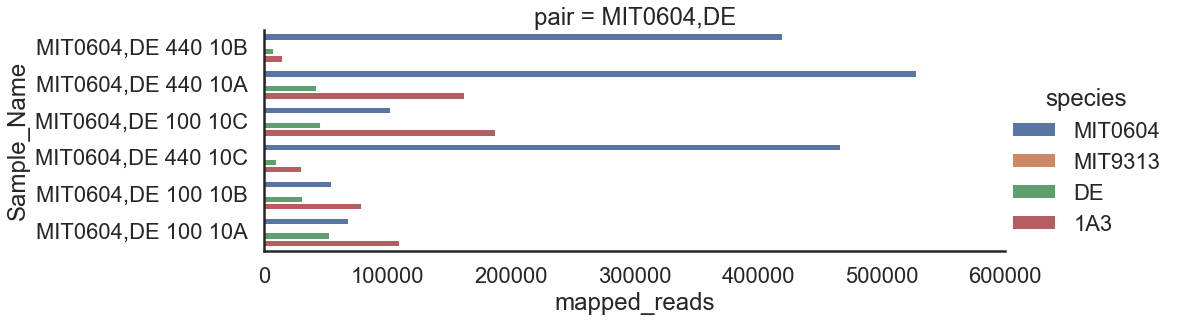

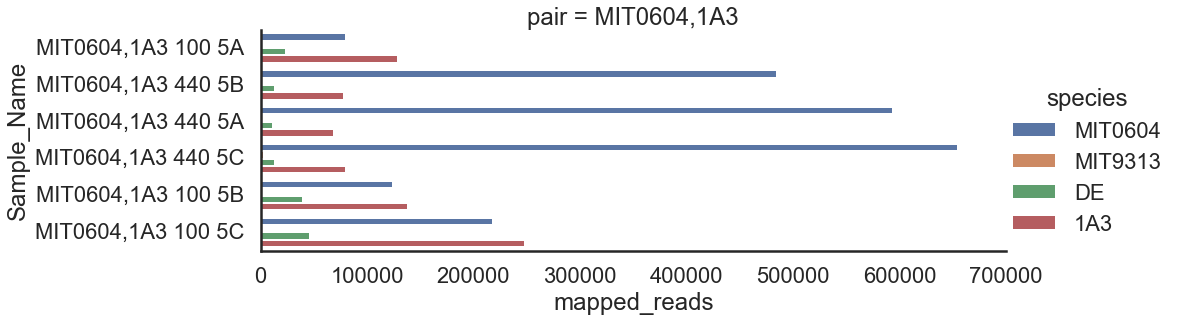

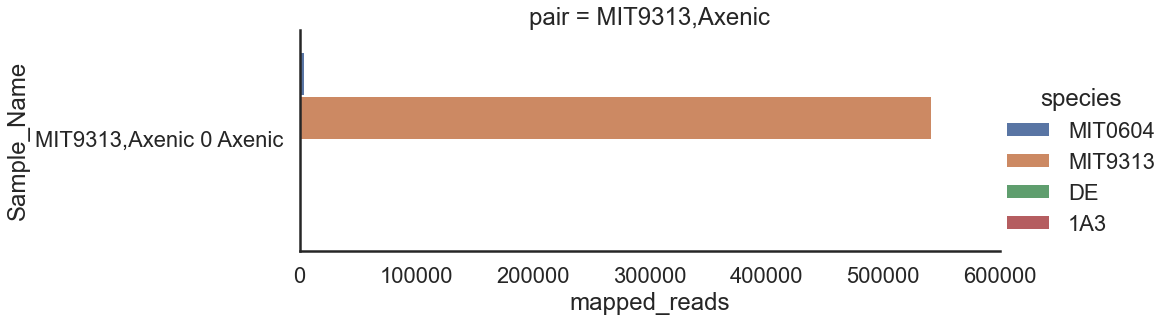

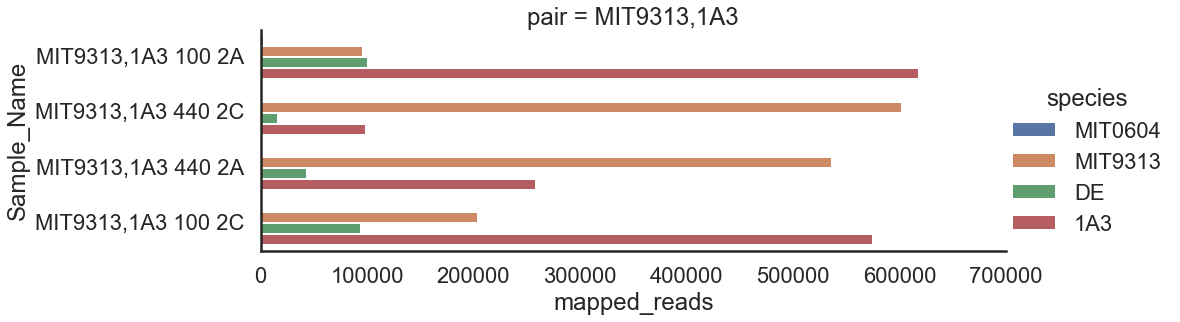

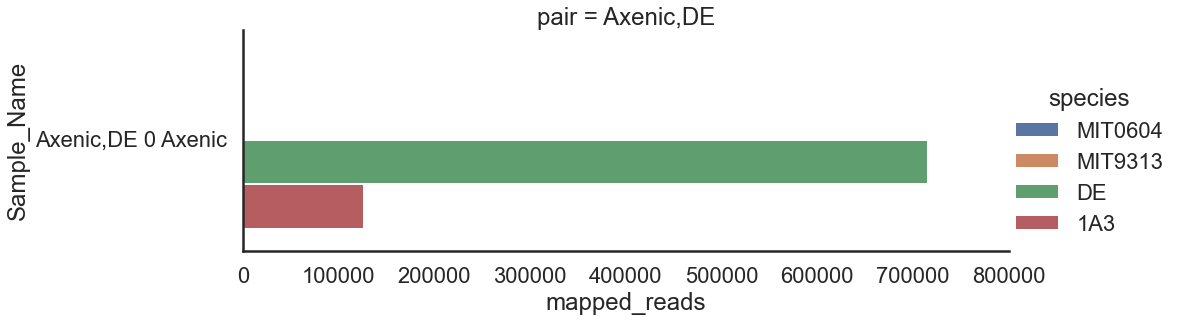

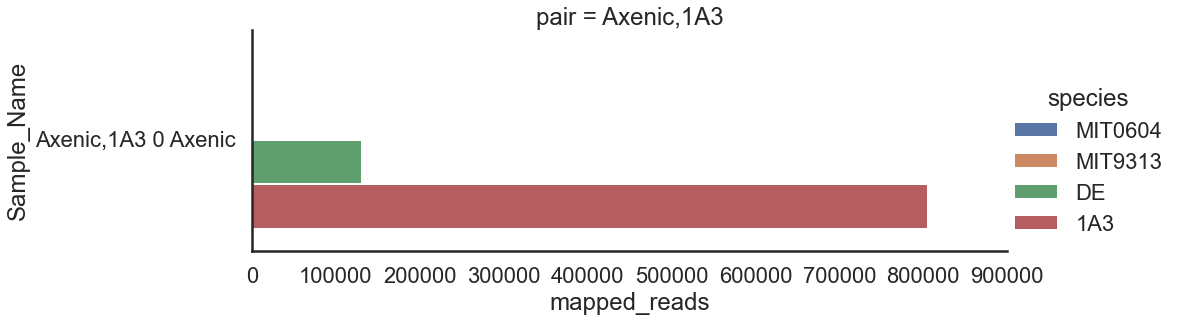

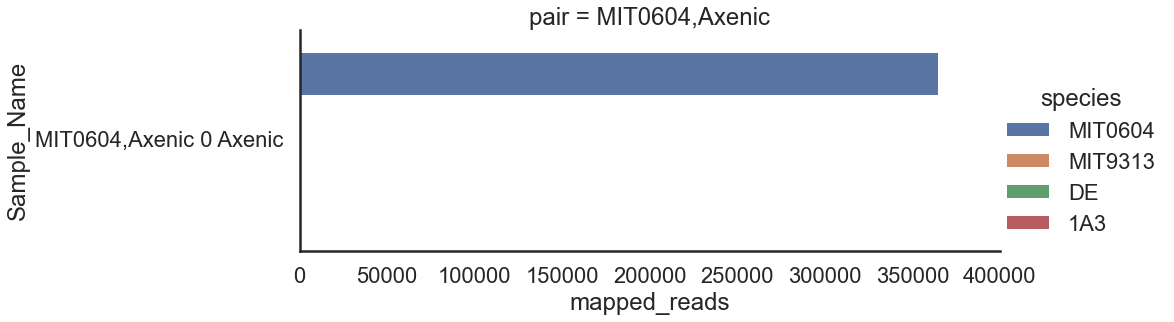

In [151]:
for i in trimmed_df['pair'].dropna().unique():

    g = sns.catplot(data=trimmed_df.loc[(trimmed_df['command'] == 'bamqc') & (trimmed_df['mode'] == 'all')
                                    & (trimmed_df['pair'] == i)
                                   ],
                y='Sample_Name', x='mapped_reads', 
               hue='species', hue_order=['MIT0604', 'MIT9313', 'DE', '1A3'],
                row='pair', sharex=False,
               aspect=3, kind='bar')
#plt.title(i)


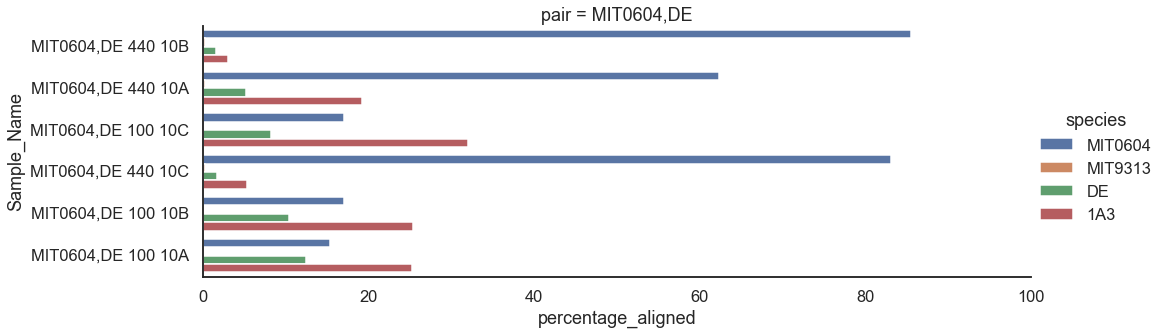

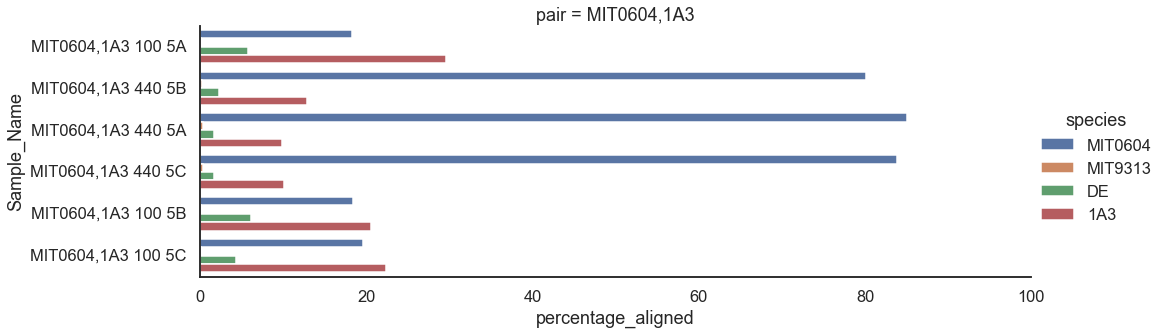

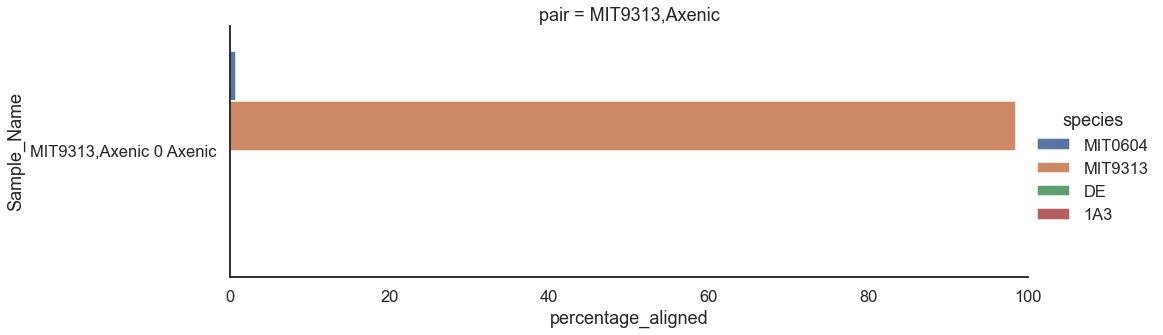

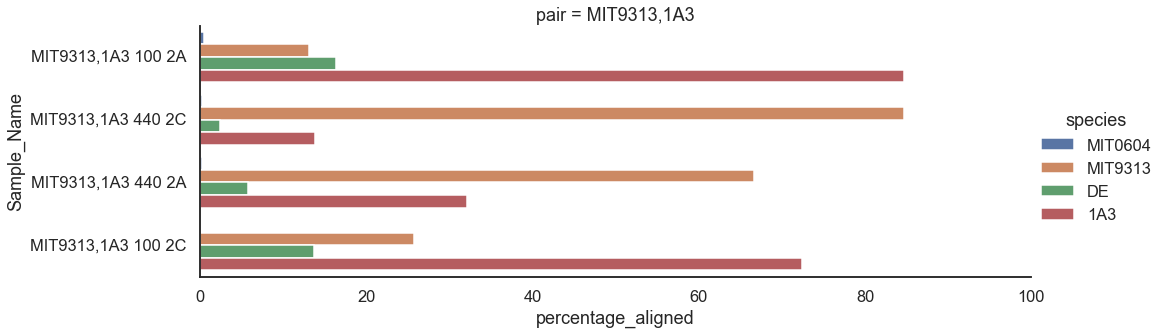

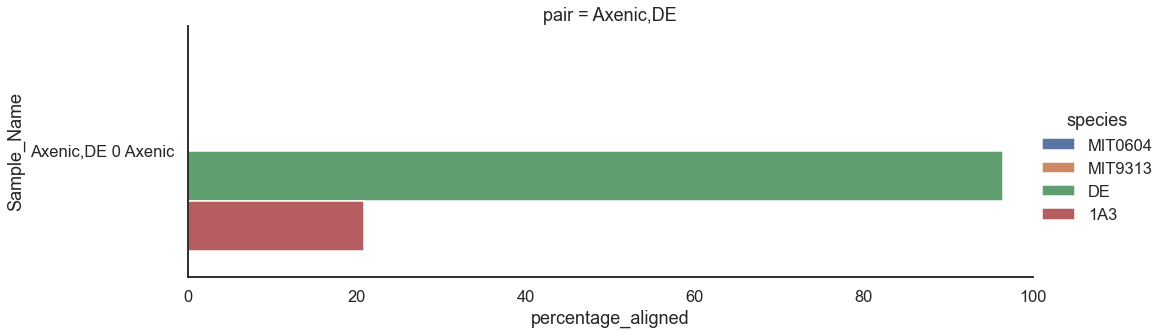

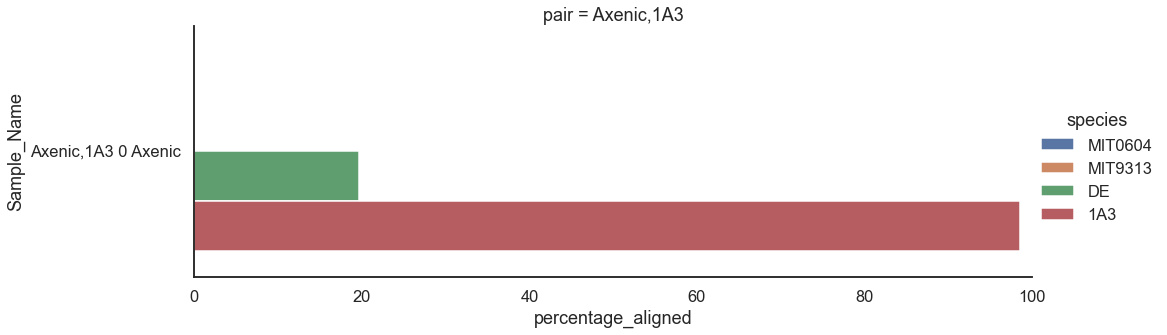

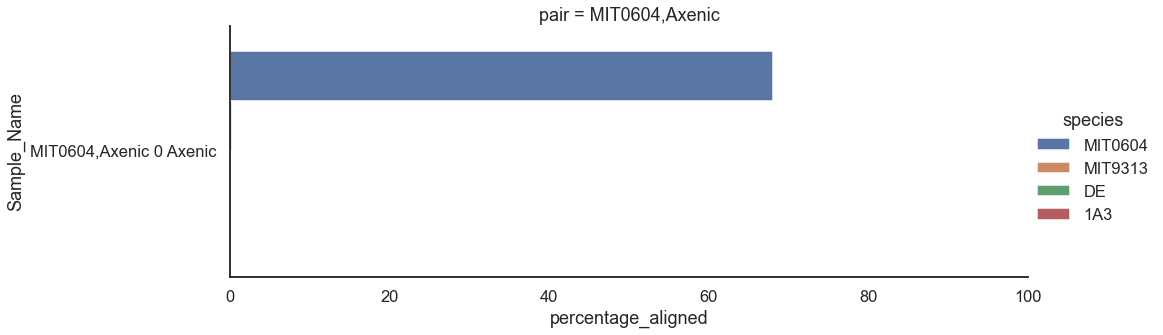

In [182]:
for i in trimmed_df['pair'].dropna().unique():

    g = sns.catplot(data=trimmed_df.loc[(trimmed_df['command'] == 'bamqc') & (trimmed_df['mode'] == 'all')
                                    & (trimmed_df['pair'] == i)
                                   ],
                y='Sample_Name', x='percentage_aligned', 
               hue='species', hue_order=['MIT0604', 'MIT9313', 'DE', '1A3'],
                row='pair', sharex=False,
               aspect=3, kind='bar')
    plt.xlim(0,100)
    plt.show()
#plt.title(i)


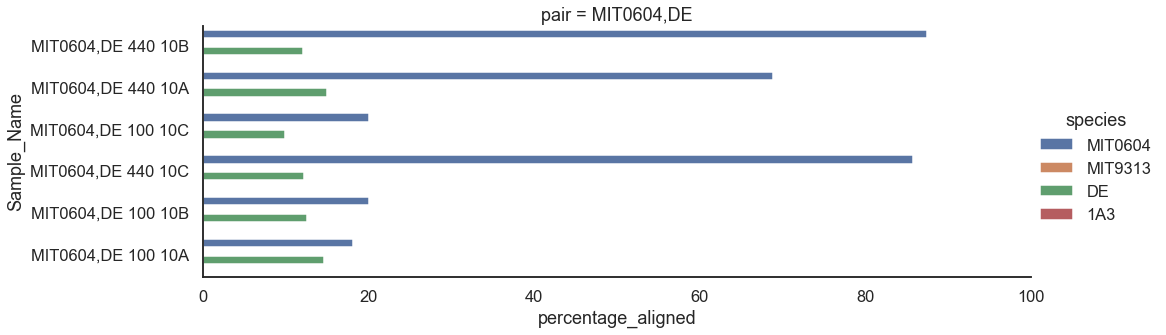

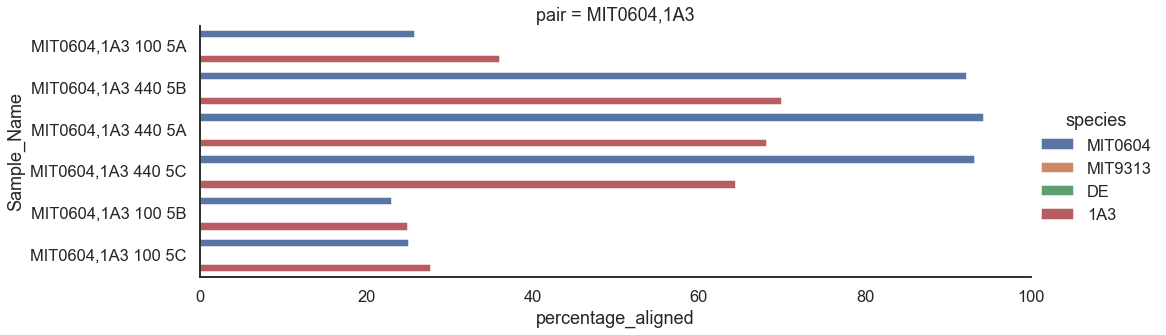

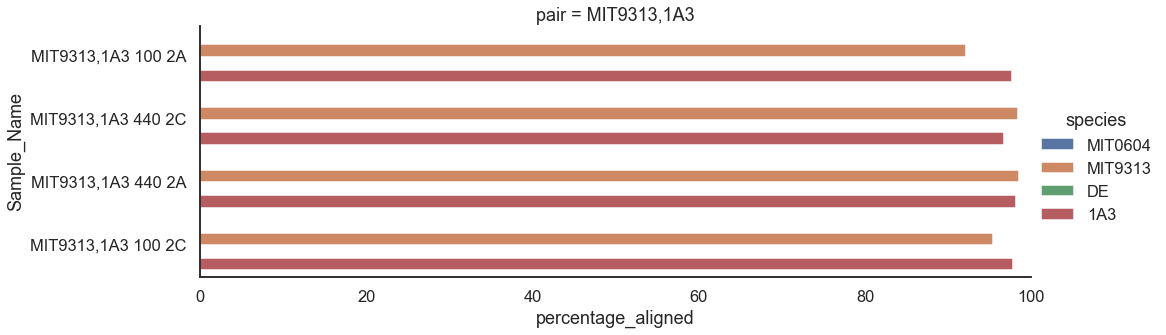

In [190]:
for i in trimmed_df.loc[(trimmed_df['sample'] != 'Axenic'),'pair'].dropna().unique():

    g = sns.catplot(data=trimmed_df.loc[(trimmed_df['command'] == 'bamqc') & (trimmed_df['mode'] == 'filtered')
                                    & (trimmed_df['pair'] == i)
                                   ],
                y='Sample_Name', x='percentage_aligned', 
               hue='species', hue_order=['MIT0604', 'MIT9313', 'DE', '1A3'],
                row='pair', sharex=False,
               aspect=3, kind='bar')
    plt.xlim(0,100)
    plt.show()
#plt.title(i)


In [192]:
trimmed_df.head().T

0                   1  \
total_reads                     488749               65170   
mapped_reads                      8101                7893   
percentage_aligned                   2                  12   
general_error_rate                   2                   2   
mean_coverage                        0                   0   
...                                ...                 ...   
ng/ul                                6                   6   
final volume                       100                 100   
pair                        MIT0604,DE          MIT0604,DE   
trim                              Q>20                Q>20   
Sample_Name         MIT0604,DE 440 10B  MIT0604,DE 440 10B   

                                     2                   3                   4  
total_reads                     489657              489977              491414  
mapped_reads                     15149                1455              420148  
percentage_aligned                   3                   0                  85  
general_error_rate                   2                   4                   0  
mean_coverage                        1                   0                  38  
...                                ...                 ...                 ...  
ng/ul                                6                   6                   6  
final volume                       100                 100                 100  
pair                        MIT0604,DE          MIT0604,DE          MIT0604,DE  
trim                              Q>20                Q>20                Q>20  
Sample_Name         MIT0604,DE 440 10B  MIT0604,DE 440 10B  MIT0604,DE 440 10B  

[122 rows x 5 columns]

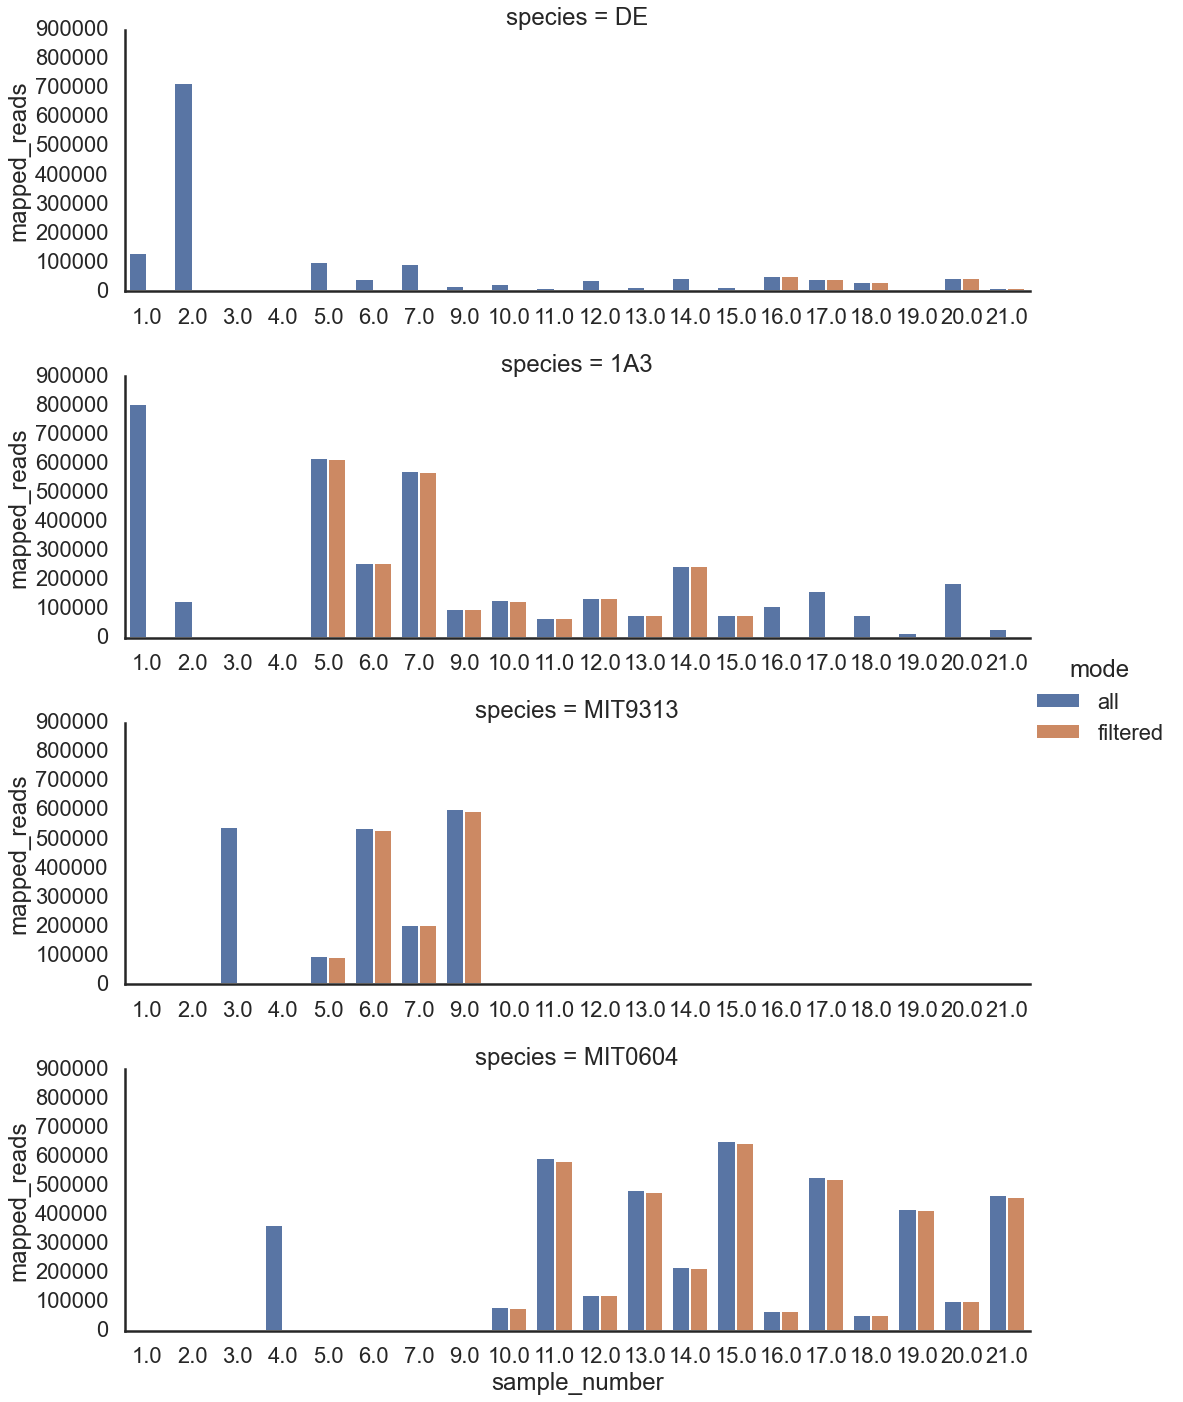

In [31]:
# pd.options.display.float_format = '{:d}'.format
sns.catplot(data=trimmed_df.loc[(trimmed_df['command'] == 'bamqc')],
            x='sample_number', y='mapped_reads', 
           row='species', hue='mode', sharex=False,
           aspect=3, kind='bar')

In [32]:
 trimmed_df.sample_number.dtypes

dtype('float64')

In [33]:
bamqc_df['trim'] = 'adapter'
trimmed_df['trim'] = 'Q>20'
pd.options.display.float_format = '{:.0f}'.format

merged_stat_df = pd.concat([
    bamqc_df.loc[~bamqc_df.species.isin(['Maricaulis '])], 
    trimmed_df.loc[
        (trimmed_df['command'] == 'bamqc') & 
        ((trimmed_df['mode'] == 'filtered') |
         ((trimmed_df['sample_number'] < 5)  & 
          (trimmed_df.PRO == trimmed_df.species) | (trimmed_df.ALT == trimmed_df.species)))
                                            ] 
                                            ],
        )

C:\Users\wosnat\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # This is added back by InteractiveShellApp.init_path()


In [34]:
merged_stat_df.species = merged_stat_df.species.str.strip()

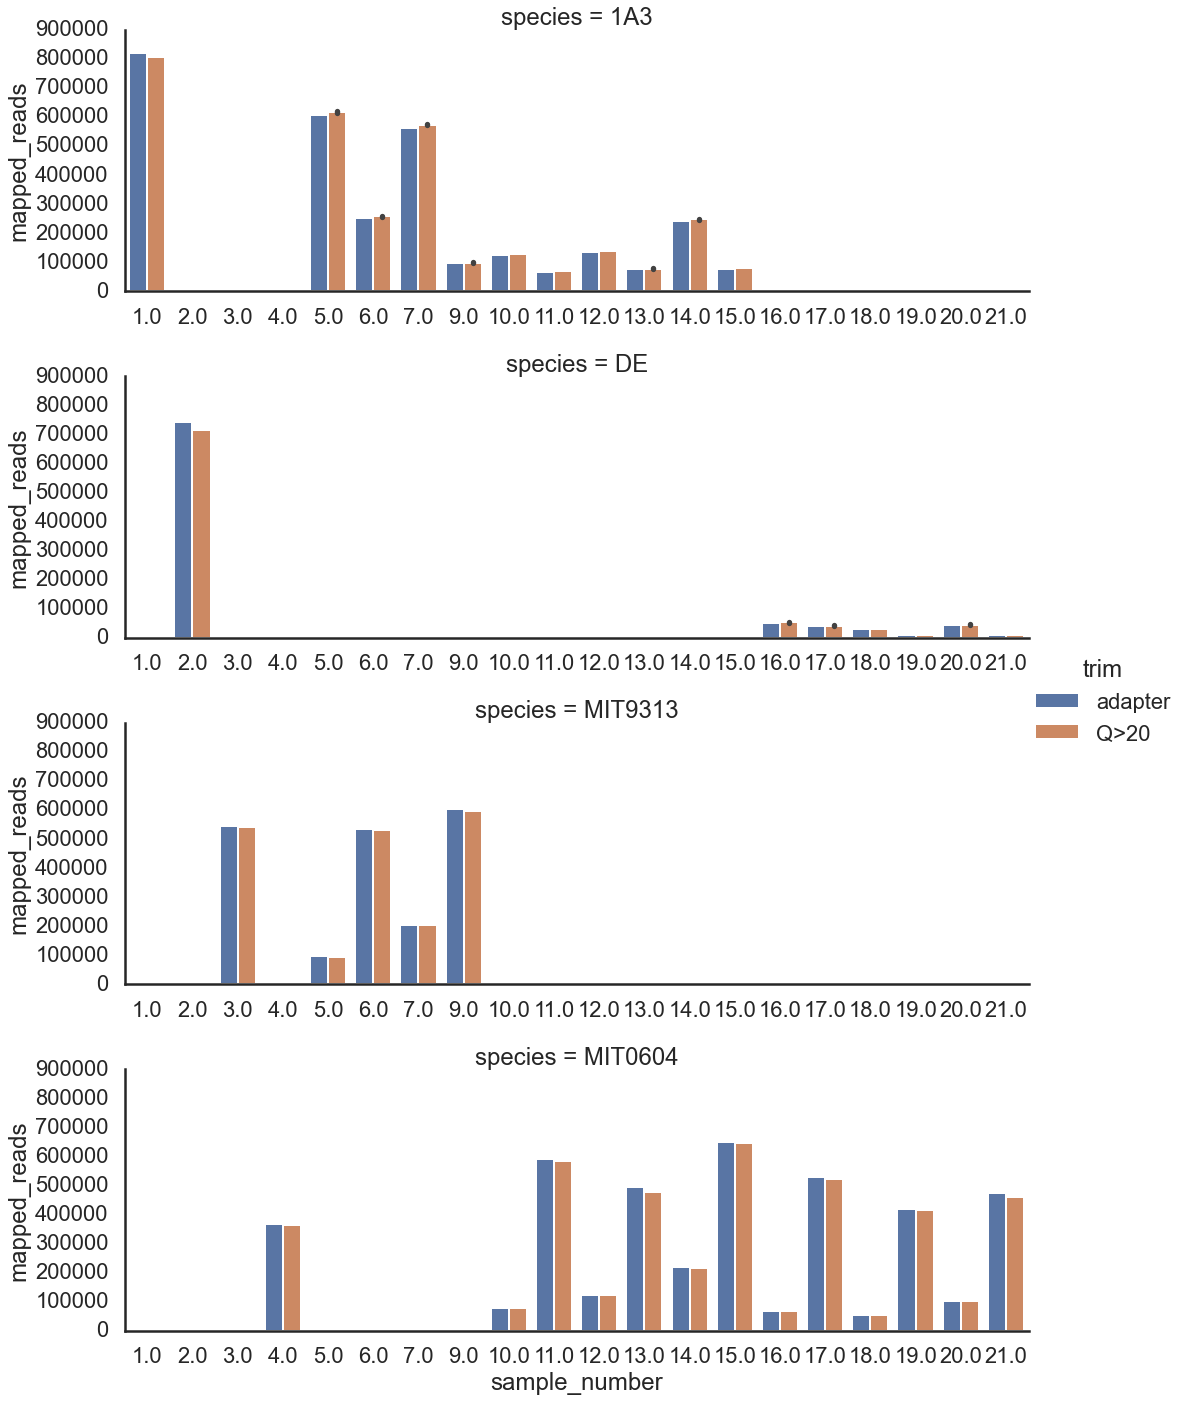

In [35]:
sns.catplot(data=merged_stat_df,
            x='sample_number', y='mapped_reads', 
           row='species', hue='trim', sharex=False,
           aspect=3, kind='bar')

Text(0.5, 1, 'mapped reads')

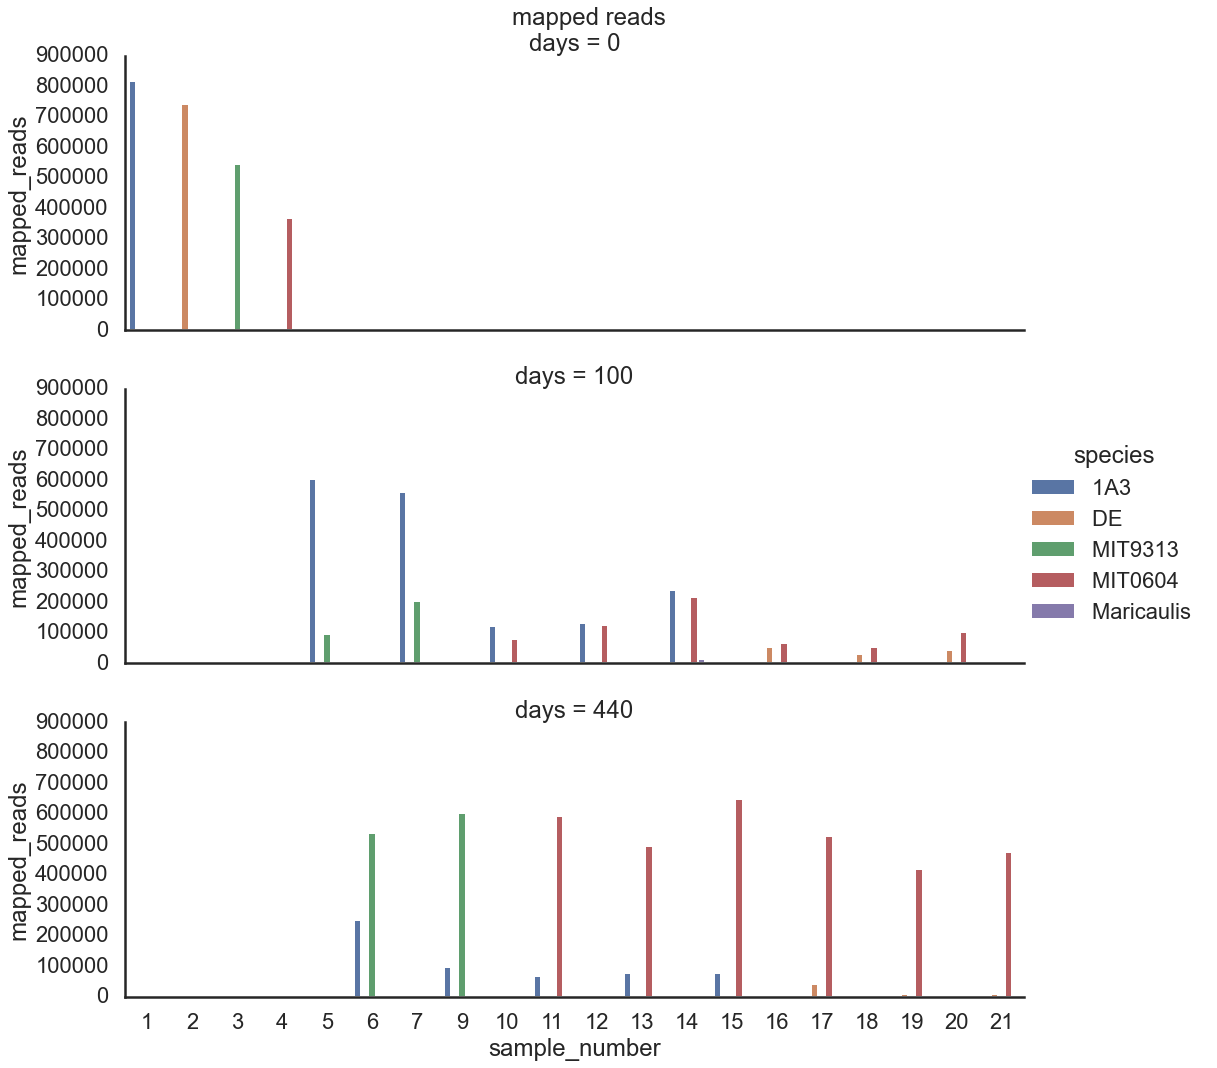

In [36]:
sns.set_style('white')
sns.set_context('poster')
sns.catplot(data=bamqc_df, x='sample_number', y='mapped_reads',hue='species', row='days', 
            kind='bar', aspect=3)
plt.suptitle('mapped reads', y=1)

Text(0.5, 1, '% cov > 10x')

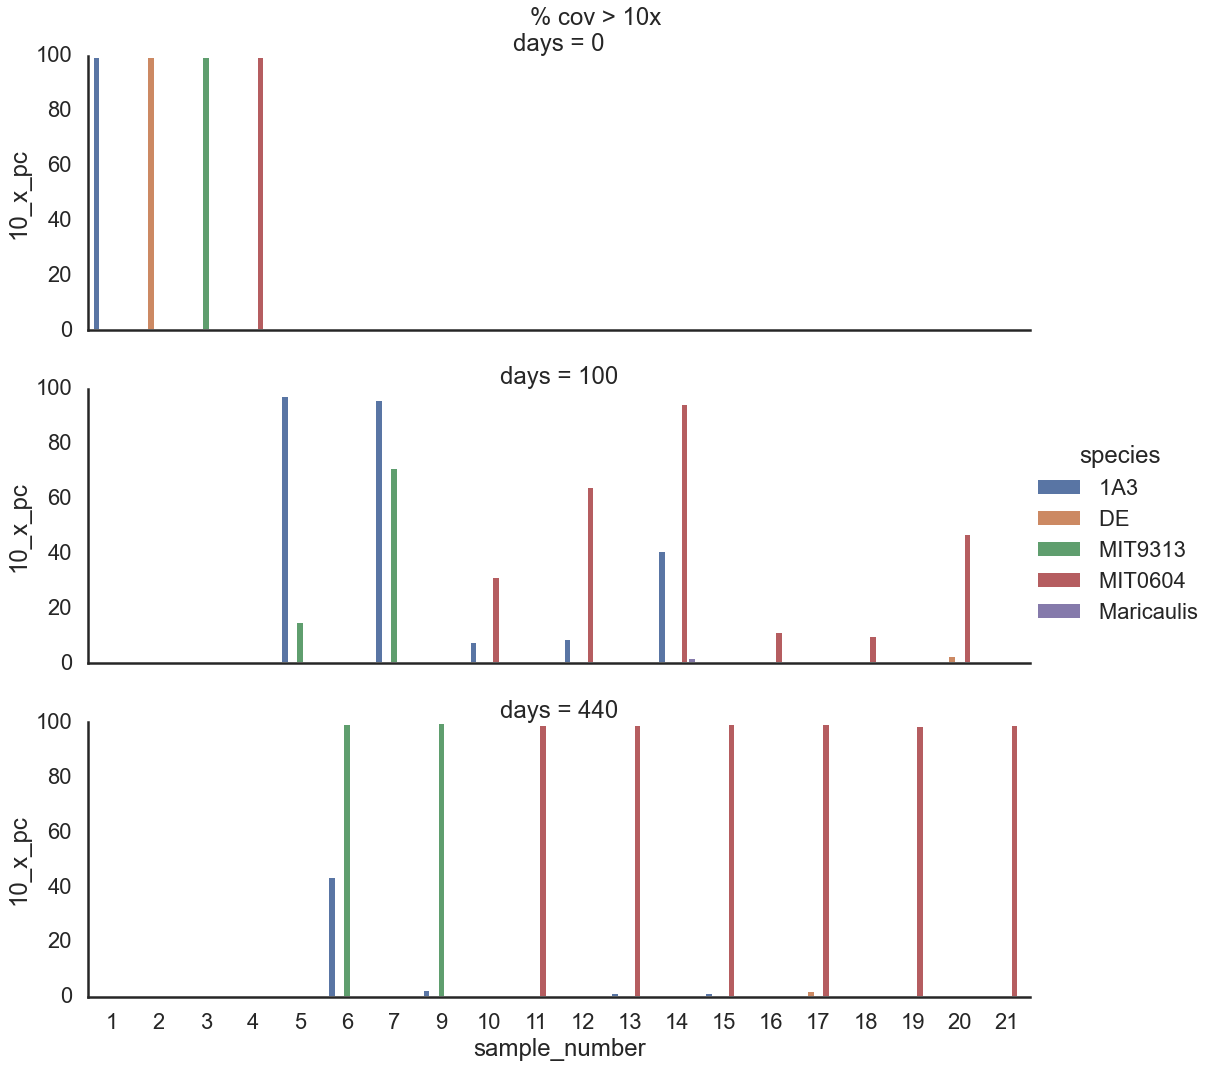

In [37]:
sns.set_style('white')
#sns.set_context('paper')
sns.catplot(data=bamqc_df, x='sample_number', y='10_x_pc',hue='species', row='days', 
            kind='bar', aspect=3)
plt.suptitle('% cov > 10x', y=1)

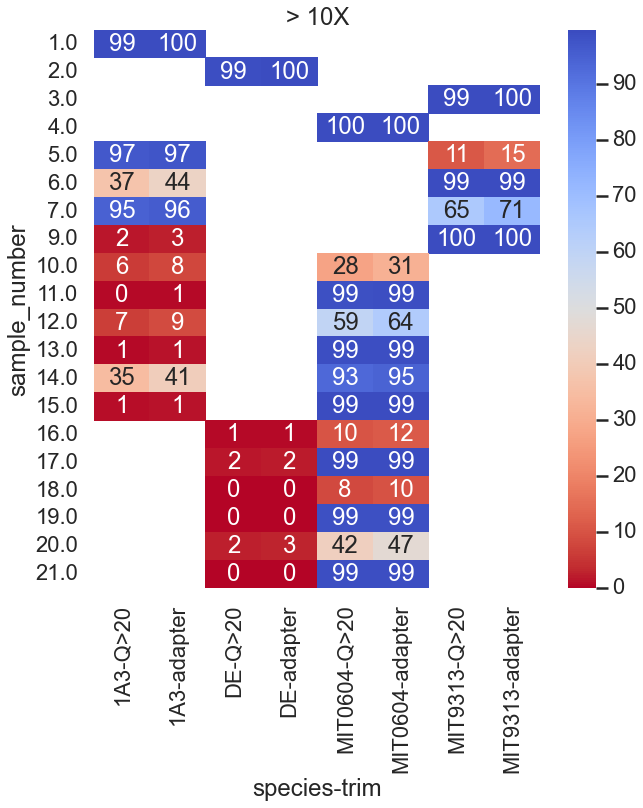

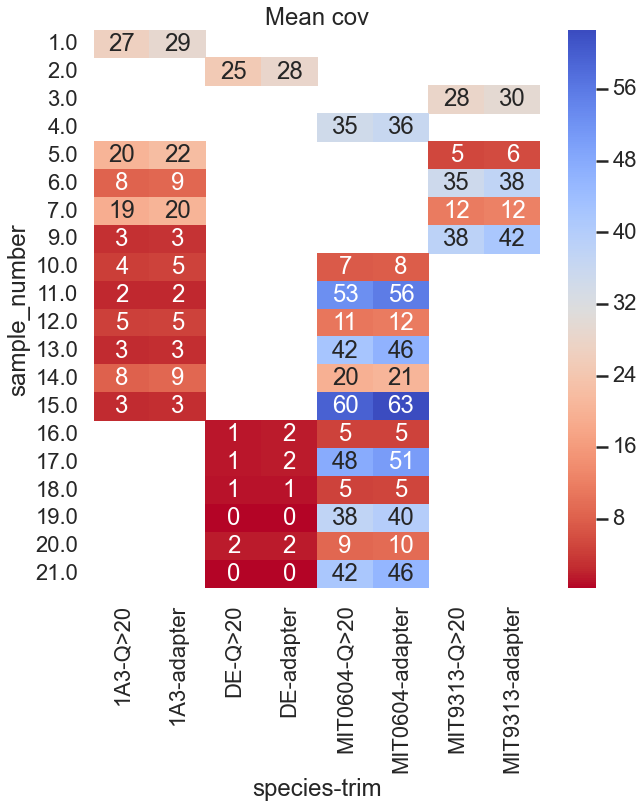

In [38]:
sns.set_context('poster')
value_cols = [  '10_x_pc',
         'mean_coverage',
              #'mapped_reads'
             ]

for v in value_cols:
    # 'sample', 'PRO', 'ALT', 'exp',
    plt.figure(figsize=(10,10))
    
    bamqc_pdf = merged_stat_df.pivot_table(index='sample_number', columns=['species', 'trim'], 
                           values=[v]).droplevel(level=0, axis='columns')
    #bamqc_pdf[pct_cols] = bamqc_pdf[pct_cols]/100
    #bamqc_pdf.rename(columns=qmap_titles, inplace=True)
    sns.heatmap(bamqc_pdf, cmap='coolwarm_r',
                  annot=True, fmt='.0f')
    plt.title(qmap_titles[v])
    plt.show()

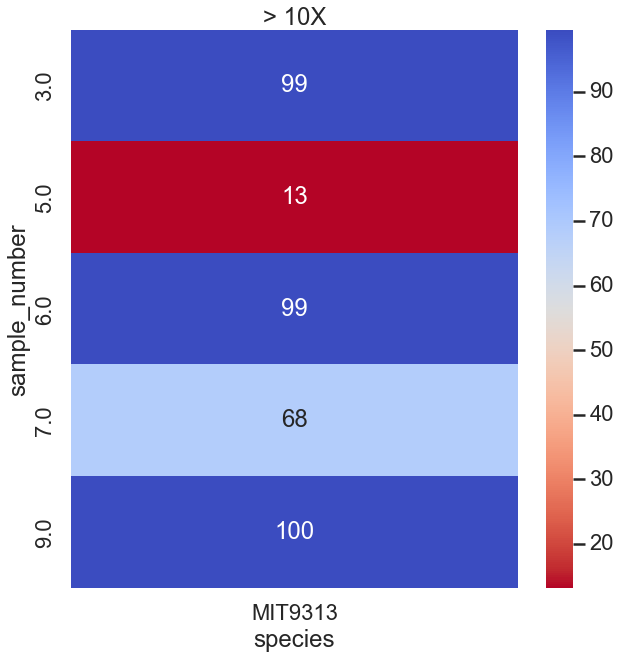

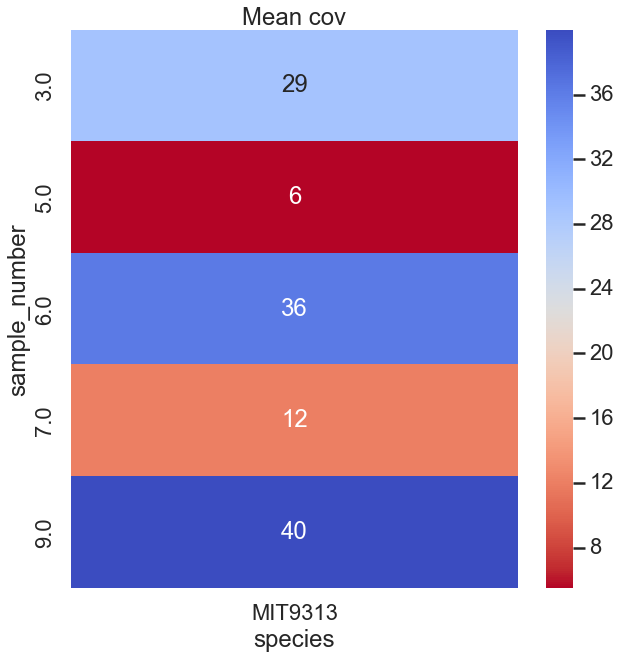

In [39]:
sns.set_context('poster')
value_cols = [  '10_x_pc',
         'mean_coverage',
              #'mapped_reads'
             ]

for v in value_cols:
    # 'sample', 'PRO', 'ALT', 'exp',
    plt.figure(figsize=(10,10))
    
    bamqc_pdf = merged_stat_df.loc[merged_stat_df['species'].isin(['MIT9313'])].pivot_table(index='sample_number', columns=['species'], 
                           values=[v]).droplevel(level=0, axis='columns')
    #bamqc_pdf[pct_cols] = bamqc_pdf[pct_cols]/100
    #bamqc_pdf.rename(columns=qmap_titles, inplace=True)
    sns.heatmap(bamqc_pdf, cmap='coolwarm_r',
                  annot=True, fmt='.0f')
    plt.title(qmap_titles[v])
    plt.show()

In [40]:
merged_stat_df.columns.unique()

Index(['10_x_pc', '1_x_pc', '30_x_pc', '50_x_pc', '5_x_pc', 'ALT',
       'Change_rate', 'DOWNSTREAM', 'DOWNSTREAM_percent', 'EXON',
       ...
       'stop_retained_variant_percent', 'surviving', 'surviving_pct',
       'synonymous_variant', 'synonymous_variant_percent', 'total_reads',
       'total_sequences', 'trim', 'upstream_gene_variant',
       'upstream_gene_variant_percent'],
      dtype='object', length=121)

In [41]:
#from glob import glob
#data_dpath = os.path.join('DNA','freebayes')
data_dpath = os.path.join('DNA','dnaseq_trimmed')
# ##INFO=<ID=ANN,Number=.,Type=String,
#Description="Functional annotations: 'Allele | Annotation | Annotation_Impact | 
#            Gene_Name | Gene_ID | Feature_Type | Feature_ID | Transcript_BioType | 
#              Rank | HGVS.c | HGVS.p | 
# cDNA.pos / cDNA.length | CDS.pos / CDS.length | AA.pos / AA.length | Distance | ERRORS / WARNINGS / INFO' ">
def _parse_csv(t):
    ANN_columns = [
        'Allele', 'Annotation',  'Impact', 'Gene_Name', 'Gene_ID', 'Feature_Type',
        'Feature_ID', 'Transcript_BioType', 'Rank', 'HGVS.c', 'HGVS.p', 'cDNA.pos',  'CDS.pos', 
        'AA.pos', 'Distance', 'ERRORS'
    ]
    #idx = 160000+i
    #dname = f'D20-{idx}-4500T'
    #glob(os.path.join(data_dpath, dname,'**', '*.csv'), recursive=True)
    fpath = os.path.join(data_dpath, #f'freebayes_{t}',
                         f'freebayes_{t}.tab')
    df =  pd.read_csv(fpath, sep='\t') 
    df['species'] = t
    df.ANN = df.ANN.str.split(',')
    df = df.apply( pd.Series.explode )


    df[ANN_columns] = df['ANN'].str.split('|', expand=True)
    df = df.drop('ANN', axis=1)
    return df

df_MIT9313 = _parse_csv('MIT9313') 
df_MIT0604 = _parse_csv('MIT0604') 
df_DE = _parse_csv('DE') 
df_1A3 = _parse_csv('1A3') 


In [42]:
def parse_freebayes(genome):
    df_s =  _parse_csv(genome) 
    id_vars=['CHROM', 'POS', 'TYPE', 'REF', 'ALT', 
       'species', 'Allele', 'Annotation', 'Impact', 'Gene_Name', 'Gene_ID',
       'Feature_Type', 'Feature_ID', 'Transcript_BioType', 'Rank', 'HGVS.c',
       'HGVS.p', 'cDNA.pos', 'CDS.pos', 'AA.pos', 'Distance', 'ERRORS']


    d = df_s.melt(id_vars=id_vars)
    d['variable'] = d['variable'].str.replace('D20-1600', '')
    d[['sample_number', 'variable']] = d['variable'].str.split('.',expand=True)
    d['sample_number'] = pd.to_numeric(d['sample_number'])

    pdf = d.pivot_table(index=(id_vars+['sample_number']), columns=['variable'], aggfunc='first', #values='value',
                   ).droplevel(level=0, axis='columns').reset_index() 
    
    pdf['good_call'] = (pdf.DP > 10) & (pdf.GQ > 20)
    mask = (~pdf.AO.astype(str).str.contains(',', na=False, regex=False) & 
            ~pdf.DP.astype(str).str.contains(',', na=False, regex=False) &
            (pdf['DP'] != 0) & pdf['good_call'])
    try: 
        pdf.loc[mask, 'fraction_Alt'] = pdf.loc[mask, 'AO'] / pdf.loc[mask, 'DP']
    except Exception:
        pdf['fraction_Alt'] = ''

    
    pdf['culture'] = 'Co_Culture'
    pdf.loc[pdf['sample_number']<=4, 'culture'] = 'Axenic'
    
    df_genome = pd.read_feather(os.path.join('DNA', 'genomes',f'{genome}.ncbi.gb.feather.gz'))
    #df_DE_MIT9313 = pd.read_excel(os.path.join('DNA', 'genomes','41396_2016_BFismej201670_MOESM46_ESM.xlsx'),
    #                          sheet_name='9313+1A3')
    genome_cols = ['gene_id', 'pmt_id', 'type',  'strand', 
       'product', 'protein_id']
    mpdf = pd.merge(pdf, 
                    df_genome[genome_cols], left_on='Gene_Name', right_on='gene_id', 
                    how='left'
                   )
    #mpdf[['PMTID1', 'PMTID2']] = mpdf.pmt_id.str.split(',', expand=True)
    mpdf = pd.merge(mpdf, meta_df, on='sample_number', how='left')
    mpdf['good_call'] = (mpdf.DP > 10) & (mpdf.GQ > 20)
    mpdf.loc[mpdf.good_call & (mpdf.ALT_x == mpdf.GT), 'call'] = 1
    mpdf.loc[mpdf.good_call & (mpdf.REF == mpdf.GT), 'call'] = 0
    mpdf.loc[mpdf.good_call & (mpdf.REF != mpdf.GT) & (mpdf.ALT_x != mpdf.GT), 'call'] = -1
    return mpdf

In [43]:
genome='MIT9313'
df_genome = pd.read_feather(os.path.join('DNA', 'genomes',f'{genome}.ncbi.gb.feather.gz'))
df_genome.head()


C:\Users\wosnat\Anaconda3\lib\site-packages\pyarrow\pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


contig_id        gene_id            pmt_id type       location strand  \
0   MIT9313  AKG35_RS00005  PMT0001,PMT_0001  CDS  AKG35_RS00005      +   
1   MIT9313  AKG35_RS00010  PMT0002,PMT_0002  CDS  AKG35_RS00010      +   
2   MIT9313  AKG35_RS00015  PMT0003,PMT_0003  CDS  AKG35_RS00015      +   
3   MIT9313  AKG35_RS00020  PMT0004,PMT_0004  CDS  AKG35_RS00020      +   
4   MIT9313  AKG35_RS00025  PMT0005,PMT_0005  CDS  AKG35_RS00025      -   

   start  stop  left  right  \
0    173  1340   173   1340   
1   1343  2120  1343   2120   
2   2177  4562  2177   4562   
3   4621  6079  4621   6079   
4   6114  8604  6114   8604   

                                            function   genome  \
0                    DNA polymerase III subunit beta  MIT9313   
1                               hypothetical protein  MIT9313   
2  phosphoribosylformylglycinamidine synthase sub...  MIT9313   
3                     amidophosphoribosyltransferase  MIT9313   
4                      DNA topoisomerase 4 subunit A  MIT9313   

                   old_locus_tag  \
0  PMT0001,PMT_0001,RG24_RS00005   
1  PMT0002,PMT_0002,RG24_RS00010   
2  PMT0003,PMT_0003,RG24_RS00015   
3  PMT0004,PMT_0004,RG24_RS00020   
4  PMT0005,PMT_0005,RG24_RS00025   

                                             product db_xref      protein_id  \
0                    DNA polymerase III subunit beta          WP_011129380.1   
1                               hypothetical protein          WP_041384224.1   
2  phosphoribosylformylglycinamidine synthase sub...          WP_011129382.1   
3                     amidophosphoribosyltransferase          WP_011129383.1   
4                      DNA topoisomerase 4 subunit A          WP_011129384.1   

  figfam nucleotide_sequence  \
0                              
1                              
2                              
3                              
4                              

                                         aa_sequence  
0  MKLVCSQAELNTALQLVSRAVASRPTHPVLANVLLTADAGTDRLSL...  
1  MNLPDQILLSDLLHHRVRCDQGLDHGPGVLPWMHPPVHRLLGWVSR...  
2  MRVDYDVAAALRHEGLKPHDYDEICRRLQRAPNRVELGMFGVMWSE...  
3  MCGIVGIVSTALVNQQIYDSLLLLQHRGQDSTGIATMDGSVFHLHK...  
4  MAEERLQPIALHQEMQRSYLEYAMSVIVGRALPDARDGLKPVQRRI...

In [44]:
genome='MIT9313'
df_genome = pd.read_feather(os.path.join('DNA', 'genomes',f'{genome}.ncbi.gb.feather.gz'))
df_genome.columns

Index(['contig_id', 'gene_id', 'pmt_id', 'type', 'location', 'strand', 'start',
       'stop', 'left', 'right', 'function', 'genome', 'old_locus_tag',
       'product', 'db_xref', 'protein_id', 'figfam', 'nucleotide_sequence',
       'aa_sequence'],
      dtype='object')

In [45]:
dfs = dict()
for s in ['MIT0604', 'MIT9313', 'DE', '1A3']:
    dfs[s] = parse_freebayes(s)


In [46]:
df_DE_MIT9313 = pd.read_excel(os.path.join('DNA', 'genomes','41396_2016_BFismej201670_MOESM46_ESM.xlsx'),
                              sheet_name='9313+1A3')
df_DE_MIT9313.rename(columns={'log 2 fold change coculture/axenic' : 'log Fold Change'}, inplace=True)
de_cols = ['Synonym', 'q Value ', 'log Fold Change']
dfs['MIT9313'][['PMTID1', 'PMTID2']] = dfs['MIT9313'].pmt_id.str.split(',', expand=True)

dfs['MIT9313'] = pd.merge(dfs['MIT9313'], 
                df_DE_MIT9313[de_cols], left_on='PMTID1', right_on='Synonym', 
                how='left'
               )


In [47]:
all_cols = ['CHROM', 'POS', 'TYPE', 'REF', 'ALT_x', 'species', 'Allele',
       'Annotation', 'Impact', 'Gene_Name', 'Gene_ID', 'Feature_Type',
       'Feature_ID', 'Transcript_BioType', 'Rank', 'HGVS.c', 'HGVS.p',
       'cDNA.pos', 'CDS.pos', 'AA.pos', 'Distance', 'ERRORS', 'sample_number',
       'AO', 'DP', 'RO', 'fraction_Alt', 'culture', 'gene_id', 'pmt_id',
       'type', 'strand', 'product', 'pmt_id', 'PMTID2', 'Synonym', 'q Value ',
       'log Fold Change', 'sample', 'PRO', 'ALT_y', 'exp',
       'days', 'ng/ul', 'final volume']
 

index_cols = ['CHROM', 'POS', 'TYPE', 'REF', 'ALT_x', 'Annotation', 'Impact',
              'HGVS.p', 'HGVS.c', 'CDS.pos', 'AA.pos',
              'gene_id', 'pmt_id', 'type', 'strand', 'product']
additional_index_cols = ['q Value ', 'log Fold Change',]

column_cols = ['PRO', 'ALT_y', 'days','sample', ]
value_cols = ['call', 'fraction_Alt', 'DP', 'AO', 'RO','GQ','GT',  ]
species= 'MIT9313'


condition_format_cols = {
    'MIT9313' : ['T7:X10000', 'Y7:AC10000' ],
    'MIT0604' : ['R7:AD10000', 'AE7:AQ10000' ],
    '1A3' : ['R7:AB10000', 'AC7:AM10000' ],
    'DE' : ['R7:X20000', 'Y7:AE10000' ],
    
}  
fraction_cols = {
    'MIT9313' :  'Y:AC',
    'MIT0604' :  'AE:AQ',
    '1A3' : 'AC:AM' ,
    'DE' :  'Y:AE' ,
    
}  


#agg_f = lambda x : ' | '.join(x.unique())
with pd.ExcelWriter('var_calls_5x5_MIT9313.xlsx', engine='xlsxwriter') as writer:  
    workbook  = writer.book
    format1 = workbook.add_format({'num_format': '#,##0.00'})
    format2 = workbook.add_format({'num_format': '0%'})
    for species, col in zip(['MIT9313', 'MIT0604', '1A3', 'DE'], ['PRO', 'PRO', 'ALT_y', 'ALT_y']):
        actual_index_cols = index_cols
        if species == 'MIT9313':
            actual_index_cols = index_cols + additional_index_cols
        excel_pdf = dfs[species].loc[dfs[species]['type'].isin(['CDS'])].fillna('').pivot_table(
            index=actual_index_cols, columns=column_cols,
            aggfunc='first', margins=False, values=value_cols,
            fill_value='',
        ).reindex(columns=value_cols, level=0,
        ).reindex(columns=['Axenic', '1A3', 'DE'], level='ALT_y',
        ).reindex(columns=['Axenic', 'MIT9313', 'MIT0604'], level='PRO',).reset_index()
        excel_pdf = excel_pdf.loc[excel_pdf['call'].replace('',np.NaN).std(axis=1) != 0]
        sheetname = f'{species} calls'
        excel_pdf.to_excel(writer, sheet_name=sheetname)
        worksheet = writer.sheets[sheetname]
        worksheet.set_column(fraction_cols[species], None, format1)
        if species == 'MIT9313':
            worksheet.set_column('R:S', None, format1)
        worksheet.set_column('Q:Q', 30)  # Col 1 has format1.
        worksheet.set_column('G:G', 12)  # Col 1 has format1.
                
        worksheet.conditional_format(condition_format_cols[species][0], 
                                     {'type': '2_color_scale',                               
                                      'min_color': '#b7efcd', 
                                    #  'mid_color': 'yellow', 
                                      'max_color': '#ffbcbc'
                                     })
        worksheet.conditional_format(condition_format_cols[species][1],  
                                     {'type': '2_color_scale',                               
                                      'min_color': 'white', 
                                    #  'mid_color': 'yellow', 
                                      'max_color': '#f69e7b'
                                     })
        #worksheet.conditional_format(f'K1:L{bamqc_df.shape[0]+2}', {'type': 'data_bar', 'bar_color' : 'green'})


In [48]:
dfs[species].columns

Index(['CHROM', 'POS', 'TYPE', 'REF', 'ALT_x', 'species', 'Allele',
       'Annotation', 'Impact', 'Gene_Name', 'Gene_ID', 'Feature_Type',
       'Feature_ID', 'Transcript_BioType', 'Rank', 'HGVS.c', 'HGVS.p',
       'cDNA.pos', 'CDS.pos', 'AA.pos', 'Distance', 'ERRORS', 'sample_number',
       'AO', 'DP', 'GQ', 'GT', 'RO', 'good_call', 'fraction_Alt', 'culture',
       'gene_id', 'pmt_id', 'type', 'strand', 'product', 'protein_id',
       'sample', 'PRO', 'ALT_y', 'exp', 'days', 'ng/ul', 'final volume',
       'call'],
      dtype='object')

Text(0.5, 1.0, 'MIT9313 calls')

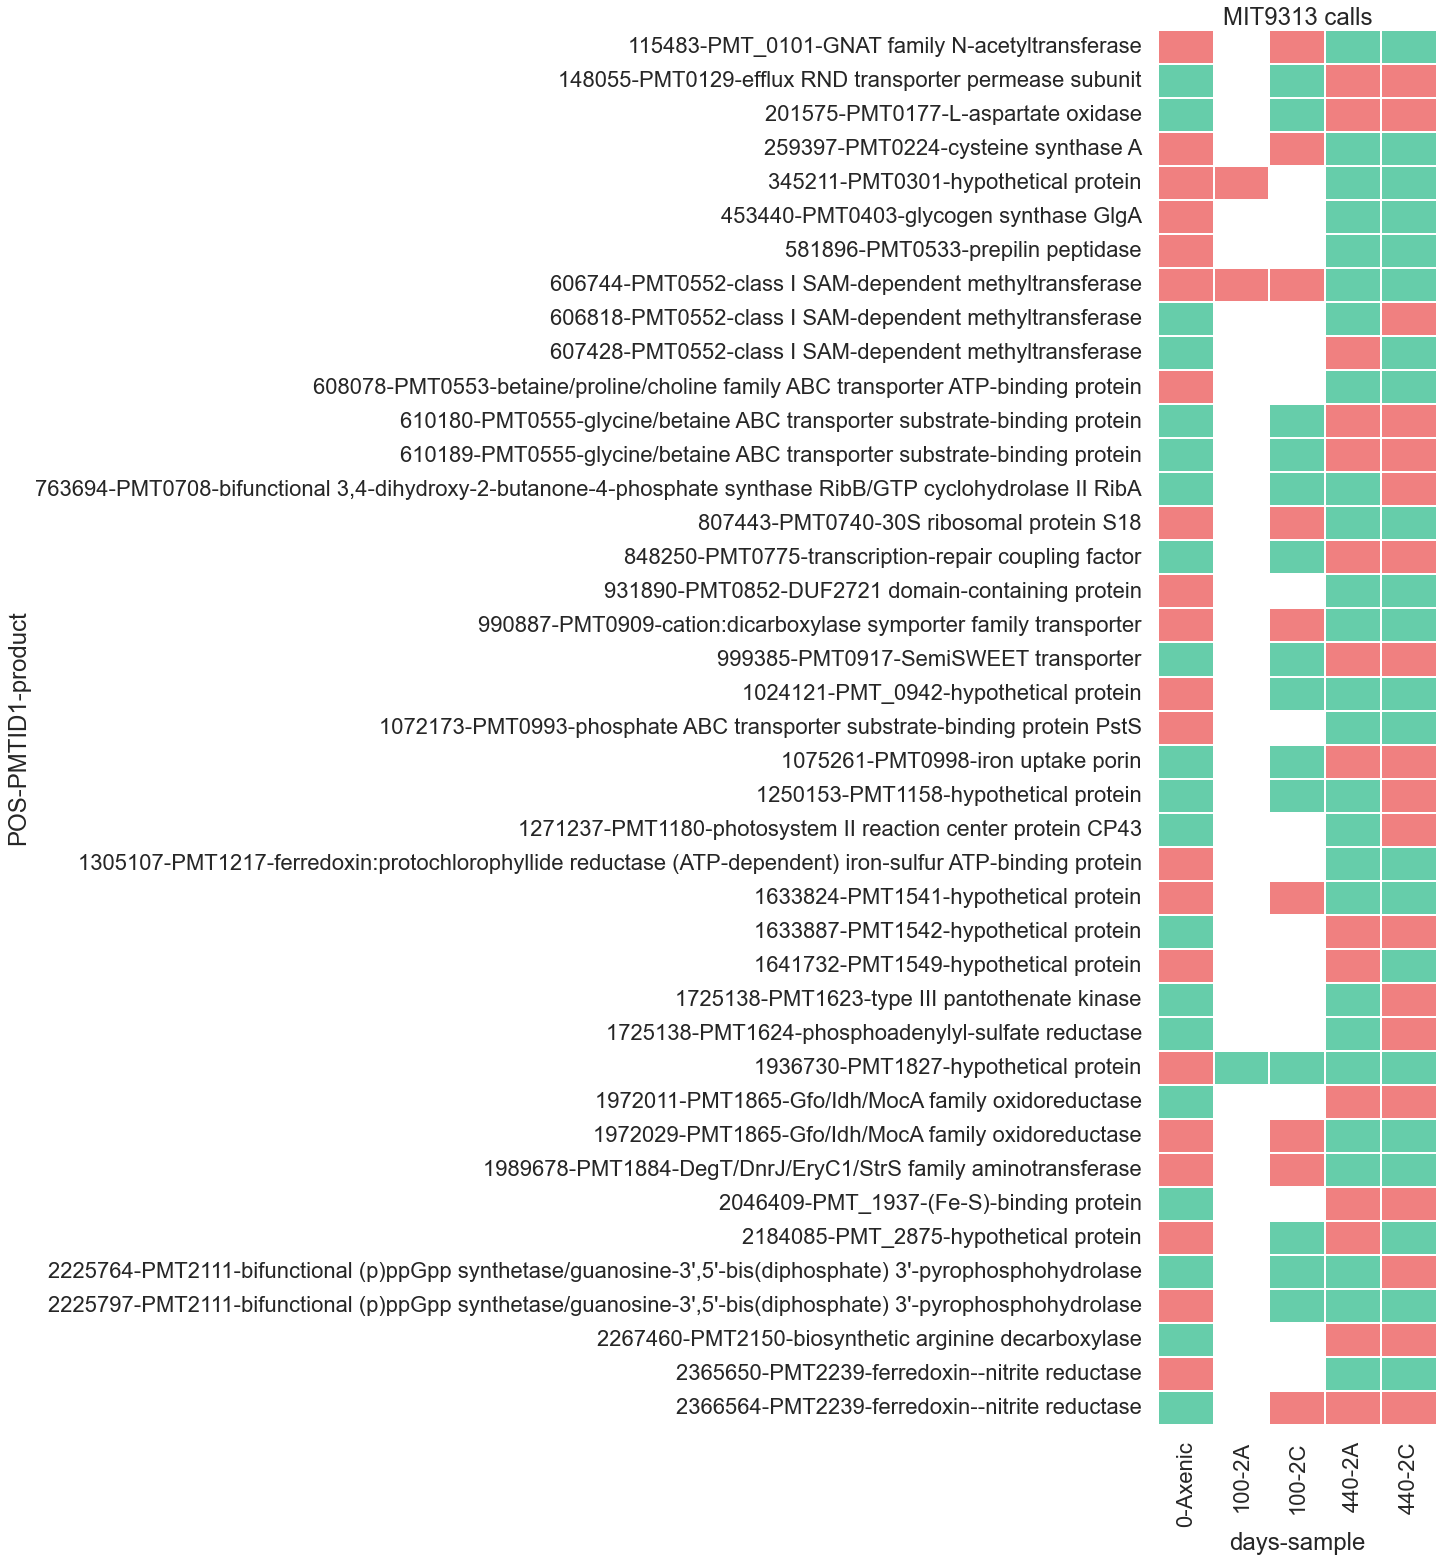

In [49]:
species = 'MIT9313'
plt.figure(figsize=(5,25))
pvdf = dfs[species].loc[dfs[species].type == 'CDS'].pivot_table(index=['POS', 'PMTID1', 'product',], 
                                                columns=[ 'days','sample',], values='call', aggfunc='first')
sns.heatmap(pvdf.loc[pvdf.std(axis=1) > 1e-1], #.sort_values((  0, 'Axenic')),
            cmap=['MediumAquamarine', 'lightcoral'],
            linewidths=1, linecolor='white', cbar=False)
plt.title(f'{species} calls')

In [50]:
species = 'MIT9313'
pvdf = dfs[species].loc[dfs[species].type == 'CDS'].pivot_table(index=['protein_id', 'gene_id', 'product'], 
                                                columns=[ 'days','sample',], values='call', aggfunc='first')
pvdf = pvdf.reset_index()
pvdf.loc[pvdf.std(axis=1) > 1e-1]
good_call_gene_ids = pvdf.loc[pvdf.std(axis=1) > 1e-1, 'gene_id']
dfs[species]['diff_snp'] = False
dfs[species].loc[dfs[species]['gene_id'].isin(good_call_gene_ids), 'diff_snp'] = True



In [51]:
'", "'.join(good_call_gene_ids)

'AKG35_RS12145", "AKG35_RS00645", "AKG35_RS00885", "AKG35_RS01190", "AKG35_RS01605", "AKG35_RS02150", "AKG35_RS02805", "AKG35_RS02910", "AKG35_RS03855", "AKG35_RS04035", "AKG35_RS04455", "AKG35_RS04770", "AKG35_RS04995", "AKG35_RS05290", "AKG35_RS05310", "AKG35_RS06205", "AKG35_RS06325", "AKG35_RS06510", "AKG35_RS08200", "AKG35_RS08205", "AKG35_RS08650", "AKG35_RS08655", "AKG35_RS09790", "AKG35_RS10080", "AKG35_RS12495", "AKG35_RS11235", "AKG35_RS11455", "AKG35_RS11935", "AKG35_RS09985", "AKG35_RS02915", "AKG35_RS03695", "AKG35_RS04825", "AKG35_RS11050", "AKG35_RS02925", "AKG35_RS08240'

In [52]:
dfs[species].head()

CHROM    POS   TYPE REF ALT_x  species Allele          Annotation  \
0  NC_005071  66297  INDEL  GC     G  MIT9313      G  frameshift_variant   
1  NC_005071  66297  INDEL  GC     G  MIT9313      G  frameshift_variant   
2  NC_005071  66297  INDEL  GC     G  MIT9313      G  frameshift_variant   
3  NC_005071  66297  INDEL  GC     G  MIT9313      G  frameshift_variant   
4  NC_005071  66297  INDEL  GC     G  MIT9313      G  frameshift_variant   

  Impact      Gene_Name  ...   days  ng/ul final volume call   PMTID1  \
0   HIGH  AKG35_RS00340  ...      0      1          100    1  PMT0064   
1   HIGH  AKG35_RS00340  ...    100      1          100  nan  PMT0064   
2   HIGH  AKG35_RS00340  ...    440      1          100    1  PMT0064   
3   HIGH  AKG35_RS00340  ...    100      2          100  nan  PMT0064   
4   HIGH  AKG35_RS00340  ...  empty  empty        empty  nan  PMT0064   

     PMTID2  Synonym q Value  log Fold Change diff_snp  
0  PMT_0064  PMT0064        1              -1    False  
1  PMT_0064  PMT0064        1              -1    False  
2  PMT_0064  PMT0064        1              -1    False  
3  PMT_0064  PMT0064        1              -1    False  
4  PMT_0064  PMT0064        1              -1    False  

[5 rows x 51 columns]

Text(0.5, 1.0, 'MIT0604 calls')

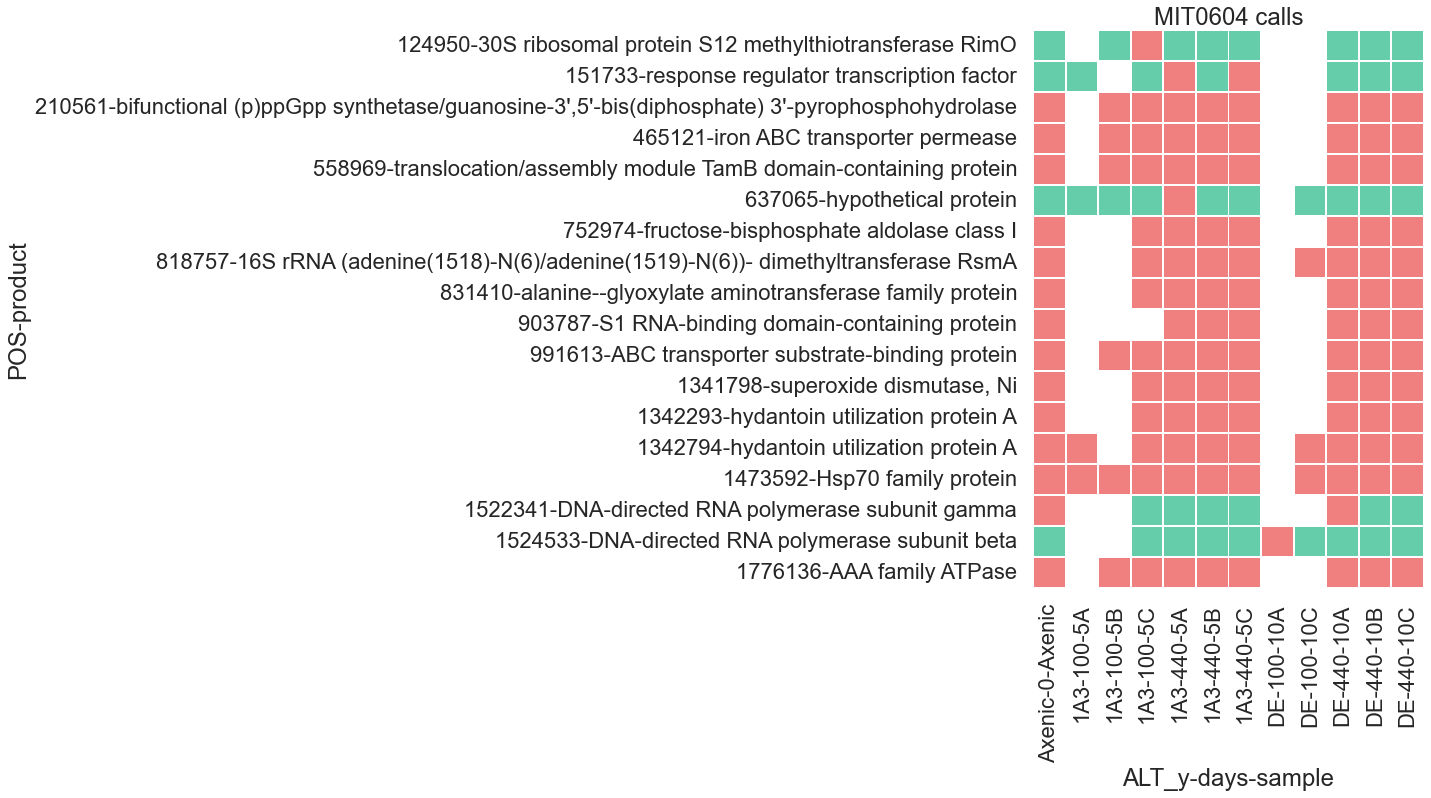

In [53]:
species = 'MIT0604'
plt.figure(figsize=(7,10))
pvdf = dfs[species].loc[dfs[species].type == 'CDS'].pivot_table(index=[ 'POS', 'product',], 
                                                columns=[ 'ALT_y', 'days','sample'], 
                                                                values='call', aggfunc='first')
pvdf = pvdf.reindex(columns=['Axenic', '1A3', 'DE'], level='ALT_y',)
sns.heatmap(pvdf, #.loc[pvdf.std(axis=1) > 1e-1], #.sort_values(( 0, 'Axenic','Axenic', )),
            cmap=['MediumAquamarine', 'lightcoral'],
            linewidths=1, linecolor='white', cbar=False)
plt.title(f'{species} calls')

Text(0.5, 1.0, 'MIT0604 calls')

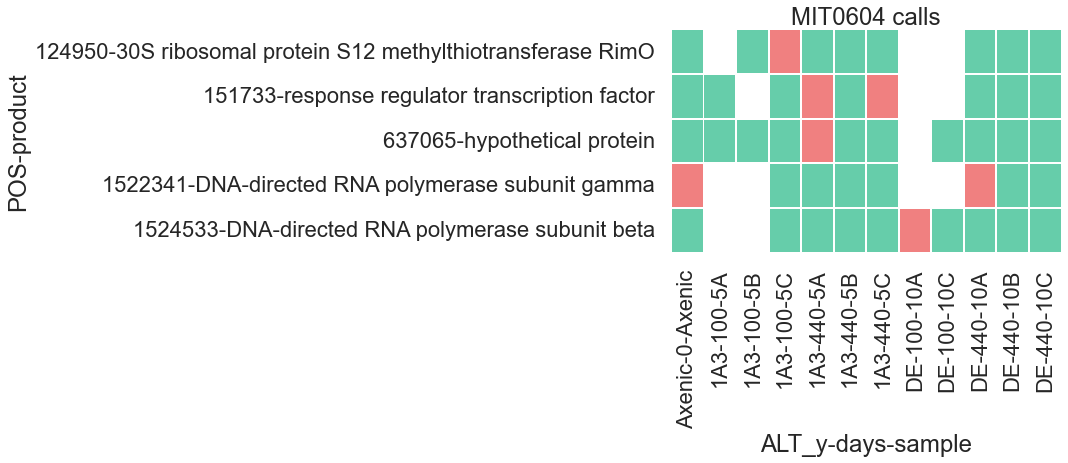

In [54]:
species = 'MIT0604'
plt.figure(figsize=(7,4))
pvdf = dfs[species].loc[dfs[species].type == 'CDS'].pivot_table(index=[ 'POS','product',], 
                                                columns=[ 'ALT_y', 'days','sample'], 
                                                                values='call', aggfunc='first')
pvdf = pvdf.reindex(columns=['Axenic', '1A3', 'DE'], level='ALT_y',)
sns.heatmap(pvdf.loc[pvdf.std(axis=1) > 1e-1], #.sort_values(( 0, 'Axenic','Axenic', )),
            cmap=['MediumAquamarine', 'lightcoral'],
            linewidths=1, linecolor='white', cbar=False)
plt.title(f'{species} calls')

In [55]:
species = 'MIT9313'
dfs[species].loc[(dfs[species].type == 'CDS') & (dfs[species].good_call)].Gene_Name.nunique()

67

Text(0.5, 1.0, 'Fraction of Alternate Allele')

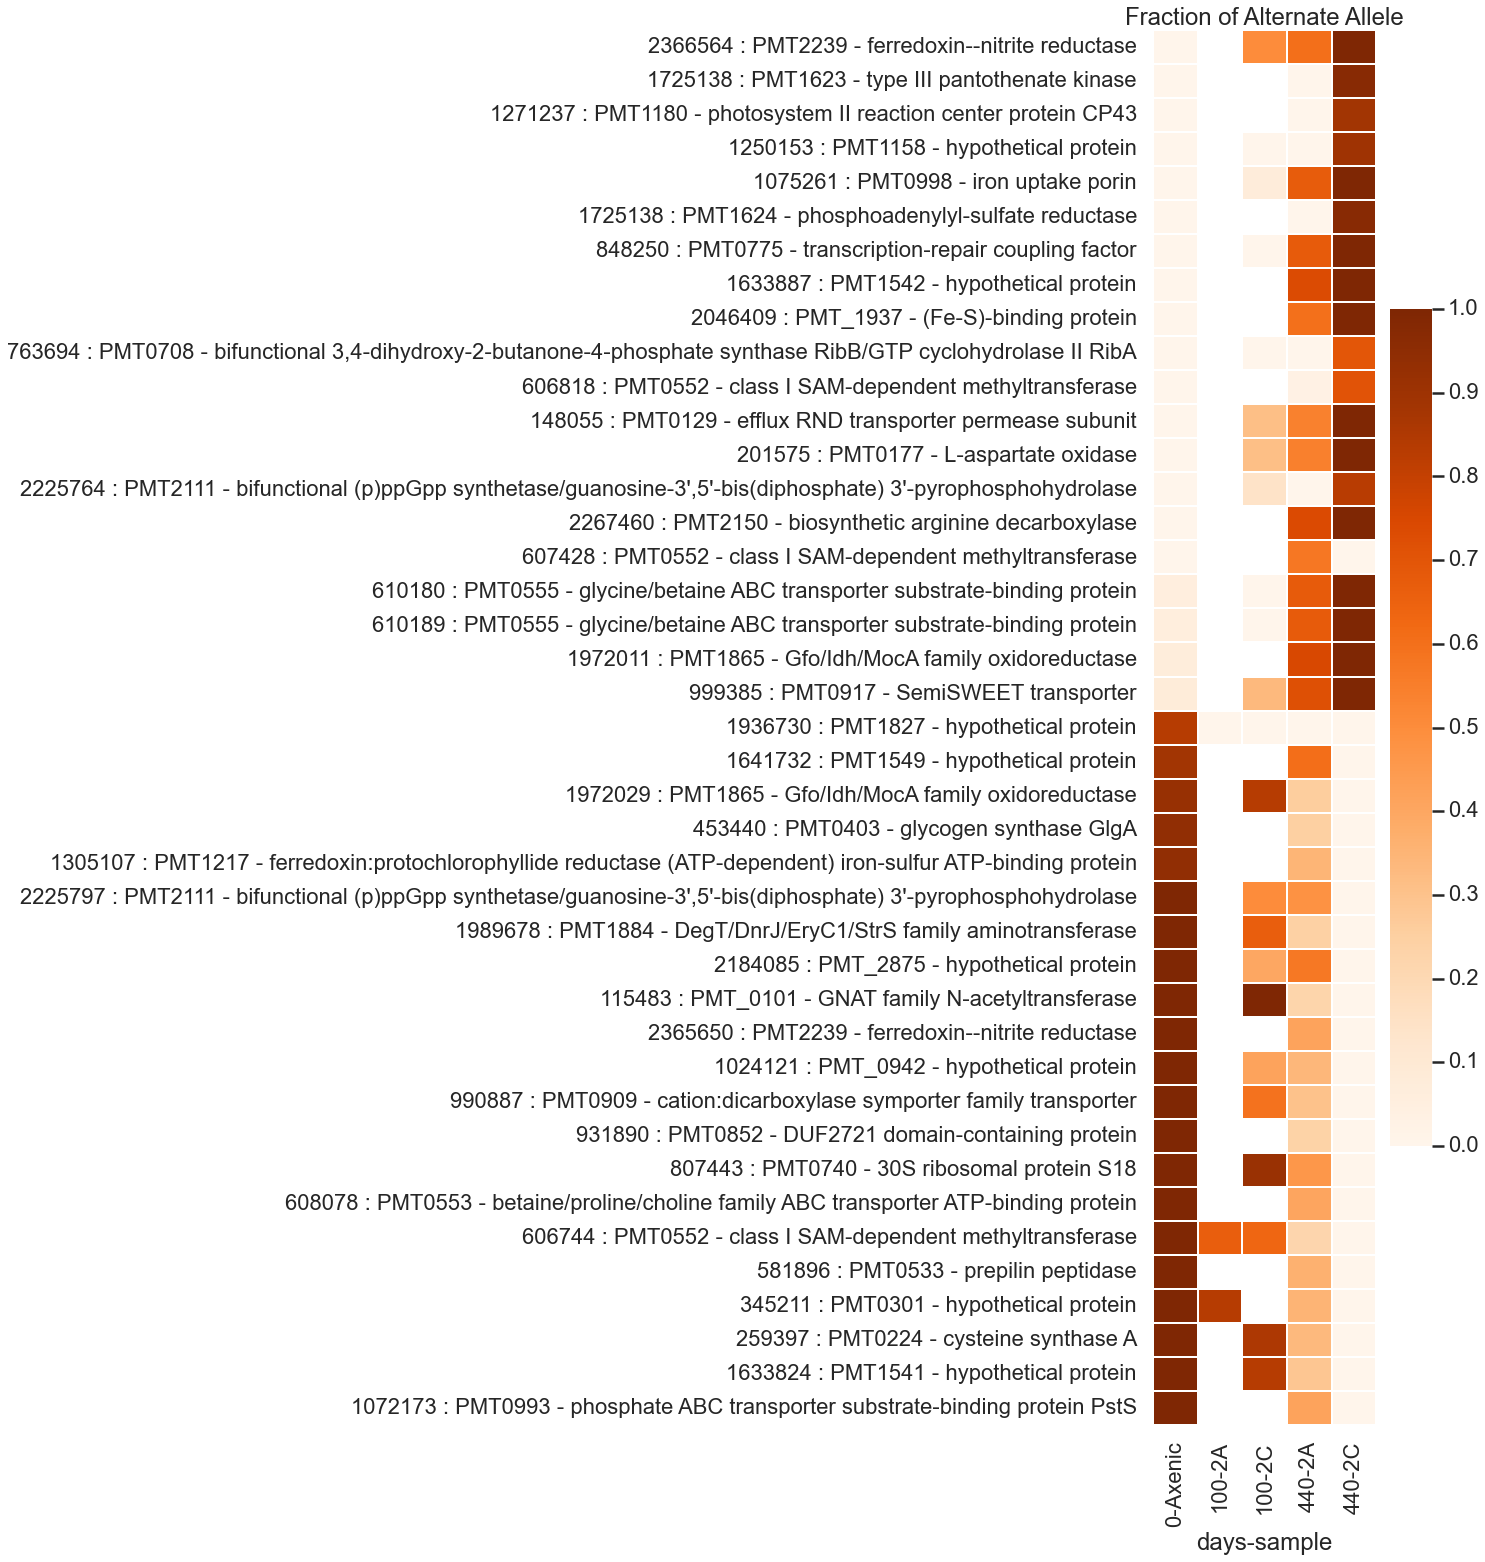

In [56]:
species = 'MIT9313'
plt.figure(figsize=(5,25))
pvdf = dfs[species].loc[(dfs[species].type == 'CDS') & (dfs[species].good_call)
               ].pivot_table(index=[ 'POS', 'PMTID1', 'product',], 
                                                columns=[ 'days','sample',], values='fraction_Alt', aggfunc='first')
pvdf.index = [f'{col[0]} : {col[1]} - {col[2]}' for col in pvdf.index.values]
sns.heatmap(pvdf.loc[pvdf.std(axis=1) > 1e-1].sort_values((  0, 'Axenic')),
            cmap='Oranges',
            linewidths=1, linecolor='white', #cbar=False
           )
plt.title('Fraction of Alternate Allele')

Text(0.5, 1.0, 'MIT0604: fraction of Alternate Allele')

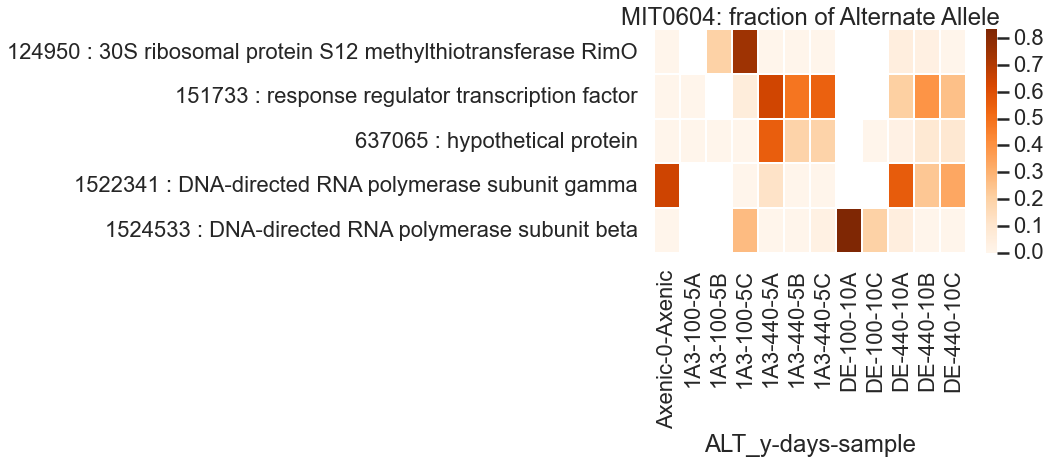

In [57]:
species = 'MIT0604'
plt.figure(figsize=(7,4))
pvdf = dfs[species].loc[(dfs[species].type == 'CDS') & (dfs[species].good_call)
               ].pivot_table(index=[ 'POS', 'product',], 
                                                columns=[ 'ALT_y', 'days','sample',], values='fraction_Alt', aggfunc='first')
pvdf = pvdf.reindex(columns=['Axenic', '1A3', 'DE'], level='ALT_y',)
pvdf.index = [f'{col[0]} : {col[1]}' for col in pvdf.index.values]
sns.heatmap(pvdf.loc[pvdf.std(axis=1) > 1e-1], #.sort_values((  0, 'Axenic')),
            cmap='Oranges',
            linewidths=1, linecolor='white', #cbar=False
           )
plt.title(f'{species}: fraction of Alternate Allele')

Text(0.5, 1.0, 'MIT0604: fraction of Alternate Allele')

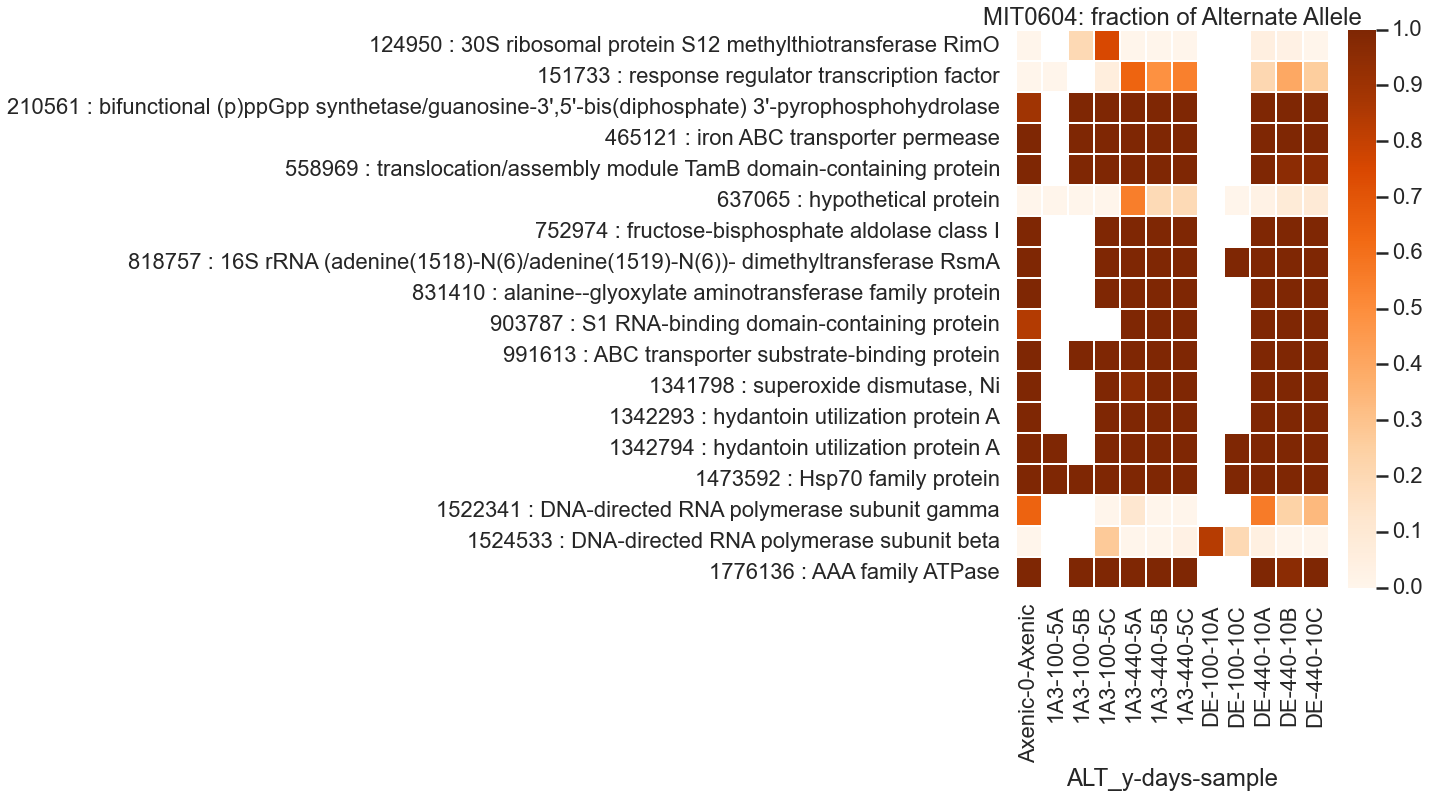

In [58]:
species = 'MIT0604'
plt.figure(figsize=(7,10))
pvdf = dfs[species].loc[(dfs[species].type == 'CDS') & 
                         dfs[species].good_call & 
                        (dfs[species].PRO == species)
               ].pivot_table(index=[ 'POS', 'product',], 
                             columns=[ 'ALT_y', 'days','sample',], 
                             values='fraction_Alt', aggfunc='first', #dropna=False
                            )
pvdf = pvdf.reindex(columns=['Axenic', '1A3', 'DE'], level='ALT_y',)
pvdf.index = [f'{col[0]} : {col[1]}' for col in pvdf.index.values]
sns.heatmap(pvdf, #.loc[pvdf.std(axis=1) > 1e-1], #.sort_values((  0, 'Axenic')),
            cmap='Oranges',
            linewidths=1, linecolor='white', #cbar=False
           )
plt.title(f'{species}: fraction of Alternate Allele')

In [59]:
pvdf.head()

ALT_y                                              Axenic 1A3                \
days                                                  0   100        440      
sample                                             Axenic  5A  5B 5C  5A 5B   
124950 : 30S ribosomal protein S12 methylthiotr...      0 nan   0  1   0  0   
151733 : response regulator transcription factor        0   0 nan  0   1  0   
210561 : bifunctional (p)ppGpp synthetase/guano...      1 nan   1  1   1  1   
465121 : iron ABC transporter permease                  1 nan   1  1   1  1   
558969 : translocation/assembly module TamB dom...      1 nan   1  1   1  1   

ALT_y                                                  DE                  
days                                                  100     440          
sample                                             5C 10A 10C 10A 10B 10C  
124950 : 30S ribosomal protein S12 methylthiotr...  0 nan nan   0   0   0  
151733 : response regulator transcription factor    1 nan nan   0   0   0  
210561 : bifunctional (p)ppGpp synthetase/guano...  1 nan nan   1   1   1  
465121 : iron ABC transporter permease              1 nan nan   1   1   1  
558969 : translocation/assembly module TamB dom...  1 nan nan   1   1   1

In [60]:
import urllib.parse
import urllib.request
import io

import requests, sys
# go terms for all mit9313 genes
url = 'https://www.uniprot.org/uniprot/'
columns =  ['id','entry name','protein names','genes','organism','length',
            'go(biological process)','go(cellular component)',
    'go(molecular function)']

params = {
    'query' : 'taxonomy:74547',
    'format' : 'tab',
    'columns' : ','.join(columns),
    'compress' : 'no',
}

data = urllib.parse.urlencode(params)
data = data.encode('utf-8')
req = urllib.request.Request(url, data)
with urllib.request.urlopen(req) as f:
   response = f.read()
mit9313_go_df1 = pd.read_csv(io.StringIO(response.decode('utf-8')), sep='\t')



In [61]:
mit9313_go_df1.shape

(2834, 9)

In [62]:
mmit9313_go_df1 = mit9313_go_df1.melt(
    id_vars=['Entry', 'Entry name', 'Protein names', 'Gene names', 'Organism', 'Length'],
    value_name='GO term',
    var_name='GO aspect',
).dropna(subset=['GO term'],axis=0).reset_index(drop=True)

In [63]:
s = mmit9313_go_df1['GO term'].str.split('; ', expand=True).stack()
i = s.index.get_level_values(0)
df3 = mmit9313_go_df1.loc[i].copy()
df3["GO term"] = s.values
df3[["GO term", 'GOid']] = df3["GO term"].str.split(r' \[G', expand=True)
df3['GOid'] = df3['GOid'].str.replace(']', '')
df3['GOid'] = df3['GOid'].str.replace('O:', 'GO:')

In [64]:
all_go_df = df3

In [65]:
species = 'MIT9313'
pvdf = dfs[species].loc[dfs[species].type == 'CDS'].pivot_table(index=['protein_id', 'gene_id', 'product'], 
                                                columns=[ 'days','sample',], values='call', aggfunc='first')
pvdf = pvdf.reset_index()
pvdf['actual_snp'] = pvdf.std(axis=1) > 1e-1


In [66]:
dfs[species].POS.value_counts()
#dfs[species].head().T
#dfs[species].columns
dfs[species].loc[dfs[species].POS==685346     ]

CHROM     POS TYPE REF ALT_x  species Allele          Annotation  \
510  NC_005071  685346  SNP   N     G  MIT9313      G  intragenic_variant   
511  NC_005071  685346  SNP   N     G  MIT9313      G  intragenic_variant   
512  NC_005071  685346  SNP   N     G  MIT9313      G  intragenic_variant   
513  NC_005071  685346  SNP   N     G  MIT9313      G  intragenic_variant   
514  NC_005071  685346  SNP   N     G  MIT9313      G  intragenic_variant   
515  NC_005071  685346  SNP   N     G  MIT9313      G  intragenic_variant   
516  NC_005071  685346  SNP   N     G  MIT9313      G  intragenic_variant   
517  NC_005071  685346  SNP   N     G  MIT9313      G  intragenic_variant   
518  NC_005071  685346  SNP   N     G  MIT9313      G  intragenic_variant   
519  NC_005071  685346  SNP   N     G  MIT9313      G  intragenic_variant   
520  NC_005071  685346  SNP   N     G  MIT9313      G  intragenic_variant   
521  NC_005071  685346  SNP   N     G  MIT9313      G  intragenic_variant   
522  NC_005071  685346  SNP   N     G  MIT9313      G  intragenic_variant   
523  NC_005071  685346  SNP   N     G  MIT9313      G  intragenic_variant   
524  NC_005071  685346  SNP   N     G  MIT9313      G  intragenic_variant   
525  NC_005071  685346  SNP   N     G  MIT9313      G  intragenic_variant   
526  NC_005071  685346  SNP   N     G  MIT9313      G  intragenic_variant   
527  NC_005071  685346  SNP   N     G  MIT9313      G  intragenic_variant   
528  NC_005071  685346  SNP   N     G  MIT9313      G  intragenic_variant   
529  NC_005071  685346  SNP   N     G  MIT9313      G  intragenic_variant   
530  NC_005071  685346  SNP   N     G  MIT9313      G  intragenic_variant   
531  NC_005071  685346  SNP   N     G  MIT9313      G  intragenic_variant   
532  NC_005071  685346  SNP   N     G  MIT9313      G  intragenic_variant   
533  NC_005071  685346  SNP   N     G  MIT9313      G  intragenic_variant   
534  NC_005071  685346  SNP   N     G  MIT9313      G  intragenic_variant   
535  NC_005071  685346  SNP   N     G  MIT9313      G  intragenic_variant   
536  NC_005071  685346  SNP   N     G  MIT9313      G  intragenic_variant   
537  NC_005071  685346  SNP   N     G  MIT9313      G  intragenic_variant   
538  NC_005071  685346  SNP   N     G  MIT9313      G  intragenic_variant   
539  NC_005071  685346  SNP   N     G  MIT9313      G  intragenic_variant   
540  NC_005071  685346  SNP   N     G  MIT9313      G  intragenic_variant   
541  NC_005071  685346  SNP   N     G  MIT9313      G  intragenic_variant   
542  NC_005071  685346  SNP   N     G  MIT9313      G  intragenic_variant   
543  NC_005071  685346  SNP   N     G  MIT9313      G  intragenic_variant   
544  NC_005071  685346  SNP   N     G  MIT9313      G  intragenic_variant   
545  NC_005071  685346  SNP   N     G  MIT9313      G  intragenic_variant   

       Impact      Gene_Name  ...   days  ng/ul final volume call      PMTID1  \
510  MODIFIER  AKG35_RS00225  ...      0      1          100    1  PMT_RNA_44   
511  MODIFIER  AKG35_RS00225  ...    100      1          100  nan  PMT_RNA_44   
512  MODIFIER  AKG35_RS00225  ...    440      1          100    1  PMT_RNA_44   
513  MODIFIER  AKG35_RS00225  ...    100      2          100    1  PMT_RNA_44   
514  MODIFIER  AKG35_RS00225  ...  empty  empty        empty  nan  PMT_RNA_44   
515  MODIFIER  AKG35_RS00225  ...    440      8          100    1  PMT_RNA_44   
516  MODIFIER  AKG35_RS00225  ...      0      1          100    1  PMT_RNA_44   
517  MODIFIER  AKG35_RS00225  ...    100      1          100  nan  PMT_RNA_44   
518  MODIFIER  AKG35_RS00225  ...    440      1          100    1  PMT_RNA_44   
519  MODIFIER  AKG35_RS00225  ...    100      2          100    1  PMT_RNA_44   
520  MODIFIER  AKG35_RS00225  ...  empty  empty        empty  nan  PMT_RNA_44   
521  MODIFIER  AKG35_RS00225  ...    440      8          100    1  PMT_RNA_44   
522  MODIFIER  AKG35_RS00225  ...      0      1          100    1  PMT_RNA_44   
523  MODIFIER  AKG35_RS00

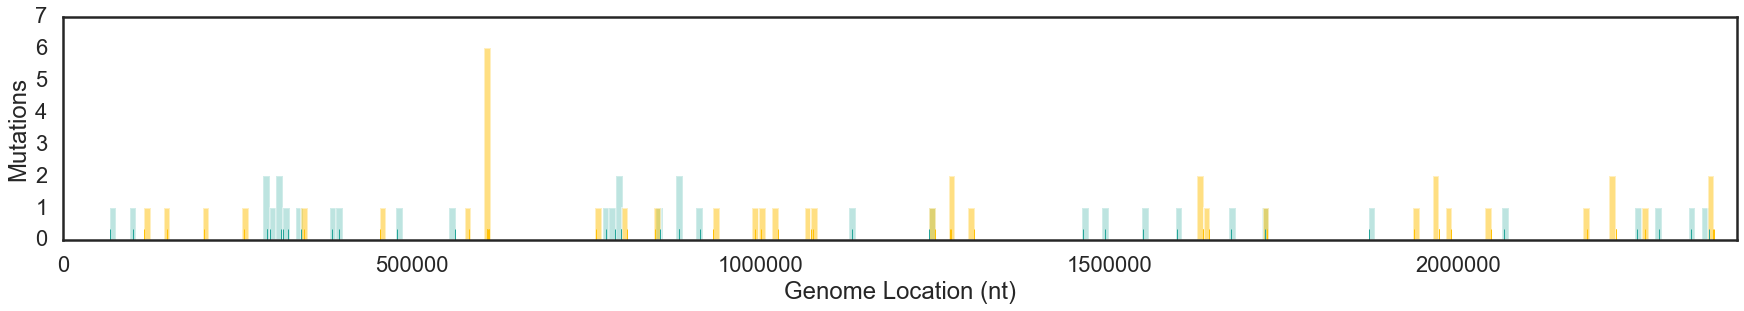

In [67]:
species = 'MIT9313'
t = dfs[species]
t = t.loc[t.type.isin(['CDS'])].groupby(['POS', 'TYPE', 'diff_snp'])['call'].first().reset_index()
t1= t.loc[~t.diff_snp]
t2= t.loc[t.diff_snp]
plt.figure(figsize=(30,4))


sns.distplot(t1['POS'], kde=False, bins=240, hist_kws=dict(alpha=0.3), rug=True, color='#26A69A', label='unchanged mutations')
sns.distplot(t2['POS'], kde=False, bins=240, hist_kws=dict(alpha=0.5), rug=True,
             color='#FFC107', #rug_kws=dict(height=1/3), 
             label='New Mutations')

#sns.rugplot(t.POS, height=0.1)
#sns.rugplot(t2.POS, height=0.5, color='Orange')
#sns.scatterplot(x=t2.POS, y=7/3, s=400, color='#FFA000', alpha=0.25,#hue=t2.Annotation, 
                #markeredgecolor ='r',#palette='range', hue=1
                #markerfacecolors='none'
#               )
glicine_region = (605826, 610831)
#plt.plot(glicine_region[0],10, glicine_region[1],10, marker='o',color='green' )
plt.ylim(0,7)
plt.xlabel('Genome Location (nt)')
plt.ylabel('Mutations')
plt.xlim(0,2.4e6)
#plt.yticks([])
plt.show()


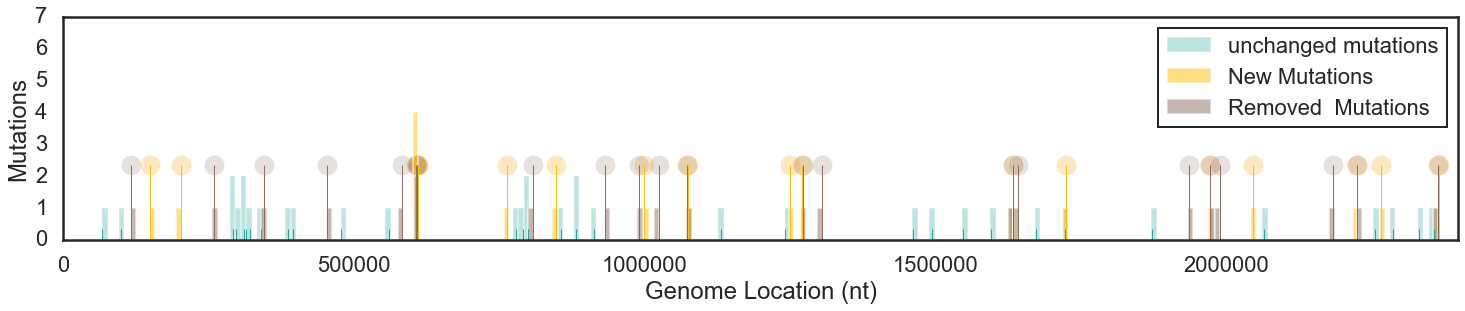

In [68]:
species = 'MIT9313'
t = dfs[species]
t = t.loc[t.type.isin(['CDS'])].groupby(['POS', 'TYPE', 'diff_snp', 'days'])['call'].first().reset_index()
t = t.loc[t.days == 0]

t1= t.loc[~t.diff_snp]
t2= t.loc[t.diff_snp & (t.call == 0)]
t3= t.loc[t.diff_snp & (t.call == 1)]
plt.figure(figsize=(25,4))


sns.distplot(t1['POS'], kde=False, bins=240, hist_kws=dict(alpha=0.3), rug=True, color='#26A69A', label='unchanged mutations')
sns.distplot(t2['POS'], kde=False, bins=240, hist_kws=dict(alpha=0.5), rug=True,
             color='#FFC107', rug_kws=dict(height=1/3), label='New Mutations')
sns.distplot(t3['POS'], kde=False, bins=240, hist_kws=dict(alpha=0.5), rug=True,
             color='#8D6E63', rug_kws=dict(height=1/3), label='Removed  Mutations')

#sns.rugplot(t.POS, height=0.1)
#sns.rugplot(t2.POS, height=0.5, color='Orange')
sns.scatterplot(x=t2.POS, y=7/3, s=400, color='#FFA000', alpha=0.25)
sns.scatterplot(x=t3.POS, y=7/3, s=400, color='#A1887F', alpha=0.25)

glicine_region = (605826, 610831)
#plt.plot(glicine_region[0],10, glicine_region[1],10, marker='o',color='green' )
plt.ylim(0,7)
plt.xlabel('Genome Location (nt)')
plt.ylabel('Mutations')
plt.xlim(0,2.4e6)
#plt.yticks([])
plt.show()


(0.0, 2400000.0)

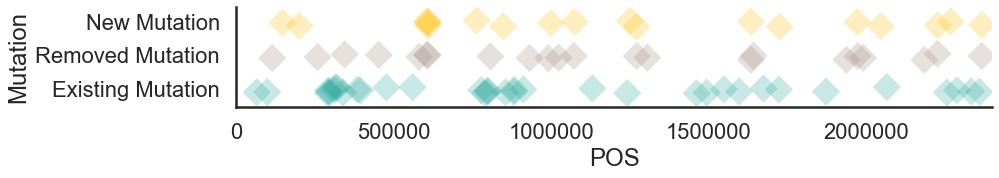

In [69]:
species = 'MIT9313'
t = dfs[species]
t = t.loc[t.type.isin(['CDS'])].groupby(['POS', 'TYPE', 'diff_snp', 'days'])['call'].first().reset_index()
t = t.loc[t.days == 0]

t.loc[~t.diff_snp, 'Mutation'] = 'Existing Mutation'
t.loc[t.diff_snp & (t.call == 0), 'Mutation'] = 'New Mutation'
t.loc[t.diff_snp & (t.call == 1), 'Mutation'] = 'Removed Mutation'

sns.catplot(data=t, y='Mutation', x='POS', aspect=5, kind='strip', height=3, 
            order=['New Mutation','Removed Mutation', 'Existing Mutation',], 
            palette=[ '#FFC107', '#A1887F', '#26A69A',],
            s=20, marker="D",
            edgecolor="gray", alpha=.25)
plt.xlim(0,2.4e6)

In [70]:
df_genome.type.value_counts()

CDS           2403
tRNA            44
rRNA             6
ncRNA            3
regulatory       2
tmRNA            1
Name: type, dtype: int64

In [71]:
species = 'MIT9313'
t = dfs[species]
t.loc[t.type.isin(['CDS'])].groupby(['POS', 'TYPE', 'diff_snp'])['call'].first().reset_index().diff_snp.value_counts()


True     41
False    35
Name: diff_snp, dtype: int64

In [72]:
number_of_mit9313_cds = 2403
number_of_read_mutations = 41
from scipy.stats import binom 
n = number_of_mit9313_cds
r = number_of_read_mutations
p = 1-1/n
#res = [binom.pmf(k=r, n=n, p=p) for r in range(50)]
#sns.lineplot(x=range(50), y=res)
1 - np.exp(-r*(r-1)/(2*n)) , 1 - ((n - 1)/n)**r

(0.2891118082881201, 0.016920765161884233)

Text(0, 0.5, 'probability of 2 mutations on the same gene')

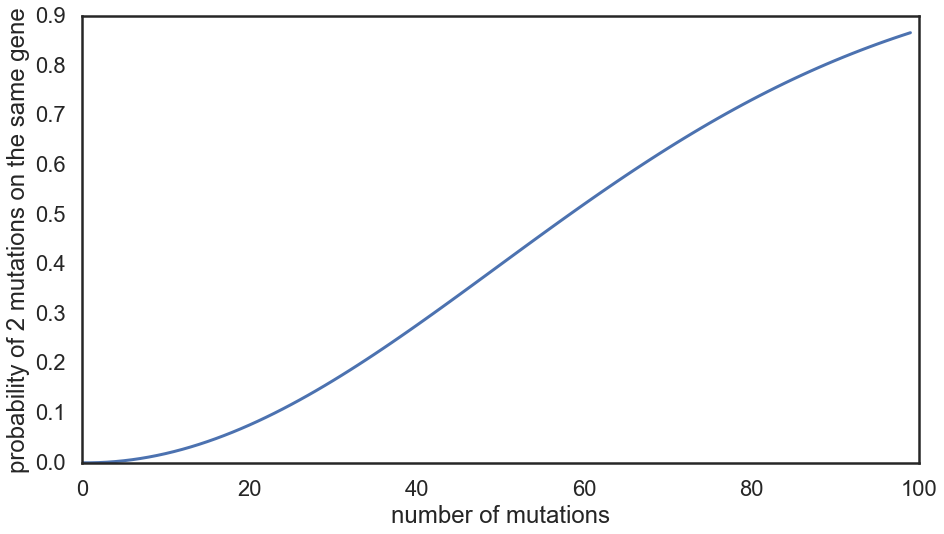

In [73]:
number_of_mit9313_cds = 2403
number_of_read_mutations = 41
from scipy.stats import binom 
n = number_of_mit9313_cds
r = number_of_read_mutations
p = 1-1/n
res = [1 - np.exp(-r*(r-1)/(2*n)) for r in range(100)]
sns.lineplot(x=range(100), y=res)
#1 - np.exp(-r*(r-1)/(2*n)) , np.sqrt(2*n*np.log(1/(1-1/n)))
plt.xlabel('number of mutations')
plt.ylabel('probability of 2 mutations on the same gene')

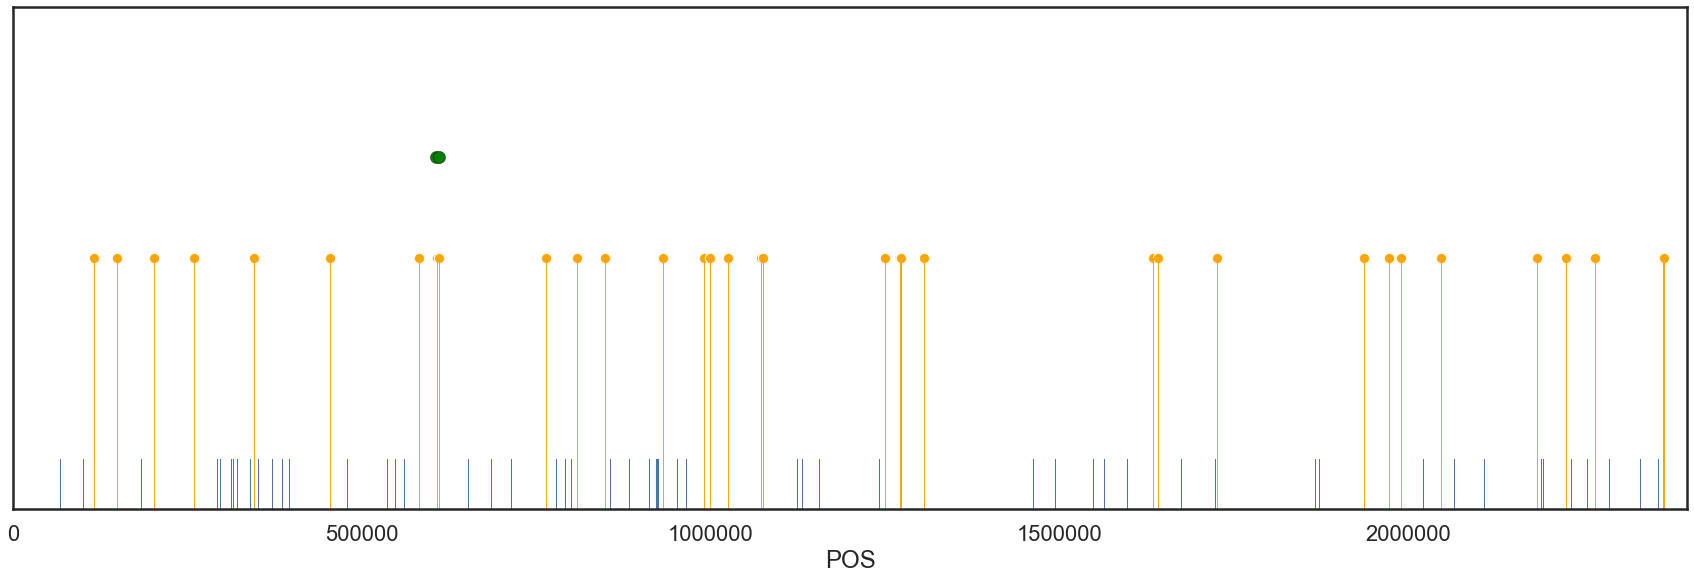

In [74]:
species = 'MIT9313'
t = dfs[species]
t2= t.loc[t.diff_snp]
plt.figure(figsize=(30,9))

#sns.distplot(t['POS'], kde=False, bins=240, hist_kws=dict(alpha=0.3))

sns.rugplot(t.POS, height=0.1)
sns.rugplot(t2.POS, height=0.5, color='Orange')
sns.scatterplot(x=t2.POS, y=0.5, s=100, #hue=t2.Annotation, 
                color='orange'#palette='range', hue=1
               )
glicine_region = (605826, 610831)
plt.plot(glicine_region[0],0.7, glicine_region[1],0.7, marker='o',color='green' 
        )
plt.ylim(0,1)
plt.xlim(0,2.4e6)
plt.yticks([])
plt.show()


In [75]:
2.4e6/240


10000.0

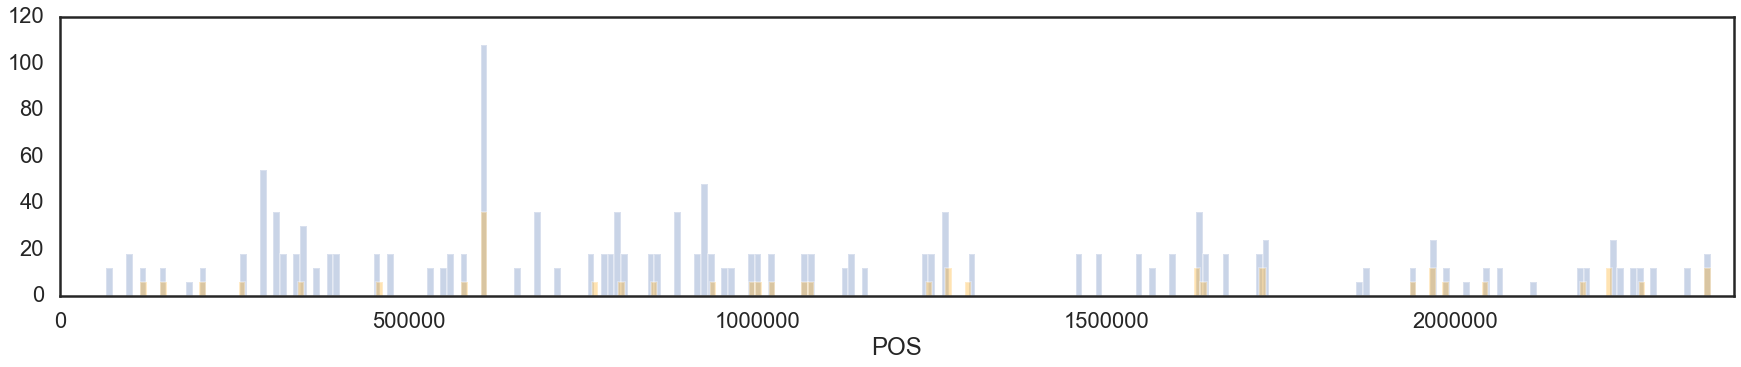

In [76]:
t = dfs[species]
t2= t.loc[t.diff_snp]
plt.figure(figsize=(30,5))

sns.distplot(t['POS'], kde=False, bins=240, hist_kws=dict(alpha=0.3), rug=False)
sns.distplot(t2['POS'], kde=False, bins=240, hist_kws=dict(alpha=0.3), rug=False, color='orange', rug_kws=dict(height=0.5))

#sns.rugplot(t.POS, height=0.1)
#sns.rugplot(t2.POS, height=0.5, color='Orange')
#sns.scatterplot(x=t2.POS, y=60, s=200, color='Orange', #hue=t2.Annotation, 
#                #markeredgecolor ='r',#palette='range', hue=1
#                #markerfacecolors='none'
#               )
glicine_region = (605826, 610831)
#plt.plot(glicine_region[0],0.7, glicine_region[1],0.7, marker='o',color='green' 
#        )
#plt.ylim(0,1)
plt.xlim(0,2.4e6)
#plt.yticks([])
plt.show()


In [77]:
t2.Annotation

36      missense_variant
37      missense_variant
38      missense_variant
39      missense_variant
40      missense_variant
              ...       
1489    missense_variant
1490    missense_variant
1491    missense_variant
1492    missense_variant
1493    missense_variant
Name: Annotation, Length: 252, dtype: object

In [78]:
species = 'MIT9313'
pvdf = dfs[species].loc[dfs[species].type == 'CDS'].pivot_table(index=['protein_id', 'gene_id', 'product'], 
                                                columns=[ 'days','sample',], values='call', aggfunc='first')
pvdf = pvdf.reset_index()
pvdf['actual_snp'] = pvdf.std(axis=1) > 1e-1


In [79]:
pvdf.head()

days   protein_id        gene_id  \
sample                             
0                  AKG35_RS00340   
1                  AKG35_RS01460   
2                  AKG35_RS01490   
3                  AKG35_RS01575   
4                  AKG35_RS03750   

days                                              product      0 100     440  \
sample                                                    Axenic  2A  2C  2A   
0                    aspartate-semialdehyde dehydrogenase      1 nan nan   1   
1       bifunctional demethylmenaquinone methyltransfe...      1 nan   1   1   
2                           VTT domain-containing protein      1 nan   1   1   
3                           thermonuclease family protein      1 nan nan   1   
4                                  DUF1995 family protein      1 nan nan   1   

days      actual_snp  
sample 2C             
0       1      False  
1       1      False  
2       1      False  
3       1      False  
4       1      False

In [80]:
protein_ids = pvdf.loc[~pvdf.protein_id.isin(['']), #& pvdf.actual_snp,
                       'protein_id'].unique()


In [81]:
len(protein_ids)

60

In [82]:
pstr = ' '.join([p for p in protein_ids.tolist() if p != ''])

In [83]:
pstr

'WP_011129469.1 WP_011129480.1 WP_011129508.1 WP_011129556.1 WP_011129603.1 WP_011129635.1 WP_011129636.1 WP_011129650.1 WP_011129680.1 WP_011129717.1 WP_011129725.1 WP_011129782.1 WP_011129804.1 WP_011129889.1 WP_011129912.1 WP_011129931.1 WP_011130106.1 WP_011130118.1 WP_011130153.1 WP_011130158.1 WP_011130182.1 WP_011130230.1 WP_011130287.1 WP_011130318.1 WP_011130365.1 WP_011130370.1 WP_011130529.1 WP_011130551.1 WP_011130587.1 WP_011130745.1 WP_011130775.1 WP_011130875.1 WP_011130908.1 WP_011130909.1 WP_011130942.1 WP_011130986.1 WP_011130990.1 WP_011130991.1 WP_011131144.1 WP_011131194.1 WP_011131250.1 WP_011131302.1 WP_011131319.1 WP_011131475.1 WP_011131506.1 WP_011131514.1 WP_011131527.1 WP_011131595.1 WP_011131603.1 WP_041375225.1 WP_041384309.1 WP_041384560.1 WP_041384967.1 WP_041385020.1 WP_041385260.1 WP_157859810.1 WP_157859846.1 WP_157859934.1 WP_157859940.1 WP_157859964.1'

In [84]:
import urllib.parse
import urllib.request
import io

url = 'https://www.uniprot.org/uploadlists/'

params = {
'from': 'P_REFSEQ_AC',
'to': 'ACC',
'format': 'tab',
'query': pstr
}

data = urllib.parse.urlencode(params)
data = data.encode('utf-8')
req = urllib.request.Request(url, data)
with urllib.request.urlopen(req) as f:
   response = f.read()
pid2unip_df = pd.read_csv(io.StringIO(response.decode('utf-8')), sep='\t')



In [85]:
import urllib.parse
import urllib.request
import io

url = 'https://www.uniprot.org/uploadlists/'

params = {
'from': 'UPARC',
'to': 'ACC',
'format': 'tab',
'query': '\n'.join(pid2unip_df.To.unique().tolist())
}

data = urllib.parse.urlencode(params)
data = data.encode('utf-8')
req = urllib.request.Request(url, data)
with urllib.request.urlopen(req) as f:
   response = f.read()
acc2id_df = pd.read_csv(io.StringIO(response.decode('utf-8')), sep='\t')



In [86]:
acc2id_df.index = acc2id_df.From
pid2unip_df.loc[pid2unip_df.To.isin(acc2id_df.From), 'To'] = \
    pid2unip_df.loc[pid2unip_df.To.isin(acc2id_df.From), 'To'].map(acc2id_df.To)


In [87]:
pid2unip_df.shape

(73, 2)

In [88]:
unip_lst = 'accession:' + ' OR accession:'.join(pid2unip_df.To.unique().tolist())
unip_lst

'accession:Q7V968 OR accession:Q7V957 OR accession:Q7V933 OR accession:Q7V8Z3 OR accession:A0A163EME4 OR accession:A0A163S2P6 OR accession:A0A163VMQ3 OR accession:Q7V8V1 OR accession:Q7V8S5 OR accession:Q7V8S4 OR accession:Q7V8R1 OR accession:Q7V8N6 OR accession:A0A162E0T5 OR accession:Q7V8K6 OR accession:Q7V8J9 OR accession:Q7V8F0 OR accession:Q7V8D1 OR accession:Q7V861 OR accession:Q7V840 OR accession:Q7V822 OR accession:Q7TV00 OR accession:A0A0A2CGP8 OR accession:A0A162DVP7 OR accession:A0A163D3F3 OR accession:A0A163D7F0 OR accession:A0A163Q2W7 OR accession:A0A163UPZ6 OR accession:Q7TUZ8 OR accession:Q7V7H1 OR accession:Q7V7G6 OR accession:Q7V7E4 OR accession:Q7V7A2 OR accession:Q7V749 OR accession:Q7V721 OR accession:Q7V6Y4 OR accession:Q7V6Y2 OR accession:Q7V6K1 OR accession:Q7V6H9 OR accession:Q7V6E7 OR accession:Q7V606 OR accession:Q7V5X8 OR accession:A0A162EP96 OR accession:A0A163UZE4 OR accession:Q7V5P1 OR accession:Q7V5L2 OR accession:A0A163RB06 OR accession:Q7V5L1 OR accessi

In [89]:
url = 'https://www.uniprot.org/uniprot/'
columns =  ['id','entry name','protein names','genes','organism','length',
            'go(biological process)','go(cellular component)',
    'go(molecular function)']

params = {
    'query' : unip_lst,
    'format' : 'tab',
    'columns' : ','.join(columns),
    'compress' : 'no',
}

data = urllib.parse.urlencode(params)
data = data.encode('utf-8')
req = urllib.request.Request(url, data)
with urllib.request.urlopen(req) as f:
   response = f.read()
uni2go_df = pd.read_csv(io.StringIO(response.decode('utf-8')), sep='\t')



In [90]:
uni2go_df.shape

(64, 9)

In [91]:
uni2go_df = uni2go_df.loc[uni2go_df['Organism'].isin(['Prochlorococcus marinus (strain MIT 9313)'])]

uni2go_df.columns

Index(['Entry', 'Entry name', 'Protein names', 'Gene names', 'Organism',
       'Length', 'Gene ontology (biological process)',
       'Gene ontology (cellular component)',
       'Gene ontology (molecular function)'],
      dtype='object')

In [92]:
uni2go_df.shape

(50, 9)

In [93]:
uni_df = pd.merge(pid2unip_df, uni2go_df, left_on='To', right_on='Entry', how='right')
uni_df = pd.merge(pvdf.droplevel(axis=1, level=1).loc[pvdf.actual_snp], uni_df, left_on='protein_id', right_on='From', how='left')

In [94]:
uni_df.shape

(35, 20)

In [95]:
uni_df.head()

protein_id        gene_id                                  product  0  \
0  WP_011129480.1  AKG35_RS12145          GNAT family N-acetyltransferase  1   
1  WP_011129508.1  AKG35_RS00645  efflux RND transporter permease subunit  0   
2  WP_011129556.1  AKG35_RS00885                      L-aspartate oxidase  0   
3  WP_011129603.1  AKG35_RS01190                      cysteine synthase A  1   
4  WP_011129680.1  AKG35_RS01605                     hypothetical protein  1   

   100  100  440  440  actual_snp            From      To   Entry  \
0  nan    1    0    0        True  WP_011129480.1  Q7V957  Q7V957   
1  nan    0    1    1        True  WP_011129508.1  Q7V933  Q7V933   
2  nan    0    1    1        True  WP_011129556.1  Q7V8Z3  Q7V8Z3   
3  nan    1    0    0        True  WP_011129603.1  Q7V8V1  Q7V8V1   
4    1  nan    0    0        True  WP_011129680.1  Q7V8N6  Q7V8N6   

     Entry name                                     Protein names  \
0  Q7V957_PROMM                                 Acetyltransferase   
1  Q7V933_PROMM  Putative RND family multidrug efflux transporter   
2  Q7V8Z3_PROMM                 L-aspartate oxidase (EC 1.4.3.16)   
3  Q7V8V1_PROMM                   Cysteine synthase (EC 2.5.1.47)   
4  Q7V8N6_PROMM          Possible Fanconi anaemia group C protein   

       Gene names                                   Organism  Length  \
0        PMT_0101  Prochlorococcus marinus (strain MIT 9313)     179   
1        PMT_0129  Prochlorococcus marinus (strain MIT 9313)    1086   
2   nadB PMT_0177  Prochlorococcus marinus (strain MIT 9313)     556   
3  cysK1 PMT_0224  Prochlorococcus marinus (strain MIT 9313)     328   
4        PMT_0301  Prochlorococcus marinus (strain MIT 9313)     214   

                  Gene ontology (biological process)  \
0                                                NaN   
1                                                NaN   
2              NAD biosynthetic process [GO:0009435]   
3  cysteine biosynthetic process from serine [GO:...   
4                                                NaN   

            Gene ontology (cellular component)  \
0                                          NaN   
1  integral component of membrane [GO:0016021]   
2                       cytoplasm [GO:0005737]   
3                                          NaN   
4                                          NaN   

                  Gene ontology (molecular function)  
0          N-acetyltransferase activity [GO:0008080]  
1    transmembrane transporter activity [GO:0022857]  
2  L-aspartate:fumarate oxidoreductase activity [...  
3  cysteine synthase activity [GO:0004124]; lyase...  
4                                                NaN

In [96]:
uni_df.columns

Index([                        'protein_id',
                                  'gene_id',
                                  'product',
                                          0,
                                        100,
                                        100,
                                        440,
                                        440,
                               'actual_snp',
                                     'From',
                                       'To',
                                    'Entry',
                               'Entry name',
                            'Protein names',
                               'Gene names',
                                 'Organism',
                                   'Length',
       'Gene ontology (biological process)',
       'Gene ontology (cellular component)',
       'Gene ontology (molecular function)'],
      dtype='object')

In [97]:
dfs[species].loc[dfs[species].type.isin(['CDS'])].diff_snp.value_counts()

True     252
False    210
Name: diff_snp, dtype: int64

In [98]:
all_cols = ['CHROM', 'POS', 'TYPE', 'REF', 'ALT_x', 'species', 'Allele',
       'Annotation', 'Impact', 'Gene_Name', 'Gene_ID', 'Feature_Type',
       'Feature_ID', 'Transcript_BioType', 'Rank', 'HGVS.c', 'HGVS.p',
       'cDNA.pos', 'CDS.pos', 'AA.pos', 'Distance', 'ERRORS', 'sample_number',
       'AO', 'DP', 'RO', 'fraction_Alt', 'culture', 'gene_id', 'pmt_id',
       'type', 'strand', 'product', 'pmt_id', 'PMTID2', 'Synonym', 'q Value ',
       'log Fold Change', 'sample', 'PRO', 'ALT_y', 'exp',
       'days', 'ng/ul', 'final volume']
 

uni_cols = [                   
                                  'gene_id',
                               'Entry name',
                            'Protein names',
                               'Gene names',
                                 'Organism',
                                   'Length',
       'Gene ontology (biological process)',
       'Gene ontology (cellular component)',
       'Gene ontology (molecular function)',
]

    
index_cols = ['CHROM', 'POS', 'TYPE', 'REF', 'ALT_x', 'Annotation', 'Impact',
              'HGVS.p', 'HGVS.c', 'CDS.pos', 'AA.pos',
              'gene_id', 
                                             'Entry name',
                               'Gene names','pmt_id',
                            'Protein names','product',
              'diff_snp',
#                                 'Organism',
                                   'Length',
#       'Gene ontology (biological process)',
#       'Gene ontology (cellular component)',
#       'Gene ontology (molecular function)',
     #'type', 
              'strand', ]
additional_index_cols = ['q Value ', 'log Fold Change',]

column_cols = ['PRO', 'ALT_y', 'days','sample', ]
value_cols = ['call', 'fraction_Alt', #'DP', 'AO', 'RO','GQ','GT',  
             ]
species= 'MIT9313'

toprint_df = pd.merge(dfs[species].loc[dfs[species]['type'].isin(['CDS']) 
                                       #& dfs[species]['gene_id'].isin(uni_df['gene_id'])
                                      ],
                      uni_df[uni_cols], 
                      on='gene_id', how='left', suffixes=('', '_y'),)

condition_format_cols = {
    'MIT9313' : ['X7:AB10000', 'AC7:AG10000' ],
    'MIT0604' : ['R7:AD10000', 'AE7:AQ10000' ],
    '1A3' : ['R7:AB10000', 'AC7:AM10000' ],
    'DE' : ['R7:X20000', 'Y7:AE10000' ],
    
}  
fraction_cols = {
    'MIT9313' :  'AC:AG',
    'MIT0604' :  'AE:AQ',
    '1A3' : 'AC:AM' ,
    'DE' :  'Y:AE' ,
    
}  


#agg_f = lambda x : ' | '.join(x.unique())
with pd.ExcelWriter('var_calls_5x5_MIT9313_uniprot.xlsx', engine='xlsxwriter') as writer:  
    workbook  = writer.book
    format1 = workbook.add_format({'num_format': '#,##0.00'})
    format2 = workbook.add_format({'num_format': '0%'})
    # Light red fill with dark red text.
    format_red = workbook.add_format({'bg_color':   '#FFC7CE',
                                   'font_color': '#9C0006'})

    # Light yellow fill with dark yellow text.
    format_yellow = workbook.add_format({'bg_color':   '#FFEB9C',
                                   'font_color': '#9C6500'})

    # Green fill with dark green text.
    format_green = workbook.add_format({'bg_color':   '#C6EFCE',
                                   'font_color': '#006100'})
    #for species, col in zip(['MIT9313', 'MIT0604', '1A3', 'DE'], ['PRO', 'PRO', 'ALT_y', 'ALT_y']):
    for species, col in zip(['MIT9313'], ['PRO']):
        actual_index_cols = index_cols
        if species == 'MIT9313':
            actual_index_cols = index_cols + additional_index_cols
        excel_pdf = toprint_df.fillna('').pivot_table(
            index=actual_index_cols, columns=column_cols,
            aggfunc='first', margins=False, values=value_cols,
            fill_value='',
        ).reindex(columns=value_cols, level=0,
        ).reindex(columns=['Axenic', '1A3', 'DE'], level='ALT_y',
        ).reindex(columns=['Axenic', 'MIT9313', 'MIT0604'], level='PRO',).reset_index()
        #excel_pdf = excel_pdf.loc[excel_pdf['call'].replace('',np.NaN).std(axis=1) != 0]
        sheetname = f'{species} calls'
        excel_pdf.to_excel(writer, sheet_name=sheetname)
        worksheet = writer.sheets[sheetname]
        worksheet.set_column(fraction_cols[species], None, format1)
        if species == 'MIT9313':
            worksheet.set_column('U:V', None, format1)
        worksheet.set_column('Q:R', 30)  # Col 1 has format1.
        worksheet.set_column('G:G', 12)  # Col 1 has format1.
                
        worksheet.conditional_format(condition_format_cols[species][0], 
                                     {'type': '2_color_scale',                               
                                      'min_color': '#b7efcd', 
                                    #  'mid_color': 'yellow', 
                                      'max_color': '#ffbcbc'
                                     })
        worksheet.conditional_format(condition_format_cols[species][1],  
                                     {'type': '2_color_scale',                               
                                      'min_color': 'white', 
                                    #  'mid_color': 'yellow', 
                                      'max_color': '#f69e7b'
                                     })
        worksheet.conditional_format('B7:S1000' ,
                                     {'type':     'formula',
                                      'criteria': '$S7="TRUE"',
                                      'format':   format_yellow
    })
        #worksheet.conditional_format(f'K1:L{bamqc_df.shape[0]+2}', {'type': 'data_bar', 'bar_color' : 'green'})


In [99]:
toprint_df.columns

Index(['CHROM', 'POS', 'TYPE', 'REF', 'ALT_x', 'species', 'Allele',
       'Annotation', 'Impact', 'Gene_Name', 'Gene_ID', 'Feature_Type',
       'Feature_ID', 'Transcript_BioType', 'Rank', 'HGVS.c', 'HGVS.p',
       'cDNA.pos', 'CDS.pos', 'AA.pos', 'Distance', 'ERRORS', 'sample_number',
       'AO', 'DP', 'GQ', 'GT', 'RO', 'good_call', 'fraction_Alt', 'culture',
       'gene_id', 'pmt_id', 'type', 'strand', 'product', 'protein_id',
       'sample', 'PRO', 'ALT_y', 'exp', 'days', 'ng/ul', 'final volume',
       'call', 'PMTID1', 'PMTID2', 'Synonym', 'q Value ', 'log Fold Change',
       'diff_snp', 'Entry name', 'Protein names', 'Gene names', 'Organism',
       'Length', 'Gene ontology (biological process)',
       'Gene ontology (cellular component)',
       'Gene ontology (molecular function)'],
      dtype='object')

In [100]:
toprint_df.diff_snp.value_counts()

True     252
False    210
Name: diff_snp, dtype: int64

In [101]:
dfs[species].loc[dfs[species]['type'].isin(['CDS'])].columns

Index(['CHROM', 'POS', 'TYPE', 'REF', 'ALT_x', 'species', 'Allele',
       'Annotation', 'Impact', 'Gene_Name', 'Gene_ID', 'Feature_Type',
       'Feature_ID', 'Transcript_BioType', 'Rank', 'HGVS.c', 'HGVS.p',
       'cDNA.pos', 'CDS.pos', 'AA.pos', 'Distance', 'ERRORS', 'sample_number',
       'AO', 'DP', 'GQ', 'GT', 'RO', 'good_call', 'fraction_Alt', 'culture',
       'gene_id', 'pmt_id', 'type', 'strand', 'product', 'protein_id',
       'sample', 'PRO', 'ALT_y', 'exp', 'days', 'ng/ul', 'final volume',
       'call', 'PMTID1', 'PMTID2', 'Synonym', 'q Value ', 'log Fold Change',
       'diff_snp'],
      dtype='object')

In [102]:
dfs[species].loc[dfs[species]['type'].isin(['CDS']) & dfs[species]['call'].isin([1])].dropna(subset=['call']).pivot_table(
    index=['sample'], columns=['diff_snp', 'days', ], values='POS', aggfunc='count')

diff_snp False         True         
days       0   100 440   0   100 440
sample                              
2A         nan   2  35   nan   2  16
2C         nan  20  35   nan  10  20
Axenic      35 nan nan    22 nan nan

In [103]:
dfs[species].loc[dfs[species]['type'].isin(['CDS']) & dfs[species]['call'].isin([0])].dropna(subset=['call']).pivot_table(
    index=['sample'], columns=['diff_snp', 'days', ], values='POS', aggfunc='count')

diff_snp True        
days      0   100 440
sample               
2A        nan   1  26
2C        nan  14  22
Axenic     20 nan nan

In [104]:
dfs[species].loc[dfs[species]['type'].isin(['CDS'])].dropna(subset=['call']).groupby('diff_snp').days.value_counts()

diff_snp  days
False     440     70
          0       35
          100     22
True      440     84
          0       42
          100     27
Name: days, dtype: int64

In [105]:
pvdf = dfs[species].loc[dfs[species].type == 'CDS'].pivot_table(index=['diff_snp','POS'], 
                                                columns=[  'sample','days',], values='call', aggfunc='first').reset_index()


In [106]:
pvdf.head()

sample diff_snp     POS  2A      2C     Axenic
days                    100 440 100 440      0
0         False   66297 nan   1 nan   1      1
1         False   99578 nan   1   1   1      1
2         False  292217 nan   1 nan   1      1
3         False  292226 nan   1   1   1      1
4         False  296103 nan   1   1   1      1

In [107]:
pvdf.columns

MultiIndex([('diff_snp',  ''),
            (     'POS',  ''),
            (      '2A', 100),
            (      '2A', 440),
            (      '2C', 100),
            (      '2C', 440),
            (  'Axenic',   0)],
           names=['sample', 'days'])

In [108]:
pvdf.groupby(['diff_snp', (  'Axenic',   0)]).sum()

C:\Users\wosnat\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\wosnat\Anaconda3\lib\site-packages\pandas\core\generic.py:3947: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


sample                     POS  2A      2C    
days                           100 440 100 440
diff_snp (Axenic, 0)                          
False    1            35891371   2  35  20  35
True     0            23229458   0  13   1  18
         1            26323527   2   3   9   1

In [109]:
pvdf.groupby(['diff_snp', (  'Axenic',   0)]).count() - pvdf.groupby(['diff_snp', (  'Axenic',   0)]).sum()

sample                     POS  2A      2C    
days                           100 440 100 440
diff_snp (Axenic, 0)                          
False    1           -35891336   0   0   0   0
True     0           -23229439   0   6  10   1
         1           -26323505   1  19   4  21

In [110]:
pvdf.groupby(['diff_snp', ]).count()

sample   POS  2A      2C     Axenic
days         100 440 100 440      0
diff_snp                           
False     35   2  35  20  35     35
True      41   3  41  24  41     41

In [111]:
pvdf.groupby(['diff_snp', ]).sum()

sample         POS  2A      2C     Axenic
days               100 440 100 440      0
diff_snp                                 
False     35891371   2  35  20  35     35
True      49552985   2  16  10  19     22

In [112]:
species = 'MIT9313'
pvdf = dfs[species].pivot_table(index=['POS'], 
                                                columns=[ 'days','sample',], values='call', aggfunc='first')
#pvdf = pvdf.reset_index()
pvdf.loc[pvdf.std(axis=1) > 1e-1].shape
good_call_pos = pvdf.loc[pvdf.std(axis=1) > 1e-1].index
good_call_pos
dfs[species]['diff_snp_all'] = False
dfs[species].loc[dfs[species]['POS'].isin(good_call_pos), 'diff_snp_all'] = True
#pvdf.shape


In [113]:
dfs[species]['diff_snp_all'].value_counts()


True     756
False    738
Name: diff_snp_all, dtype: int64

In [114]:
pvdf = dfs[species].pivot_table(index=['diff_snp_all','POS'], 
                                                columns=[  'sample','days',], values='call', aggfunc='first').reset_index()


In [115]:
pvdf.head()

sample diff_snp_all     POS  2A      2C     Axenic
days                        100 440 100 440      0
0             False   66297 nan   1 nan   1      1
1             False   99525 nan   1 nan   1      1
2             False   99578 nan   1   1   1      1
3             False  292217 nan   1 nan   1      1
4             False  292226 nan   1   1   1      1

In [116]:
pvdf.columns

MultiIndex([('diff_snp_all',  ''),
            (         'POS',  ''),
            (          '2A', 100),
            (          '2A', 440),
            (          '2C', 100),
            (          '2C', 440),
            (      'Axenic',   0)],
           names=['sample', 'days'])

In [117]:
pvdf.groupby(['diff_snp_all', (  'Axenic',   0)]).sum()

sample                         POS  2A      2C    
days                               100 440 100 440
diff_snp_all (Axenic, 0)                          
False        1            54251290   2  49  27  49
True         0            29272335   0  18   1  24
             1            30353016   2   3  12   0

In [118]:
pvdf.groupby(['diff_snp_all', (  'Axenic',   0)]).count() - pvdf.groupby(['diff_snp_all', (  'Axenic',   0)]).sum()

sample                         POS  2A      2C    
days                               100 440 100 440
diff_snp_all (Axenic, 0)                          
False        1           -54251241   0   0   0   0
True         0           -29272310   0   7  12   1
             1           -30352989   1  24   4  27

In [119]:
pvdf.groupby(['diff_snp_all', ]).count()

sample       POS  2A      2C     Axenic
days             100 440 100 440      0
diff_snp_all                           
False         49   2  49  27  49     49
True          52   3  52  29  52     52

In [120]:
pvdf.groupby(['diff_snp_all', ]).sum()

sample             POS  2A      2C     Axenic
days                   100 440 100 440      0
diff_snp_all                                 
False         54251290   2  49  27  49     49
True          59625351   2  21  13  24     27

In [121]:
pvdf.sum()

sample        days
diff_snp_all                52
POS                  113876641
2A            100            4
              440           70
2C            100           40
              440           73
Axenic        0             76
dtype: float64

# go terms

In [122]:
mdf = uni2go_df.melt(
    id_vars=['Entry', 'Entry name', 'Protein names', 'Gene names', 'Organism', 'Length'],
    value_name='GO term',
    var_name='GO aspect',
).dropna(subset=['GO term'],axis=0).reset_index(drop=True)

In [123]:
mdf.head()

Entry  Entry name                                      Protein names  \
0  Q7V6E7  CHLL_PROMM  Light-independent protochlorophyllide reductas...   
1  Q7V8F0  GLGA_PROMM  Glycogen synthase (EC 2.4.1.21) (Starch [bacte...   
2  Q7V8S4  LEPA_PROMM  Elongation factor 4 (EF-4) (EC 3.6.5.n1) (Ribo...   
3  Q7V606   PNP_PROMM  Polyribonucleotide nucleotidyltransferase (EC ...   
4  Q7V5P1  RPOB_PROMM  DNA-directed RNA polymerase subunit beta (RNAP...   

      Gene names                                   Organism  Length  \
0  chlL PMT_1217  Prochlorococcus marinus (strain MIT 9313)     296   
1  glgA PMT_0403  Prochlorococcus marinus (strain MIT 9313)     499   
2  lepA PMT_0257  Prochlorococcus marinus (strain MIT 9313)     604   
3   pnp PMT_1377  Prochlorococcus marinus (strain MIT 9313)     723   
4  rpoB PMT_1507  Prochlorococcus marinus (strain MIT 9313)    1097   

                            GO aspect  \
0  Gene ontology (biological process)   
1  Gene ontology (biological process)   
2  Gene ontology (biological process)   
3  Gene ontology (biological process)   
4  Gene ontology (biological process)   

                                             GO term  
0  light-independent chlorophyll biosynthetic pro...  
1         glycogen biosynthetic process [GO:0005978]  
2                           translation [GO:0006412]  
3  mRNA catabolic process [GO:0006402]; RNA proce...  
4          transcription, DNA-templated [GO:0006351]

In [124]:
s = mdf['GO term'].str.split('; ', expand=True).stack()
i = s.index.get_level_values(0)
df2 = mdf.loc[i].copy()
df2["GO term"] = s.values
df2[["GO term", 'GOid']] = df2["GO term"].str.split(r' \[', expand=True)
df2['GOid'] = df2['GOid'].str.replace(']', '')

In [125]:
import requests, sys
import json
goterms = df2['GOid'].unique().tolist()
termsstr = ','.join(goterms)

requestURL = f"https://www.ebi.ac.uk/QuickGO/services/ontology/go/terms/{termsstr}/ancestors?relations=is_a%2Cpart_of%2Coccurs_in%2Cregulates"

r = requests.get(requestURL, headers={ "Accept" : "application/json"})

if not r.ok:
  r.raise_for_status()
  sys.exit()

responseBody = r.text
#print(responseBody)
json_rec = json.loads(responseBody)


In [126]:
ancestor_ids = {j for i in json_rec['results']for j in i['ancestors'] }

In [127]:
len(ancestor_ids)

501

In [128]:
import requests, sys

ancestorsstr = ','.join(ancestor_ids)
requestURL = f"https://www.ebi.ac.uk/QuickGO/services/ontology/go/terms/{ancestorsstr}"

r = requests.get(requestURL, headers={ "Accept" : "application/json"})

if not r.ok:
  r.raise_for_status()
  sys.exit()

responseBody = r.text
ancestor_json_rec = json.loads(responseBody)
ancestor_json_rec
ancestor_names = []
ancestor_names = {i['id'] : i['name'] for i in ancestor_json_rec['results'] }


In [129]:
ancestors = [
    {'GOid': i['id'],
     'ancestorID': j,
     'ancestor GO term' : ancestor_names[j]
    } for i in json_rec['results']for j in i['ancestors'] ]



In [130]:
df2.head()

Entry  Entry name                                      Protein names  \
0  Q7V6E7  CHLL_PROMM  Light-independent protochlorophyllide reductas...   
0  Q7V6E7  CHLL_PROMM  Light-independent protochlorophyllide reductas...   
1  Q7V8F0  GLGA_PROMM  Glycogen synthase (EC 2.4.1.21) (Starch [bacte...   
2  Q7V8S4  LEPA_PROMM  Elongation factor 4 (EF-4) (EC 3.6.5.n1) (Ribo...   
3  Q7V606   PNP_PROMM  Polyribonucleotide nucleotidyltransferase (EC ...   

      Gene names                                   Organism  Length  \
0  chlL PMT_1217  Prochlorococcus marinus (strain MIT 9313)     296   
0  chlL PMT_1217  Prochlorococcus marinus (strain MIT 9313)     296   
1  glgA PMT_0403  Prochlorococcus marinus (strain MIT 9313)     499   
2  lepA PMT_0257  Prochlorococcus marinus (strain MIT 9313)     604   
3   pnp PMT_1377  Prochlorococcus marinus (strain MIT 9313)     723   

                            GO aspect  \
0  Gene ontology (biological process)   
0  Gene ontology (biological process)   
1  Gene ontology (biological process)   
2  Gene ontology (biological process)   
3  Gene ontology (biological process)   

                                             GO term        GOid  
0  light-independent chlorophyll biosynthetic pro...  GO:0036068  
0                      photosynthesis, dark reaction  GO:0019685  
1                      glycogen biosynthetic process  GO:0005978  
2                                        translation  GO:0006412  
3                             mRNA catabolic process  GO:0006402

In [131]:
df2 = pd.merge(df2, pd.DataFrame(ancestors), on='GOid', how='left')

In [132]:
df2.drop_duplicates(['Entry name', 'GO aspect', 'GO term']).groupby(['GO aspect', 'GO term'])['Entry'].count().reset_index().nlargest(10, 'Entry')

GO aspect  \
38  Gene ontology (cellular component)   
85  Gene ontology (molecular function)   
37  Gene ontology (cellular component)   
41  Gene ontology (cellular component)   
46  Gene ontology (molecular function)   
47  Gene ontology (molecular function)   
19  Gene ontology (biological process)   
31  Gene ontology (biological process)   
35  Gene ontology (cellular component)   
44  Gene ontology (cellular component)   

                                           GO term  Entry  
38                  integral component of membrane     11  
85                               metal ion binding      7  
37                                       cytoplasm      6  
41                                 plasma membrane      4  
46                4 iron, 4 sulfur cluster binding      3  
47                                     ATP binding      3  
19                                     methylation      2  
31                                     translation      2  
35  ATP-binding cassette (ABC) transporter complex      2  
44                              thylakoid membrane      2

In [133]:
df2.drop_duplicates(['Entry name', 'GO aspect',  'ancestor GO term']).groupby(['GO aspect',  'ancestor GO term'])['Entry'].count().reset_index().nlargest(60, 'Entry')

GO aspect  \
458  Gene ontology (molecular function)   
33   Gene ontology (biological process)   
378  Gene ontology (molecular function)   
287  Gene ontology (cellular component)   
288  Gene ontology (cellular component)   
74   Gene ontology (biological process)   
134  Gene ontology (biological process)   
68   Gene ontology (biological process)   
362  Gene ontology (molecular function)   
360  Gene ontology (molecular function)   
175  Gene ontology (biological process)   
143  Gene ontology (biological process)   
205  Gene ontology (biological process)   
441  Gene ontology (molecular function)   
451  Gene ontology (molecular function)   
34   Gene ontology (biological process)   
57   Gene ontology (biological process)   
297  Gene ontology (cellular component)   
173  Gene ontology (biological process)   
291  Gene ontology (cellular component)   
296  Gene ontology (cellular component)   
585  Gene ontology (molecular function)   
71   Gene ontology (biological process)   
179  Gene ontology (biological process)   
292  Gene ontology (cellular component)   
381  Gene ontology (molecular function)   
395  Gene ontology (molecular function)   
431  Gene ontology (molecular function)   
453  Gene ontology (molecular function)   
479  Gene ontology (molecular function)   
54   Gene ontology (biological process)   
69   Gene ontology (biological process)   
113  Gene ontology (biological process)   
172  Gene ontology (biological process)   
177  Gene ontology (biological process)   
260  Gene ontology (biological process)   
67   Gene ontology (biological process)   
132  Gene ontology (biological process)   
149  Gene ontology (biological process)   
392  Gene ontology (molecular function)   
483  Gene ontology (molecular function)   
524  Gene ontology (molecular function)   
290  Gene ontology (cellular component)   
354  Gene ontology (molecular function)   
463  Gene ontology (molecular function)   
487  Gene ontology (molecular function)   
488  Gene ontology (molecular function)   
29   Gene ontology (biological process)   
65   Gene ontology (biological process)   
95   Gene ontology (biological process)   
111  Gene ontology (biological process)   
130  Gene ontology (biological process)   
170  Gene ontology (biological process)   
286  Gene ontology (cellular component)   
306  Gene ontology (cellular component)   
433  Gene ontology (molecular function)   
447  Gene ontology (molecular function)   
485  Gene ontology (molecular function)   
569  Gene ontology (molecular function)   
45   Gene ontology (biological process)   

                                     ancestor GO term  Entry  
458                                molecular_function     36  
33                                 biological_process     27  
378                                catalytic activity     26  
287                        cellular anatomical entity     24  
288                                cellular_component     24  
74                                   cellular process     23  
134                                 metabolic process     23  
68                         cellular metabolic process     20  
362                                biological_process     20  
360                                           binding     19  
175               organic substance metabolic process     18  
143               nitrogen compound metabolic process     17  
205                         primary metabolic process     17  
441                                       ion binding     16  
451                                 metabolic process     16  
34                               biosynthetic process     15  
57                      cellular biosynthetic process     15  
297                                          membrane     15  
173            organic substance biosynthetic process     14  
291                    integral component of membrane     13  
296                   intrinsic component of membrane     13  
585                 

In [134]:
species = 'MIT9313'
pvdf = dfs[species].loc[dfs[species].type == 'CDS'].pivot_table(index=['protein_id', 'gene_id', 'product'], 
                                                columns=[ 'days','sample',], values='call', aggfunc='first')
pvdf = pvdf.reset_index()
pvdf['actual_snp'] = pvdf.std(axis=1) > 1e-1



In [135]:
go_df = pd.merge(pid2unip_df, df2, left_on='To', right_on='Entry', how='right')
go_df = pd.merge(pvdf.droplevel(axis=1, level=1), go_df, left_on='protein_id', right_on='From', how='left')

In [136]:
# remove pseudo genes
go_df = go_df.loc[go_df.protein_id != '']
go_df.head(10)

protein_id        gene_id                                  product  0  \
7   WP_011129469.1  AKG35_RS00470                     hypothetical protein  1   
8   WP_011129480.1  AKG35_RS12145          GNAT family N-acetyltransferase  1   
9   WP_011129480.1  AKG35_RS12145          GNAT family N-acetyltransferase  1   
10  WP_011129480.1  AKG35_RS12145          GNAT family N-acetyltransferase  1   
11  WP_011129480.1  AKG35_RS12145          GNAT family N-acetyltransferase  1   
12  WP_011129480.1  AKG35_RS12145          GNAT family N-acetyltransferase  1   
13  WP_011129480.1  AKG35_RS12145          GNAT family N-acetyltransferase  1   
14  WP_011129480.1  AKG35_RS12145          GNAT family N-acetyltransferase  1   
15  WP_011129480.1  AKG35_RS12145          GNAT family N-acetyltransferase  1   
16  WP_011129508.1  AKG35_RS00645  efflux RND transporter permease subunit  0   

    100  100  440  440  actual_snp            From  ...    Entry name  \
7   nan    1    1    1       False             NaN  ...           NaN   
8   nan    1    0    0        True  WP_011129480.1  ...  Q7V957_PROMM   
9   nan    1    0    0        True  WP_011129480.1  ...  Q7V957_PROMM   
10  nan    1    0    0        True  WP_011129480.1  ...  Q7V957_PROMM   
11  nan    1    0    0        True  WP_011129480.1  ...  Q7V957_PROMM   
12  nan    1    0    0        True  WP_011129480.1  ...  Q7V957_PROMM   
13  nan    1    0    0        True  WP_011129480.1  ...  Q7V957_PROMM   
14  nan    1    0    0        True  WP_011129480.1  ...  Q7V957_PROMM   
15  nan    1    0    0        True  WP_011129480.1  ...  Q7V957_PROMM   
16  nan    0    1    1        True  WP_011129508.1  ...  Q7V933_PROMM   

                                       Protein names Gene names  \
7                                                NaN        NaN   
8                                  Acetyltransferase   PMT_0101   
9                                  Acetyltransferase   PMT_0101   
10                                 Acetyltransferase   PMT_0101   
11                                 Acetyltransferase   PMT_0101   
12                                 Acetyltransferase   PMT_0101   
13                                 Acetyltransferase   PMT_0101   
14                                 Acetyltransferase   PMT_0101   
15                                 Acetyltransferase   PMT_0101   
16  Putative RND family multidrug efflux transporter   PMT_0129   

                                     Organism Length  \
7                                         NaN    nan   
8   Prochlorococcus marinus (strain MIT 9313)    179   
9   Prochlorococcus marinus (strain MIT 9313)    179   
10  Prochlorococcus marinus (strain MIT 9313)    179   
11  Prochlorococcus marinus (strain MIT 9313)    179   
12  Prochlorococcus marinus (strain MIT 9313)    179   
13  Prochlorococcus marinus (strain MIT 9313)    179   
14  Prochlorococcus marinus (strain MIT 9313)    179   
15  Prochlorococcus marinus (strain MIT 9313)    179   
16  Prochlorococcus marinus (strain MIT 9313)   1086   

                             GO aspect                         GO term  \
7                                  NaN                             NaN   
8   Gene ontology (molecular function)    N-acetyltransferase activity   
9   Gene ontology (molecular function)    N-acetyltransferase activity   
10  Gene ontology (molecular function)    N-acetyltransferase activity   
11  Gene ontology (molecular function)    N-acetyltransferase activity   
12  Gene ontology (molecular function)    N-acetyltransferase activity   
13  Gene ontology (molecular function)    N-acetyltransferase activity   
14  Gene ontology (molecular function)    N-acetyltransferase activity   
15  Gene ontology (molecular function)    N-acetyltransferase activity   
16  Gene ontology (cellular component)  integral component of membrane   

          GOid  ancestorID                                   ancestor GO term  
7          NaN         NaN                                    

In [137]:
go_df.loc[go_df['Entry name'].isna()
          , ['protein_id', 'gene_id', 'product']]
#print('\n'.join(go_df.loc[go_df['Entry name'].isna() , ]['protein_id'].unique().tolist()))

protein_id        gene_id  \
7     WP_011129469.1  AKG35_RS00470   
266   WP_011129680.1  AKG35_RS01605   
1435  WP_011130908.1  AKG35_RS08200   
1456  WP_011130986.1  AKG35_RS08630   
1729  WP_011131506.1  AKG35_RS11410   
1840  WP_041375225.1  AKG35_RS09985   
1841  WP_041384309.1  AKG35_RS02915   
1842  WP_041384560.1  AKG35_RS07800   
1843  WP_041384967.1  AKG35_RS03695   
1844  WP_041385020.1  AKG35_RS04825   
1845  WP_041385260.1  AKG35_RS11050   
1846  WP_157859810.1  AKG35_RS04360   
1847  WP_157859846.1  AKG35_RS06170   
1848  WP_157859934.1  AKG35_RS02925   
1849  WP_157859940.1  AKG35_RS03835   
1850  WP_157859964.1  AKG35_RS08240   

                                                product  
7                                  hypothetical protein  
266                                hypothetical protein  
1435                               hypothetical protein  
1456                               hypothetical protein  
1729                               hypothetical protein  
1840                 Gfo/Idh/MocA family oxidoreductase  
1841  betaine/proline/choline family ABC transporter...  
1842                                      NAD+ synthase  
1843  bifunctional 3,4-dihydroxy-2-butanone-4-phosph...  
1844                              SemiSWEET transporter  
1845                               hypothetical protein  
1846                               hypothetical protein  
1847                               hypothetical protein  
1848  glycine/betaine ABC transporter substrate-bind...  
1849                             DUF3370 family protein  
1850                               hypothetical protein

In [138]:
print( 'Total number of genes with SNP')
go_df[['gene_id','protein_id', 'To', 'Entry name', 'actual_snp']
     ].drop_duplicates(['gene_id','actual_snp']).groupby('actual_snp')['gene_id'].count()

Total number of genes with SNP


actual_snp
False    25
True     35
Name: gene_id, dtype: int64

In [139]:
print('Genes with SNP, that have uniprot and go terms')
go_df[['gene_id','protein_id', 'To', 'Entry name', 'actual_snp']
     ].drop_duplicates(['gene_id', 'actual_snp']).groupby('actual_snp')['To'].count()

Genes with SNP, that have uniprot and go terms


actual_snp
False    18
True     26
Name: To, dtype: int64

In [140]:
go_df.drop_duplicates(['Entry name', 'GO aspect', 'GO term', 'actual_snp']
                   ).pivot_table(index=['GO aspect', 'GO term', ], columns=['actual_snp',], 
                                 values=['Entry'], aggfunc='count').reset_index().nlargest(10, ('Entry', True))

GO aspect  \
actual_snp                                       
38          Gene ontology (cellular component)   
85          Gene ontology (molecular function)   
37          Gene ontology (cellular component)   
19          Gene ontology (biological process)   
46          Gene ontology (molecular function)   
47          Gene ontology (molecular function)   
1           Gene ontology (biological process)   
2           Gene ontology (biological process)   
4           Gene ontology (biological process)   
5           Gene ontology (biological process)   

                                        GO term Entry       
actual_snp                                      False True  
38               integral component of membrane     4    7  
85                            metal ion binding     2    5  
37                                    cytoplasm     3    3  
19                                  methylation   nan    2  
46             4 iron, 4 sulfur cluster binding     1    2  
47                                  ATP binding     1    2  
1           L-glutamate transmembrane transport   nan    1  
2                      NAD biosynthetic process   nan    1  
4                    arginine catabolic process   nan    1  
5             aspartate transmembrane transport   nan    1

In [141]:
go_df.drop_duplicates(['Entry name', 'GO aspect', 'ancestor GO term', 'actual_snp']
                   ).pivot_table(index=['GO aspect', 'ancestor GO term', ], columns=['actual_snp',], 
                                 values=['Entry'], aggfunc='count').reset_index().nlargest(15, ('Entry', True))

GO aspect  \
actual_snp                                       
458         Gene ontology (molecular function)   
33          Gene ontology (biological process)   
378         Gene ontology (molecular function)   
74          Gene ontology (biological process)   
134         Gene ontology (biological process)   
287         Gene ontology (cellular component)   
288         Gene ontology (cellular component)   
68          Gene ontology (biological process)   
362         Gene ontology (molecular function)   
175         Gene ontology (biological process)   
34          Gene ontology (biological process)   
57          Gene ontology (biological process)   
205         Gene ontology (biological process)   
143         Gene ontology (biological process)   
173         Gene ontology (biological process)   

                                  ancestor GO term Entry       
actual_snp                                         False True  
458                             molecular_function    14   22  
33                              biological_process    10   17  
378                             catalytic activity    11   15  
74                                cellular process     9   14  
134                              metabolic process     9   14  
287                     cellular anatomical entity    11   13  
288                             cellular_component    11   13  
68                      cellular metabolic process     8   12  
362                             biological_process     8   12  
175            organic substance metabolic process     7   11  
34                            biosynthetic process     5   10  
57                   cellular biosynthetic process     5   10  
205                      primary metabolic process     7   10  
143            nitrogen compound metabolic process     8    9  
173         organic substance biosynthetic process     5    9

In [142]:
go_df.head()

protein_id        gene_id                          product  0  100  \
7   WP_011129469.1  AKG35_RS00470             hypothetical protein  1  nan   
8   WP_011129480.1  AKG35_RS12145  GNAT family N-acetyltransferase  1  nan   
9   WP_011129480.1  AKG35_RS12145  GNAT family N-acetyltransferase  1  nan   
10  WP_011129480.1  AKG35_RS12145  GNAT family N-acetyltransferase  1  nan   
11  WP_011129480.1  AKG35_RS12145  GNAT family N-acetyltransferase  1  nan   

    100  440  440  actual_snp            From  ...    Entry name  \
7     1    1    1       False             NaN  ...           NaN   
8     1    0    0        True  WP_011129480.1  ...  Q7V957_PROMM   
9     1    0    0        True  WP_011129480.1  ...  Q7V957_PROMM   
10    1    0    0        True  WP_011129480.1  ...  Q7V957_PROMM   
11    1    0    0        True  WP_011129480.1  ...  Q7V957_PROMM   

        Protein names Gene names                                   Organism  \
7                 NaN        NaN                                        NaN   
8   Acetyltransferase   PMT_0101  Prochlorococcus marinus (strain MIT 9313)   
9   Acetyltransferase   PMT_0101  Prochlorococcus marinus (strain MIT 9313)   
10  Acetyltransferase   PMT_0101  Prochlorococcus marinus (strain MIT 9313)   
11  Acetyltransferase   PMT_0101  Prochlorococcus marinus (strain MIT 9313)   

   Length                           GO aspect                       GO term  \
7     nan                                 NaN                           NaN   
8     179  Gene ontology (molecular function)  N-acetyltransferase activity   
9     179  Gene ontology (molecular function)  N-acetyltransferase activity   
10    179  Gene ontology (molecular function)  N-acetyltransferase activity   
11    179  Gene ontology (molecular function)  N-acetyltransferase activity   

          GOid  ancestorID                                   ancestor GO term  
7          NaN         NaN                                                NaN  
8   GO:0008080  GO:0016746     transferase activity, transferring acyl groups  
9   GO:0008080  GO:0016747  transferase activity, transferring acyl groups...  
10  GO:0008080  GO:0016407                         acetyltransferase activity  
11  GO:0008080  GO:0003824                                 catalytic activity  

[5 rows x 22 columns]

In [143]:
go_df.columns

Index([      'protein_id',          'gene_id',          'product',
                        0,                100,                100,
                      440,                440,       'actual_snp',
                   'From',               'To',            'Entry',
             'Entry name',    'Protein names',       'Gene names',
               'Organism',           'Length',        'GO aspect',
                'GO term',             'GOid',       'ancestorID',
       'ancestor GO term'],
      dtype='object')

In [144]:
found_goterms =  go_df.loc[go_df.actual_snp].drop_duplicates(['protein_id', 'Entry name', 'GO term'])[
    ['Entry name',  'gene_id', 'product',  'GO aspect', 'GO term', 'GOid', ]].dropna()
found_ancestors_goterms =  go_df.loc[go_df.actual_snp].drop_duplicates(['protein_id', 'Entry name', 'ancestor GO term'])[
    ['Entry name', 'gene_id', 'product', 'GO aspect', 'ancestor GO term', 'ancestorID', ]].dropna()
all_goterms =  all_go_df.loc[~all_go_df['Entry name'].isin(go_df.loc[go_df.actual_snp, 'Entry name'])
                            ].drop_duplicates(['Entry name', 'GO term'])[
    ['Entry name', 'GO aspect', 'GO term', 'GOid', ]].dropna()
all_ancestors_goterms =  all_go_df.loc[~all_go_df['Entry name'].isin(go_df.loc[go_df.actual_snp, 'Entry name'])
                                      ].drop_duplicates(['Entry name', 'ancestor GO term'])[
    ['Entry name', 'GO aspect', 'ancestor GO term', 'ancestorID', ]].dropna()

KeyError: Index(['ancestor GO term'], dtype='object')

In [ ]:
found_goterms.columns, found_ancestors_goterms.columns

In [ ]:
found_ancestors_goterms.rename(columns={'ancestor GO term' : 'GO term', 'ancestorID': 'GOid'}, inplace=True)
all_ancestors_goterms.rename(columns={'ancestor GO term' : 'GO term', 'ancestorID': 'GOid'}, inplace=True)


In [ ]:
found_goterms1 = pd.concat([found_goterms, found_ancestors_goterms]).drop_duplicates(['Entry name', 'GO term'])
all_goterms1 = pd.concat([all_goterms, all_ancestors_goterms]).drop_duplicates(['Entry name', 'GO term'])


In [ ]:
found_goterms1.head()

In [ ]:
total_snp_entries = found_goterms1.groupby(['GO aspect'])['Entry name'].nunique()
found_counts = found_goterms1.groupby(
    ['GO aspect', 'GO term', 'GOid']
)['Entry name'].count().reset_index().rename(columns={'Entry name': 'SNP count'})
found_counts['rest SNP count'] =found_counts['GO aspect'].map(total_snp_entries) - found_counts['SNP count'] 

In [ ]:
total_all_entries = all_goterms1.groupby(['GO aspect'])['Entry name'].nunique()
all_counts = all_goterms1.groupby(
    ['GO aspect', 'GO term', 'GOid']
)['Entry name'].count().reset_index().rename(columns={'Entry name': 'all count'})
all_counts['rest all count'] =total_all_entries - all_counts['all count'] 
all_counts['rest all count'] =all_counts['GO aspect'].map(total_all_entries) - all_counts['all count'] 

In [ ]:
go_stats_df = pd.merge(found_counts, all_counts, 
                       on=['GO aspect', 'GO term', 'GOid'],
                      how='left'
                      )

In [ ]:
go_stats_df['all count'] = go_stats_df['all count'].fillna(value=0)
go_stats_df['rest all count'] =go_stats_df['GO aspect'].map(total_all_entries) - go_stats_df['all count'] 


In [ ]:
go_stats_df.head()

In [ ]:
go_stats_df['GO aspect'].value_counts()

In [ ]:
go_stats_df['SNP count'].value_counts()

In [ ]:
MF_stats_df  = go_stats_df.loc[
    go_stats_df['GO aspect'].isin(['Gene ontology (molecular function)']) #& 
    #(go_stats_df['SNP count'] > 2)
]

In [ ]:
MF_stats_df.shape

In [ ]:
pd.reset_option('display.float_format')
def _runfisher(x):
    oddsratio, pvalue = stats.fisher_exact(
        [[x['SNP count'], x['all count']], 
         [x['rest SNP count'], x['rest all count']]],
    alternative='greater'
    )
    return pd.Series([oddsratio, pvalue ])
MF_stats_df[['oddsratio','pvalue']] =  MF_stats_df.apply(_runfisher, axis=1)


In [ ]:
MF_stats_df.nsmallest(30, 'pvalue')

In [ ]:
BP_stats_df  = go_stats_df.loc[
    go_stats_df['GO aspect'].isin(['Gene ontology (biological process)']) #& 
    #(go_stats_df['SNP count'] > 2)
]

In [ ]:
BP_stats_df.shape

In [ ]:
pd.reset_option('display.float_format')
def _runfisher(x):
    oddsratio, pvalue = stats.fisher_exact(
        [[x['SNP count'], x['all count']], 
         [x['rest SNP count'], x['rest all count']]],
    alternative='greater'
    )
    return pd.Series([oddsratio, pvalue ])
BP_stats_df[['oddsratio','pvalue']] =  BP_stats_df.apply(_runfisher, axis=1)


In [ ]:
BP_stats_df.nlargest(20, 'SNP count')

In [ ]:
BP_stats_df.nsmallest(30, 'pvalue')

In [ ]:
BP_stats_df.to_csv('BP_stats.csv')

In [ ]:
go_df.loc[go_df['Entry name'] == 'LEPA_PROMM']

In [ ]:
dfs[species].head()

In [ ]:
species = 'MIT9313'
dfs[species].loc[(dfs[species].type == 'CDS') & (dfs[species].good_call)].groupby('Gene_Name')['product'].first()

In [ ]:
len(go_df.loc[go_df.actual_snp].gene_id.unique())

In [ ]:
ids_with_BP = go_df.loc[go_df['GO aspect'].isin(['Gene ontology (biological process)']) & go_df.actual_snp, 'gene_id'].unique()


In [ ]:
ids_with_BP

In [ ]:
with pd.option_context("display.max_colwidth", 100):
 display(go_df.loc[~go_df.gene_id.isin(ids_with_BP) & go_df.actual_snp #& go_df['Entry name'].isna()
                  ].pivot_table(
    index='gene_id', values=['product', 'Entry name', 'protein_id'], aggfunc='first')#.reset_index()#['protein_id']
        )

In [ ]:
with pd.option_context("display.max_colwidth", 100):
    display(go_df.loc[~go_df.gene_id.isin(ids_with_BP) & go_df.actual_snp].groupby(['gene_id'])['Entry name'].first().reset_index())

In [ ]:
go_df.loc[go_df['Entry name'].isin(['LEPA_PROMM'])]

In [ ]:
for i in found_goterms1['GO aspect'].dropna().unique():
    pvdf = found_goterms1.loc[found_goterms1['GO aspect'].isin([i])
                    ].pivot_table(index=[#'GO aspect',
                                                      'GO term'], 
                                               columns=['Entry name', 'product'], 
                                               values='GO aspect', aggfunc='count',
                                               fill_value=0
                                          )
    print (i, pvdf.shape)
    sns.set_context('talk')
    sns.clustermap(data=pvdf.loc[pvdf.sum(axis=1)>2], figsize=(20,20),) #, col_cluster=False) #, figsize=(20,20), col_cluster=False)
    plt.suptitle(i)
    plt.show()

In [ ]:
for i in found_goterms1['GO aspect'].dropna().unique():
    pvdf = found_goterms1.loc[found_goterms1['GO aspect'].isin([i])
                    ].pivot_table(index=[#'GO aspect',
                                                      'GO term'], 
                                               columns=['Entry name', 'product'], 
                                               values='GO aspect', aggfunc='count',
                                               fill_value=0
                                          )
    print (i, pvdf.shape)
    sns.set_context('talk')
    sns.clustermap(data=pvdf, #.loc[pvdf.sum(axis=1)>2], 
                   figsize=(20,30),) #, col_cluster=False) #, figsize=(20,20), col_cluster=False)
    plt.suptitle(i)
    plt.show()

In [ ]:
pvdf.to_excel('varcall_goterms.xlsx')

In [ ]:
go_df.groupby(['gene_id', 'actual_snp'])['Entry name'].first()

In [ ]:
for i in go_df['GO aspect'].dropna().unique():
    pvdf = go_df.loc[go_df['GO aspect'].isin([i])
                    ].drop_duplicates(['gene_id', 'actual_snp','GO term'])
    sns.set_context('paper')
    sns.catplot(data=pvdf, y='GO term', hue='actual_snp', kind='count', height=15)
    plt.title(i)
    plt.show()

In [ ]:
for i in go_df['GO aspect'].dropna().unique():
    pvdf = go_df.loc[go_df['GO aspect'].isin([i])
                    ].drop_duplicates(['gene_id', 'actual_snp','GO term'])
    sns.set_context('paper')
    sns.catplot(data=pvdf, y='ancestor GO term', hue='actual_snp', kind='count', height=15)
    plt.title(i)
    plt.show()

In [ ]:
for i in go_df['GO aspect'].dropna().unique():
    pvdf = go_df.loc[go_df['GO aspect'].isin([i])
                    ].drop_duplicates(['gene_id', 'actual_snp','GO term']
                                 ).pivot_table(index=[#'GO aspect',
                                                      'GO term'], 
                                               columns=['actual_snp','gene_id'], 
                                               values='protein_id', aggfunc='count',
                                               fill_value=0
                                          )
    print (i, pvdf.shape)
    pvdf = pvdf.droplevel(axis=1, level=1)
    sns.set_context('paper')
    lut = dict(zip(go_df['actual_snp'].unique(), "rg"))
    col_colors = pvdf.columns.map(lut)
    sns.clustermap(data=pvdf.loc[pvdf.sum(axis=1) >0], 
                   linewidths=0.03, 
                  col_colors=col_colors
                  )
                  #, col_cluster=False) #, figsize=(20,20), col_cluster=False)
    plt.suptitle(i)
    plt.show()

In [ ]:
for i in go_df['GO aspect'].dropna().unique():
    pvdf = go_df.loc[go_df['GO aspect'].isin([i])
                    ].drop_duplicates(['gene_id', 'actual_snp','GO term']
                                 ).pivot_table(index=[#'GO aspect',
                                                      'GO term'], 
                                               columns=['actual_snp','gene_id'], 
                                               values='protein_id', aggfunc='count',
                                               fill_value=0
                                          )
    print (i, pvdf.shape)
    pvdf = pvdf.droplevel(axis=1, level=1)
    sns.set_context('paper')
    plt.suptitle(i)
    lut = dict(zip(go_df['actual_snp'].unique(), "rg"))
    col_colors = pvdf.columns.map(lut)
    sns.clustermap(data=pvdf.loc[pvdf.sum(axis=1) >1], 
                   linewidths=0.03, 
                  col_colors=col_colors
                  )
                  #, col_cluster=False) #, figsize=(20,20), col_cluster=False)
    plt.show()

In [ ]:
for i in go_df['GO aspect'].dropna().unique():
    pvdf = go_df.loc[go_df['GO aspect'].isin([i])
                    ].drop_duplicates(['gene_id', 'actual_snp','ancestor GO term']
                                 ).pivot_table(index=[#'GO aspect',
                                                      'ancestor GO term'], 
                                               columns=['actual_snp','gene_id'], 
                                               values='protein_id', aggfunc='count',
                                               fill_value=0
                                          )
    print (i, pvdf.shape)
    pvdf = pvdf.droplevel(axis=1, level=1)
    sns.set_context('paper')
    plt.suptitle(i)
    lut = dict(zip(go_df['actual_snp'].unique(), "rg"))
    col_colors = pvdf.columns.map(lut)
    sns.clustermap(data=pvdf.loc[pvdf.sum(axis=1) >3], 
                   linewidths=0.03, 
                  col_colors=col_colors
                , col_cluster=False
                  )
    
                  #, col_cluster=False) #, figsize=(20,20), col_cluster=False)
    plt.show()

In [ ]:
for i in go_df['GO aspect'].dropna().unique():
    pvdf = go_df.loc[go_df['GO aspect'].isin([i]) & go_df['actual_snp']
                    ].drop_duplicates(['gene_id', 'ancestor GO term']
                                 ).pivot_table(index=[#'GO aspect',
                                                      'ancestor GO term'], 
                                               columns=[#'actual_snp',
                                                        'gene_id', 'product'], 
                                               values='protein_id', aggfunc='count',
                                               fill_value=0
                                          )
    print (i, pvdf.shape)
    #pvdf = pvdf.droplevel(axis=1, level=1)
    sns.set_context('paper')
    plt.suptitle(i)
    #ut = dict(zip(go_df['actual_snp'].unique(), "rg"))
    #ol_colors = pvdf.columns.map(lut)
    sns.clustermap(data=pvdf, #.loc[pvdf.sum(axis=1) >3], 
                   linewidths=0.03, 
                   #col_colors=col_colors
                #, col_cluster=False
                  )
    
                  #, col_cluster=False) #, figsize=(20,20), col_cluster=False)
    plt.show()

In [ ]:
pvdf.sum(axis=1) >3

In [ ]:
sns.set_context('paper')
sns.clustermap(data=pvdf, figsize=(20,20), col_cluster=False)

In [ ]:
go_df.columns

In [ ]:
pvdf.head()

In [163]:
os.listdir('DNA')

['dnaseq',
 'dnaseq_trimmed',
 'freebayes_MIT9313',
 'genomes',
 'illuminasaq_empty',
 'illuminaseq',
 'MIT9313_for_igv']

# Unmapped BLAST

In [170]:
unmapped_header = ['query id', 'subject id', '% identity', 'alignment length', 'mismatches', 'gap opens', 
                   'q. start', 'q. end', 's. start', 's. end', 'evalue', 'bit score', 
                   'subject tax ids', 'subject sci names'
]
data_dpath = os.path.join('DNA','dnaseq',)
unmapped_df = pd.read_csv(os.path.join(data_dpath,'contigs.fasta.nt.blastn'), 
                          names=unmapped_header, sep='\t', comment='#')

In [171]:
unmapped_df[['contig', 'contig length', 'contig coverage']] = unmapped_df['query id'].str.split('_', expand=True)[[1,3,5]]
unmapped_df['contig'] = pd.to_numeric(unmapped_df['contig'])

In [172]:
unmapped_df.head()

query id                   subject id  \
0  NODE_1_length_1767948_cov_30.907998  gi|114339016|gb|CP000449.1|   
1  NODE_1_length_1767948_cov_30.907998  gi|114339016|gb|CP000449.1|   
2  NODE_1_length_1767948_cov_30.907998  gi|114339016|gb|CP000449.1|   
3  NODE_1_length_1767948_cov_30.907998  gi|114339016|gb|CP000449.1|   
4  NODE_1_length_1767948_cov_30.907998  gi|114339016|gb|CP000449.1|   

   % identity  alignment length  mismatches  gap opens  q. start   q. end  \
0          78              9691        1805        218    338548   348119   
1          84              4636         684         41   1354430  1359040   
2          80              5262         946         86    148832   154038   
3          79              5505        1006        134   1236626  1242048   
4          81              4215         699         67    321974   326150   

   s. start   s. end  evalue  bit score subject tax ids  \
0    788143   778617       0       6067          394221   
1   3088118  3092732       0       4475          394221   
2    986635   981421       0       3818          394221   
3   3147041  3152455       0       3482          394221   
4    808288   804121       0       3362          394221   

        subject sci names  contig contig length contig coverage  
0  Maricaulis maris MCS10       1       1767948       30.907998  
1  Maricaulis maris MCS10       1       1767948       30.907998  
2  Maricaulis maris MCS10       1       1767948       30.907998  
3  Maricaulis maris MCS10       1       1767948       30.907998  
4  Maricaulis maris MCS10       1       1767948       30.907998

In [173]:
unmapped_df.groupby(['subject sci names']
                   ).agg ({'alignment length': 'sum', 'contig' : 'nunique', 'bit score': 'count'}).nlargest(20, 'alignment length')

alignment length  contig  \
subject sci names                                                            
Alteromonas macleodii                                      7460367    2066   
Alteromonas macleodii ATCC 27126                           3022314    2002   
Alteromonas macleodii str. 'English Channel 673'           2611950    1954   
Alteromonas mediterranea                                   2469162     922   
Alteromonas macleodii str. 'Balearic Sea AD45'             2458683    1900   
Alteromonas macleodii str. 'Black Sea 11'                  1860123    1514   
Maricaulis maris MCS10                                      955015      14   
Alteromonas sp. BL110                                       918890     852   
Methylophaga nitratireducenticrescens                       743174      38   
Alteromonas mediterranea UM7                                573632     703   
Alteromonas sp. Mex14                                       555758     514   
Alteromonas mediterranea DE1                                534202     662   
Alteromonas mediterranea UM4b                               519872     666   
Alteromonas mediterranea U8                                 310676     333   
Alteromonas mediterranea U7                                 281618     303   
Alteromonas mediterranea 615                                250452     242   
Glycocaulis alkaliphilus                                    233940       6   
Alteromonas mediterranea U4                                 214386     259   
Methylophaga frappieri                                      214225      24   
Alteromonas mediterranea MED64                              206153     244   

                                                  bit score  
subject sci names                                            
Alteromonas macleodii                                  6248  
Alteromonas macleodii ATCC 27126                       2091  
Alteromonas macleodii str. 'English Channel 673'       2056  
Alteromonas mediterranea                               2750  
Alteromonas macleodii str. 'Balearic Sea AD45'         2067  
Alteromonas macleodii str. 'Black Sea 11'              1677  
Maricaulis maris MCS10                                  584  
Alteromonas sp. BL110                                   946  
Methylophaga nitratireducenticrescens                   488  
Alteromonas mediterranea UM7                            769  
Alteromonas sp. Mex14                                   551  
Alteromonas mediterranea DE1                            728  
Alteromonas mediterranea UM4b                           739  
Alteromonas mediterranea U8                             356  
Alteromonas mediterranea U7                             352  
Alteromonas mediterranea 615                            258  
Glycocaulis alkaliphilus                                210  
Alteromonas mediterranea U4                             281  
Methylophaga frappieri                                  136  
Alteromonas mediterranea MED64                          265

In [175]:
unmapped_header = ['query id', 'subject id', '% identity', 'alignment length', 'mismatches', 'gap opens', 
                   'q. start', 'q. end', 's. start', 's. end', 'evalue', 'bit score', 
                   'subject tax ids', 'subject sci names'
]
unmapped_df = pd.read_csv(os.path.join('DNA', 'dnaseq', 'unmapped.axenic.nt.blastn'), names=unmapped_header, sep='\t', comment='#')
unmapped_df[['contig', 'contig length', 'contig coverage']] = unmapped_df['query id'].str.split('_', expand=True)[[1,3,5]]
unmapped_df['contig'] = pd.to_numeric(unmapped_df['contig'])

In [176]:
unmapped_df.groupby(['subject sci names']
                   ).agg ({'alignment length': 'sum', 'contig' : 'nunique', 'bit score': 'count'}).nlargest(20, 'alignment length')

alignment length  contig  bit score
subject sci names                                                           
Methylophaga nitratireducenticrescens              564285     162        492
Methylophaga frappieri                             178618     105        152
Maricaulis maris MCS10                              40090      82         86
Pseudomonas aeruginosa                              35059      10         43
Serratia marcescens                                 32122      12         49
Pseudomonas putida                                  26851      29         38
Pseudomonas fluorescens                             26231      28         43
Morganella morganii                                 25813       8         38
Pseudomonas chlororaphis subsp. piscium             23855       3         25
Pseudomonas stutzeri                                23067      21         33
Pseudomonas mendocina                               22998      15         24
Escherichia coli                                    20764       5         26
Marinobacter sp. CP1                                18264      11         14
Shewanella algae                                    17022       7         25
Acinetobacter indicus                               16750       4         18
Pantoea agglomerans                                 14930       6         22
Enterobacter kobei                                  14414       3         13
Phaeobacter gallaeciensis                           14287       2         13
Aeromonas caviae                                    14285       2          7
Ralstonia solanacearum                              13549       6         27

In [177]:
data_dpath = os.path.join('DNA','dnaseq','kraken_unmapped')
def _parse_csv(i):
    fpath = os.path.join(data_dpath, f'{160000+i}.bracken.species.txt')
    df =  pd.read_csv(fpath, sep='\t') 
    df['sample_number'] = i
    return df
tmpdf = [_parse_csv(i) for i in [4] + list(range(10,22))]
kraken_unmapped_gdf =pd.concat(tmpdf)
kraken_unmapped_gdf = pd.merge(kraken_unmapped_gdf, meta_df, on='sample_number', how='left')

In [178]:
kraken_unmapped_gdf.sample_number.value_counts().sort_index()

4     463
10    509
11    228
12    590
13    219
14    666
15    258
16    563
17    436
18    457
19    257
20    542
21    248
Name: sample_number, dtype: int64

In [179]:
kraken_unmapped_gdf.columns

Index(['name', 'taxonomy_id', 'taxonomy_lvl', 'kraken_assigned_reads',
       'added_reads', 'new_est_reads', 'fraction_total_reads', 'sample_number',
       'sample', 'PRO', 'ALT', 'exp', 'days', 'ng/ul', 'final volume'],
      dtype='object')

Text(0.5, 1, '% unmapped reads')

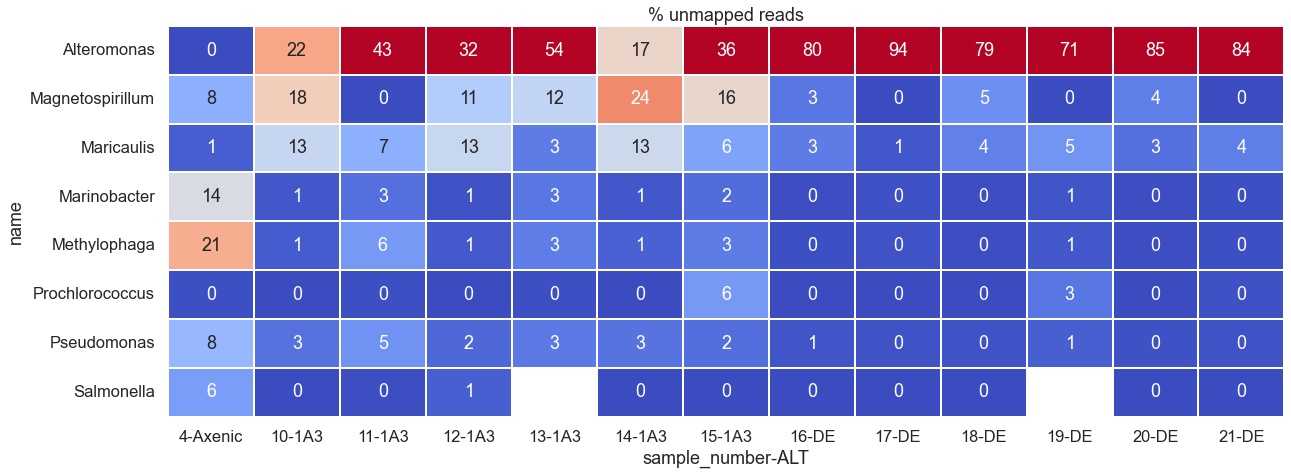

In [167]:
plt.figure(figsize=(20,7))
sns.set_context('talk')
common_names = kraken_unmapped_gdf.loc[kraken_unmapped_gdf.fraction_total_reads>0.05, 'name']
pkraken_unmapped_gdf = kraken_unmapped_gdf.loc[kraken_unmapped_gdf.name.isin(common_names)
                                              ].pivot_table(index='name', columns=['sample_number', 'ALT'], 
                                                       values='fraction_total_reads')
sns.heatmap(pkraken_unmapped_gdf*100, cmap='coolwarm', annot=True, vmax=30,
 fmt='.0f',
            linewidths=1, linecolor='white', cbar=False)           
plt.title('% unmapped reads', y=1)

Text(0.5, 1, 'unmapped reads')

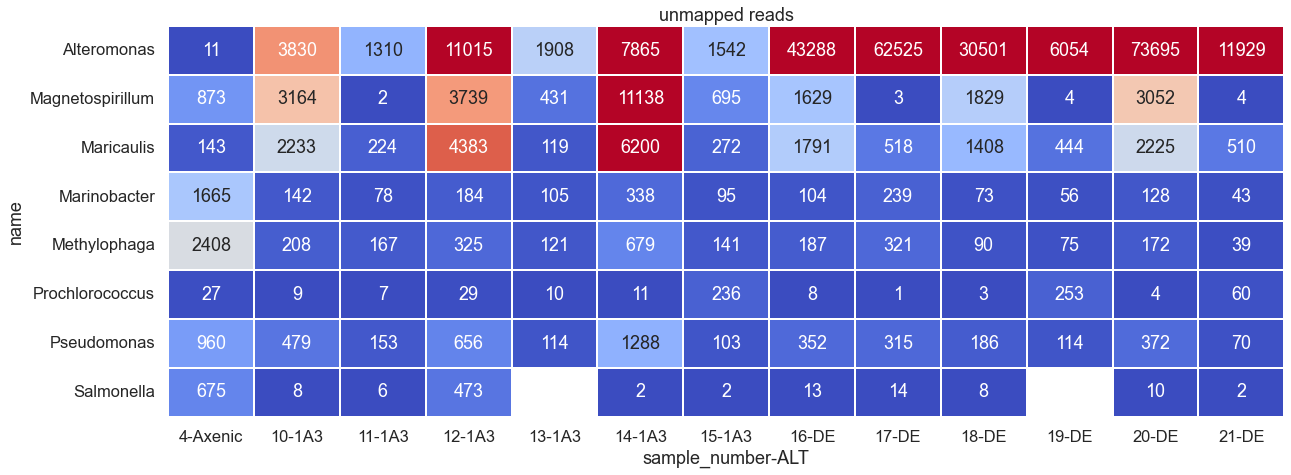

In [168]:
plt.figure(figsize=(20,7))
sns.set_context('talk')
common_names = kraken_unmapped_gdf.loc[kraken_unmapped_gdf.fraction_total_reads>0.05, 'name']
pkraken_unmapped_gdf = kraken_unmapped_gdf.loc[kraken_unmapped_gdf.name.isin(common_names)
                                              ].pivot_table(index='name', columns=['sample_number', 'ALT'], 
                                                       values='new_est_reads')
sns.heatmap(pkraken_unmapped_gdf, cmap='coolwarm', annot=True, vmax=5000,
 fmt='.0f',
            linewidths=1, linecolor='white', cbar=False)           
            
plt.title('unmapped reads', y=1)

# spades stats

In [ ]:
spades_header = ['Node', 'Length', 'Coverage']
df_spades_all = pd.read_csv(os.path.join('DNA', 'dnaseq', 'unmapped_contigs.txt'), names=spades_header)
df_spades_axenic = pd.read_csv(os.path.join('DNA', 'dnaseq', 'axenic_unmapped_contigs.txt'), names=spades_header)


Any chance it could be a bacteriophage? 
I would recommend performing a de novo assembly both on all the data and also on the unmapped data. 
It would be interesting to look at how the data plot 
(we plot **summed assembly length vs average coverage when sorted from highest coverage to lowest**).


In [ ]:
df_spades_all.sort_values(by='Coverage', ascending=False, inplace=True)
df_spades_all['Summed Assembly Length'] = df_spades_all['Length'].cumsum()
df_spades_all['Average Coverage'] = df_spades_all['Coverage'].expanding().mean()

In [ ]:
df_spades_axenic.sort_values(by='Coverage', ascending=False, inplace=True)
df_spades_axenic['Summed Assembly Length'] = df_spades_axenic['Length'].cumsum()
df_spades_axenic['Average Coverage'] = df_spades_axenic['Coverage'].expanding().mean()

In [ ]:
df_spades_all.head()

In [ ]:
sns.set_context('talk')
sns.relplot(data=df_spades_all, x='Summed Assembly Length', y='Average Coverage',
           kind='line', aspect=1.4)
plt.xlim(-0.1e7,1e7)
plt.ylim(-1000,8000)
plt.title('Unmapped MIT0604 Reads ')

In [ ]:
sns.set_context('talk')
sns.relplot(data=df_spades_axenic, x='Summed Assembly Length', y='Average Coverage', color='green',
           kind='line', aspect=1.4)
plt.xlim(-0.1e7,0.4e7)
plt.ylim(-100,600)
plt.title('Unmapped Axenic MIT0604 Reads ')

In [ ]:
df_spades_all.head(20)

In [ ]:
df_spades_axenic.head(20)

In [ ]:
unmapped_blastx_fpath = os.path.join('DNA', 'dnaseq', 'MIT0604 unmapped-Alignment.xml')
unmapped_axenic_blastx_fpath = os.path.join('DNA', 'dnaseq', 'MIT0604 unmapped axenic-Alignment.xml')

from Bio.Blast import NCBIXML
def _unmapped_blastx_to_rec(blast_rec):
    query_id = blast_rec.query.split('.')[0] #.replace(' unnamed protein product','').replace('lcl|','')
    node_id = int(query_id.split('_')[1])
    results = [{
        'query' : query_id,
        'Node' : node_id,
        'Subject' : a.hit_def,
        'Accession' : d.accession,
        'Qcov': np.round(np.mean([hsp.align_length / blast_rec.query_length for hsp in a.hsps]), decimals=2),
        'Ident': np.round(np.mean([hsp.identities / blast_rec.query_length for hsp in a.hsps]), decimals=2),
        }
        for d,a in zip(blast_rec.descriptions, blast_rec.alignments)
    ]
    return results
fh = open(unmapped_blastx_fpath)
blast_records = NCBIXML.parse(fh)
reslist = [_unmapped_blastx_to_rec(b) for b in blast_records]
unblastx_df = pd.DataFrame([i for lst in reslist for i in lst])
fh.close()
fh = open(unmapped_axenic_blastx_fpath )
blast_records = NCBIXML.parse(fh)
reslist = [_unmapped_blastx_to_rec(b) for b in blast_records]
axblastx_df = pd.DataFrame([i for lst in reslist for i in lst])
fh.close()

In [ ]:
unblastx_df.head()

In [ ]:
unblastx_df = pd.merge(df_spades_all.loc[df_spades_all.Coverage > 50], 
         unblastx_df.drop_duplicates(subset='Node', keep='first'),
         on='Node', how='left')
axblastx_df = pd.merge(df_spades_axenic.loc[df_spades_axenic.Coverage > 20], 
         axblastx_df.drop_duplicates(subset='Node', keep='first'),
         on='Node', how='left')

In [ ]:
with pd.option_context("display.max_colwidth", 100):

    display(unblastx_df[['Node', 'Length', 'Coverage',
        'Subject', 'Accession', 'Qcov', 'Ident']].fillna(''))


In [ ]:
with pd.option_context("display.max_colwidth", 100):

    display(axblastx_df[['Node', 'Length', 'Coverage',
        'Subject', 'Accession', 'Qcov', 'Ident']].fillna(''))


In [ ]:
unblastx_df.columns